In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

#### Question 1

In [59]:
def voltage_diff(voltage, args_v):
    leak_potential  = args_v['leak_potential']
    memb_resistance = args_v['membrane_resistance']
    tau_m           = args_v['tau_m']
    synapse_current = args_v['synapse_current']

    return (leak_potential - voltage + memb_resistance * synapse_current) / tau_m

In [85]:
def synapse_spike_chances(synapses_count):
    return np.array([random.uniform(0,1) for i in range(synapses_count)])

In [93]:
def q1_real(args_v, args_s, v_reset, v_threshold, synapses, time=1000, step=0.25):
    reversal_potential      = args_s['reversal_potential']
    peak_conductance        = args_s['g_bar']
    delta_s                 = args_s['delta_s']
    tau_s                   = args_s['tau_s']
    firing_rate             = args_s['firing_rate']

    time = np.linspace(0, time, int(time / step))

    volts = []
    spikes_count = 0
    v = v_reset
    
    s_vec = np.full(synapses, peak_conductance, dtype=float)
    peak_vec = np.full(synapses, peak_conductance, dtype=float)

    for i in time:
        synapse_spikes = synapse_spike_chances(synapses)
        for i, chance in enumerate(synapse_spikes):
            if chance < firing_rate * step:
                s_vec[i] += delta_s
            else:
                s_vec[i] = s_vec[i] - (s_vec[i] * step) / tau_s

        args_v['synapse_current'] = np.sum(s_vec * peak_vec) * (reversal_potential - v)

        v = v + step * voltage_diff(v, args_v)
        
        if (v > v_threshold):
            spikes_count += 1
            v = v_reset
        volts.append(v)
        
    return time, volts, spikes_count

In [101]:
args_v1 = {
    'leak_potential': -65,      # E_L (mV)
    'membrane_resistance': 100, # R_m (mV/nA)
    'tau_m': 10                 # Membrane time constant (ms)
}
v_reset = -65
v_threshold = -50

args_s1 = {
    'reversal_potential': 0,      # E_s (mV)
    'g_bar': 0.004,               # Peak conductance (nA/mV)
    'delta_s': 0.5,               # Conductance gate jump
    'tau_s': 2,                   # Membrane time constant (ms)
    'firing_rate': 0.015          # Spike Frequency (spikes/ms)
}

synapses_count = 40
time, volts, spikes_count = q1_real(args_v1, args_s1, v_reset, v_threshold, synapses_count)
print("spikes_count:", spikes_count)

spikes_count: 18


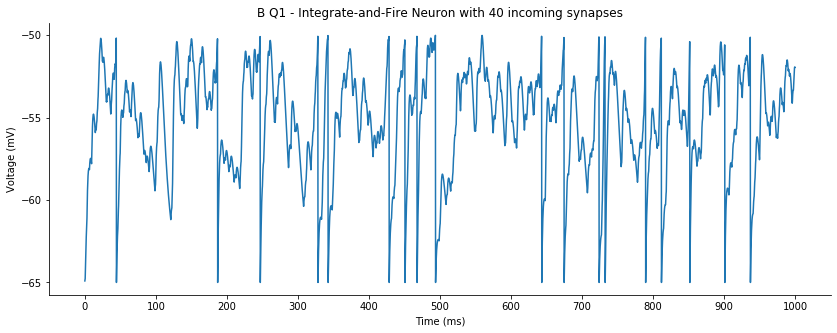

In [102]:
def plot_q1(title, filename, time, volts):
    fig = plt.figure(figsize=(14,5))
    ax = fig.add_subplot()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(title)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Voltage (mV)")
    ax.plot(time, volts)
    ax.set_yticks(range(-65,-45,5))
    ax.set_xticks(range(0,1001,100))
#     fig.savefig(f"plots/{filename}.png", bbox_inches='tight', pad_inches=0.2, dpi=100)
title = "B Q1 - Integrate-and-Fire Neuron with 40 incoming synapses"
plot_q1(title, 'b_q1', time, volts)

#### Question 2
Pre-before-post causes LT-Potentiation

Post-before-pre cuases LT-Depression

In [184]:
def conductance_diff(args_stdp, delta_t):
    a_plus      = args_stdp['a_plus']
    a_minus     = args_stdp['a_minus']
    tau_plus    = args_stdp['tau_plus']
    tau_minus   = args_stdp['tau_minus']
    if delta_t > 0:
        return a_plus * np.exp(-delta_t / tau_plus)
    else:
        return - a_minus * np.exp(delta_t / tau_minus)   

In [ ]:
def sanitize_conductance(conductance, peak):
    if conductance > peak:
        return peak
    elif  conductance < 0:
        return 0
    else:
        return conductance

In [186]:
def update_conductance(args_stdp, peak_vec, index, delta_t, peak):
    delta_peak = conductance_diff(args_stdp, delta_t)
    peak_vec[index] = sanitize_conductance(peak_vec[index] + delta_peak,
                                           peak)

In [187]:
def q1_stdp(args_v, args_s, args_stdp, time=1000, step=0.25):
    v_reset                 = args_v['v_reset']
    v_threshold             = args_v['v_threshold']
    
    synapses_count          = args_s['synapses_count']
    reversal_potential      = args_s['reversal_potential']
    peak_conductance        = args_s['g_bar']
    delta_s                 = args_s['delta_s']
    tau_s                   = args_s['tau_s']
    firing_rate             = args_s['firing_rate']
    
    stdp                    = args_stdp['enabled']

    time = np.linspace(0, time, int(time / step))

    volts = []
    spikes_count = 0
    v = v_reset
    
    s_vec = np.full(synapses_count, peak_conductance, dtype=float)
    peak_vec = np.full(synapses_count, peak_conductance, dtype=float)
    
    t_pre  = np.full(synapses_count, -1, dtype=float)
    t_post = -1

    for i in time:
        
        synapse_spikes = synapse_spike_chances(synapses_count)
        for j, chance in enumerate(synapse_spikes):
            if chance < firing_rate * step:
                s_vec[j] += delta_s
                t_pre[j] = i
                if stdp:
                    update_conductance(args_stdp, peak_vec, j, t_post - t_pre[j], peak_conductance)
            else:
                s_vec[j] = s_vec[j] - (s_vec[j] * step) / tau_s 

        args_v['synapse_current'] = np.sum(s_vec * peak_vec) * (reversal_potential - v)

        v = v + step * voltage_diff(v, args_v)
        
        if (v > v_threshold):
            spikes_count += 1
            v = v_reset
            t_post = i
            if stdp: update_conductance(args_stdp, peak_vec, j, t_post - t_pre[j], peak_conductance)
        
        volts.append(v)
        
    return time, volts, spikes_count, peak_vec

#### STDP ON

In [ ]:
args_v2 = {
    'leak_potential': -65,      # E_L (mV)
    'membrane_resistance': 100, # R_m (mV/nA)
    'tau_m': 10,                # Membrane time constant (ms)
    'v_reset': -65,             # (mV)
    'v_threshold': -50          # (mV)
}

args_s2 = {
    'synapses_count': 40,         # N
    'reversal_potential': 0,      # E_s (mV)
    'g_bar': 0.004,               # Peak conductance (nA/mV)
    'delta_s': 0.5,               # Conductance gate jump
    'tau_s': 2,                   # Membrane time constant (ms)
    'firing_rate': 0.015          # Spike Frequency (spikes/ms)
}

args_stdp = {
    'enabled':   True,        # "ON"
    'a_plus':    0.0002,      # (nA/mV)
    'a_minus':   0.00025,     # (nA/mV)
    'tau_plus':  20,          # (ms)
    'tau_minus': 20           # (ms)
}

time, volts2, spikes2, conductances_vec = q1_stdp(args_v2, args_s2, args_stdp, time=300000)
print(conductances_vec.shape)

0.003790135766668575
0.0038610713530626293
0.003877395912168772
0.0038904413226404904
0.0039020986657370828
0.003911415216865338
0.003915735551230317
0.0037848257331594528
0.00393186712271334
0.003935995088403436
0.00393911664731359
0.00393911664731359
0.003941357496392902
0.0039482481775977496
0.0038639992239954905
0.003953173018541144
0.003954329181784287
0.003954329181784287
0.004146968059308481
0.0037151481607347065
0.003499971193525587
0.0037901357754129253
0.00329783115024089
0.003814795491130742
0.0038385879272412383
0.0037104593173152077
0.003652932934990913
0.003807720869184217
0.00387739591727728
0.003189633438264469
0.0038304687896525123
0.0038527933022931044
0.003918836959250862
0.003923754383273727
0.003930142332168521
0.003824816120359897
0.0038826325193166977
0.0039455948049237285
0.003948891051722362
0.0037584930170459856
0.003607829451139825
0.00395601012604948
0.0039606907690234215
0.003962607904398589
0.003963531119288202
0.003909578948299063
0.0041394102216901615
0.

0.0032231297752703765
0.0034306508796668254
0.0037242994136941045
0.0028753791956072717
0.00345441514654294
0.002839577080945081
0.002773070651060776
0.003359454721595929
0.003140953464418929
0.002948900290473949
0.0036334720979899946
0.0036637050837359827
0.003193940652343617
0.003252819792716867
0.003700843367871579
0.003292779436355644
0.003657939608672589
0.0034915147461507968
0.0026434794823704043
0.0032664226957590304
0.0028115279094463866
0.0032280664883276764
0.0030311483835169565
0.0031158234649323706
0.003092858749455487
0.003173419445440237
0.0029967842596463476
0.0031226157700897637
0.003214817006160532
0.0033198844238235808
0.003081311371950284
0.00286810772925746
0.0031666733903197705
0.0029772437473473148
0.003283610850876598
0.002991121237138834
0.0030925090088057263
0.0032611688638431178
0.0034256532803652617
0.003160217822382024
0.003257077176285315
0.0030888981075857572
0.0034880799508045135
0.0029361650300094876
0.003652126883992186
0.002945869094535592
0.0035050274

0.002832316140490496
0.0033560828319284005
0.0036434589324993534
0.0033996191942840693
0.0032688901361983525
0.003629240053977211
0.0028146738178459287
0.0034702780864960085
0.0026358252612958444
0.0033560824934500224
0.002635824939325265
0.0026358246690448405
0.003222543728807169
0.0026894545750073243
0.002812684495400909
0.0033030142902071443
0.002721517102336037
0.002578830003800101
0.0029211210681097956
0.0033996190633806983
0.0032300161368228894
0.0029169768439215754
0.002887632366046212
0.003474016606698695
0.002689454480426084
0.0027215170258614125
0.0029038157139651016
0.002812684427063394
0.002689454420118445
0.0034702780261883694
0.002824773921086418
0.0027215169783030052
0.003356082454022724
0.003257576741982982
0.0029211210345959624
0.0036292400232712067
0.002677979451489053
0.0027851424868868095
0.0028126844016072264
0.0024157279698961
0.0028126843807654827
0.0030047225053653785
0.0031628277847709878
0.003303057668185618
0.00326889012187405
0.0032225437144828666
0.00308339

0.003638529845767085
0.0027749475553389535
0.0032686529672414553
0.0038194973142936448
0.002392809013830983
0.002185149971084695
0.00287516563692533
0.0022823578514365407
0.0034346626137748575
0.0020610037175555727
0.0031269370726996195
0.0031167266453907354
0.001973519356826699
0.003373915674636795
0.0037413215289618246
0.0033550375950422316
0.002320281942733713
0.002361560268675771
0.002723648845621636
0.0023110862064759587
0.0023171782053211664
0.0022697622144269877
0.0029694372890379257
0.0029310986072309804
0.003115358645085466
0.0026517910572245408
0.0037103223977620883
0.0025651347673107863
0.0030195696195191705
0.002632010226427521
0.0031064158657962398
0.003095592733768922
0.0033390556663658805
0.003067047150602694
0.0036329863019090598
0.001963200651889369
0.0037017678922437727
0.0031831278221632923
0.0036252458658683298
0.003620666971409166
0.0034308188292343036
0.003113695449452378
0.0026443121544761305
0.002916040239290777
0.0028295462071986376
0.0028218521463445243
0.0033

0.0026476621941007436
0.0027109818081719065
0.002625804086356329
0.0033646786387987516
0.002913864548625845
0.002556424546296845
0.002556009159193957
0.0027192932083406995
0.003381954308556434
0.0026473046671526747
0.003381601222883121
0.002913564420162943
0.002035828131496747
0.0025485124853171608
0.002866837416880342
0.0031310297066674173
0.0032261799631991077
0.00341127931711636
0.003286338333917978
0.0034110455768831265
0.0027107538390103427
0.003701842981166196
0.0024094973209361444
0.002475900585538929
0.0025486638360274184
0.002248085248177383
0.0031633786105732665
0.0019346685631658395
0.002364963833132174
0.0027401943278128242
0.003052853921335597
0.002915669248531719
0.002306321331968516
0.0025000475025961266
0.0020245943221925164
0.002207780898441236
0.002267982650161571
0.0031255161799149302
0.0030159263181903616
0.0029470769522166643
0.0030351074140534066
0.0021995637701338368
0.0028865482612635373
0.0028577890210085923
0.0028732347711118928
0.00284081498235192
0.002850438

0.0029889054813913452
0.003820447694812269
0.002495423038328224
0.0014978041463576748
0.0020782914935683033
0.002687479506020464
0.0018396538719395784
0.003030676492440542
0.0027721778909365396
0.0031525165763940676
0.0024978070180168097
0.0020782882417743754
0.0038204446779818223
0.002988903011419893
0.0021506791833230377
0.0027842359185137775
0.002687477787083096
0.0026907087173118475
0.0021644570720382233
0.0023106956693310795
0.0027842345111671264
0.001497803008433223
0.0014978019123907773
0.0020782872121378384
0.0021506781915829037
0.002123654999131991
0.001839653080019145
0.0026907079733714864
0.002078286571822516
0.002988902386914025
0.0026266201604124247
0.0024801339687748098
0.001942364617341375
0.0024978065553715994
0.0021456608440508823
0.00212365456451706
0.0021456604306323884
0.0023106953350573506
0.0030877923315544556
0.00315251629578568
0.0030306762539189297
0.0013180445337828072
0.0025771294659957945
0.003820444499058082
0.002784234375261672
0.001497801778173569
0.00278

0.0019423646157106932
0.003271136099458854
0.0027842342475809987
0.002736869037659609
0.0021644570704977056
0.0013180445337591861
0.0019423646157106932
0.002150678191365915
0.0021644570704977056
0.003011813475027164
0.002480133941675763
0.002310695246327387
0.0024954229574019396
0.0024727819813960537
0.002567222722327805
0.002736869037659609
0.0019072452805016413
0.0034777039977420578
0.003271136099458854
0.0018396530800189868
0.003271136099458854
0.0027721778182264916
0.003271136099458854
0.002379895713926074
0.002687477785215584
0.0024727819813960537
0.0024954229574019396
0.002600242402915779
0.0024978065309434897
0.0020485536733067028
0.0026534344566414196
0.003271136099458854
0.0028290818777700613
0.0018396530800189868
0.0027721778182264916
0.0029889023519470244
0.0021644570704977056
0.0021456604297917935
0.0038204444332867868
0.002480133941675763
0.0021644570704977056
0.0013971056721386623
0.003011813475027164
0.0013180445337591861
0.0013180445337591861
0.0018396530800189868
0.002

0.0026534344566414196
0.002600242402915779
0.0026875558607644414
0.0019072452805016413
0.003152516283012967
0.0021456604297917935
0.0030306762539156944
0.0026875558607644414
0.0027842342475809987
0.0027721778182264916
0.002687477785215584
0.0029889023519470244
0.0026875558607644414
0.0015241025048815125
0.0013971056721386623
0.0026907079250262467
0.0026534344566414196
0.0030306762539156944
0.0026534344566414196
0.002150678191365915
0.002379895713926074
0.0026907079250262467
0.0027842342475809987
0.0013971056721386623
0.0030087120938052225
0.0038204444332867868
0.002310695246327387
0.0026534344566414196
0.0024954229574019396
0.0020485536733067028
0.0019072452805016413
0.0019072452805016413
0.0019072452805016413
0.0020485536733067028
0.002379895713926074
0.002150678191365915
0.0029889023519470244
0.0019423646157106932
0.0038204444332867868
0.0020485536733067028
0.002736869037659609
0.0013971056721386623
0.0029889023519470244
0.002379895713926074
0.0026266201600958165
0.002495422957401939

0.002749069225083582
0.0012387778327908048
0.002370854762916148
0.0026495710196913986
0.0012221020067509718
0.002085369146047962
0.0020853691457616134
0.0025491834167681664
0.0029609426146417466
0.0012221020065251583
0.0019911920425172347
0.0027475065764528965
0.002586028598716623
0.0014403675099771713
0.0012221020064130228
0.0012387778326800622
0.002960942614536405
0.002625658627150497
0.0026363731486739555
0.0021235757237104557
0.002468461589972592
0.0020853691456873802
0.0022974011115328642
0.0022974011114673537
0.0020648815139371174
0.002599167921781869
0.0026495710196328586
0.0025860285986692897
0.0025860285986259225
0.002085369145644013
0.002196936269216995
0.001991192042478482
0.002044397963076499
0.0039960006408388616
0.0031467256839692696
0.0024486898744899726
0.0023708547628937897
0.0029609426145143242
0.002123575723690476
0.002297401111447374
0.002370854762875021
0.0019911920424663635
0.002203729709518023
0.0025860285986163663
0.0024718849543170804
0.0027839694580554736
0.00

0.0034774608320058396
0.0025491834167681465
0.0022974011114467634
0.002196936269213046
0.0031951889587332207
0.002747506576452817
0.0014976206246836263
0.0026495710196296103
0.0030736252369429856
0.002082185240376219
0.002586028598609546
0.002082185240376219
0.0014403675099770247
0.001991192042463992
0.001991192042463992
0.0012221020064130228
0.0023708547628721994
0.0017651583705198906
0.0017469295655556123
0.0018637614533183683
0.0012221020064130228
0.002082185240376219
0.002014937348828891
0.0031951889587332207
0.002014937348828891
0.0031951889587332207
0.002468461589970281
0.0020853691456430745
0.0025991679217818625
0.0012387778326799401
0.0034774608320058396
0.002636373148673171
0.0017469295655556123
0.0026495710196296103
0.002747506576452817
0.002044397963076113
0.002586028598609546
0.0018637614533183683
0.0014976206246836263
0.0027839694580554736
0.0014403675099770247
0.0026806411645604314
0.0026256586271452276
0.0030736252369429856
0.0018637614533183683
0.002448689874489957
0.00

0.0027490692250835436
0.002448689874489957
0.0017651583705198906
0.002196936269213046
0.002468757769924024
0.002014937348828891
0.002196936269213046
0.0012387778326799401
0.0026495710196296103
0.0014976206246836263
0.002468757769924024
0.0031467256839690615
0.002196936269213046
0.002468461589970281
0.0031951889587332207
0.0020853691456430745
0.0020648815139371044
0.002586028598609546
0.0027618244003118245
0.0014403675099770247
0.002468757769924024
0.0034774608320058396
0.0034774608320058396
0.002586028598609546
0.0027839694580554736
0.002471884954317079
0.0025991679217818625
0.0031467256839690615
0.002196936269213046
0.002960942614513317
0.0022974011114467634
0.0027839694580554736
0.0012221020064130228
0.002471884954317079
0.0017651583705198906
0.002468757769924024
0.002747506576452817
0.002471884954317079
0.002203729709518023
0.0017469295655556123
0.002203729709518023
0.002747506576452817
0.0017651583705198906
0.0012387778326799401
0.0021235757236872056
0.0014976206246836263
0.0020853

0.002014937348828891
0.0022974011114467634
0.002739110931696595
0.002747506576452817
0.0012387778326799401
0.002960942614513317
0.002739110931696595
0.0027839694580554736
0.0020853691456430745
0.0012221020064130228
0.002082185240376219
0.0014403675099770247
0.0031467256839690615
0.002203729709518023
0.0027839694580554736
0.0017651583705198906
0.002471884954317079
0.0031467256839690615
0.0025491834167681465
0.002636373148673171
0.0025491834167681465
0.0017651583705198906
0.0020853691456430745
0.0020648815139371044
0.002082185240376219
0.0026256586271452276
0.001991192042463992
0.0034774608320058396
0.0017651583705198906
0.0026256586271452276
0.002448689874489957
0.0014976206246836263
0.002586028598609546
0.0014976206246836263
0.0031467256839690615
0.0021235757236872056
0.0017651583705198906
0.0018637614533183683
0.0018637614533183683
0.0017469295655556123
0.0012387778326799401
0.0014976206246836263
0.0021235757236872056
0.0017469295655556123
0.0014976206246836263
0.002082185240376219
0.

0.0018637614533183683
0.0017651583705198906
0.0034774608320058396
0.0039960006408373185
0.0026256586271452276
0.002014937348828891
0.0026495710196296103
0.0025991679217818625
0.002468461589970281
0.0018637614533183683
0.0025491834167681465
0.002586028598609546
0.0012387778326799401
0.0034774608320058396
0.0014403675099770247
0.0026256586271452276
0.0027618244003118245
0.0031951889587332207
0.0039960006408373185
0.002082185240376219
0.0034774608320058396
0.002448689874489957
0.0025991679217818625
0.0027839694580554736
0.0018637614533183683
0.0031951889587332207
0.0039960006408373185
0.002014937348828891
0.002747506576452817
0.002468461589970281
0.0027839694580554736
0.002468461589970281
0.002471884954317079
0.0025491834167681465
0.0025991679217818625
0.0020648815139371044
0.0018637614533183683
0.002586028598609546
0.0020648815139371044
0.002747506576452817
0.0012221020064130228
0.0039960006408373185
0.002586028598609546
0.0025991679217818625
0.0034774608320058396
0.0022974011114467634
0

0.0018522532727566958
0.002961911455697626
0.0020458413699573318
0.0026247414253454788
0.0026475512055740467
0.0029343236313739227
0.002031536535804622
0.0026247414253454788
0.002961911455697626
0.0024706630382903324
0.0026247414253454788
0.0029150887528198266
0.0018522532727566958
0.0024846140863509893
0.0029608758003261625
0.0014912598686578982
0.0023938254624780394
0.0023938254624780394
0.0027613408084902597
0.002447512497181441
0.002604607060737783
0.0025382264490042663
0.0014912598686578982
0.002575806229750382
0.00120579189912274
0.0025382264490042663
0.0023708526535216163
0.0018409512556106296
0.001285855828542748
0.0016185080039246523
0.002575806229750382
0.0029343236313739227
0.0020692334378252203
0.0026247414253454788
0.001985072305782103
0.002407844249677336
0.0016330753246529518
0.0020428312900289177
0.0018409512556106296
0.0020692334378252203
0.002604607060737783
0.0014912598686578982
0.0029343236313739227
0.002031536535804622
0.002575806229750382
0.0029608758003261625
0.0

0.00120579189912274
0.0020819235930402634
0.0027205438849025394
0.001985072305782103
0.0016185080039246523
0.002031536535804622
0.003477044435213711
0.002607930163124313
0.002575806229750382
0.0016185080039246523
0.0015764672504231308
0.0023708526535216163
0.002607930163124313
0.0014912598686578982
0.0025382264490042663
0.0023708526535216163
0.002031536535804622
0.002961911455697626
0.0016185080039246523
0.002636363811244738
0.003477044435213711
0.0014912598686578982
0.0027613408084902597
0.002031536535804622
0.0023708526535216163
0.0023938254624780394
0.001285855828542748
0.0024706630382903324
0.0029150887528198266
0.003477044435213711
0.0020819235930402634
0.0027205438849025394
0.0027205438849025394
0.00120579189912274
0.003477044435213711
0.0027613408084902597
0.0011615239456467012
0.001985072305782103
0.0039281214670751335
0.0011615239456467012
0.001285855828542748
0.0020819235930402634
0.0018409512556106296
0.0020819235930402634
0.0014912598686578982
0.0025382264490042663
0.002702

0.0024706630382903324
0.002031536535804622
0.002961911455697626
0.0020428312900289177
0.0018409512556106296
0.0024706630382903324
0.0023708526535216163
0.0016330753246529518
0.0027613408084902597
0.0025382264490042663
0.0027613408084902597
0.001285855828542748
0.0026475512055740467
0.002575806229750382
0.0029343236313739227
0.0016185080039246523
0.0011615239456467012
0.0024846140863509893
0.002607930163124313
0.0020692334378252203
0.0026247414253454788
0.002447512497181441
0.0022973986069676515
0.0027205438849025394
0.001985072305782103
0.002636363811244738
0.0015764672504231308
0.0018522532727566958
0.0020428312900289177
0.001285855828542748
0.001285855828542748
0.00120579189912274
0.0020428312900289177
0.0018409512556106296
0.0020819235930402634
0.0020692334378252203
0.0027613408084902597
0.0014912598686578982
0.0023708526535216163
0.0015764672504231308
0.001985072305782103
0.0039281214670751335
0.002575806229750382
0.0027613408084902597
0.001985072305782103
0.0016185080039246523
0.0

0.0020428312900289177
0.002607930163124313
0.002961911455697626
0.002575806229750382
0.002607930163124313
0.0024706630382903324
0.002607930163124313
0.002961911455697626
0.002447512497181441
0.0029343236313739227
0.0022033880024553087
0.002607930163124313
0.0018522532727566958
0.0018409512556106296
0.0024846140863509893
0.00120579189912274
0.0020692334378252203
0.0026475512055740467
0.0029608758003261625
0.001285855828542748
0.002447512497181441
0.0020458413699573318
0.002961911455697626
0.0018522532727566958
0.002031536535804622
0.0027613408084902597
0.002961911455697626
0.0020458413699573318
0.0020428312900289177
0.0020458413699573318
0.0024706630382903324
0.0029608758003261625
0.0022033880024553087
0.0026802506365836572
0.0020819235930402634
0.0011615239456467012
0.002607930163124313
0.0011615239456467012
0.0026475512055740467
0.001285855828542748
0.002407844249677336
0.00270222130017601
0.0026802506365836572
0.002961911455697626
0.0016330753246529518
0.0024846140863509893
0.0019850

0.0024706630382903324
0.0016185080039246523
0.0029343236313739227
0.0023708526535216163
0.0015764672504231308
0.0018522532727566958
0.0014912598686578982
0.00120579189912274
0.0026802506365836572
0.0020458413699573318
0.001285855828542748
0.002604607060737783
0.0024706630382903324
0.0026802506365836572
0.0027613408084902597
0.0022033880024553087
0.0020428312900289177
0.002607930163124313
0.002407844249677336
0.002636363811244738
0.0015764672504231308
0.0014912598686578982
0.002447512497181441
0.0015764672504231308
0.0022973986069676515
0.0029343236313739227
0.0026247414253454788
0.002607930163124313
0.0029343236313739227
0.002636363811244738
0.00120579189912274
0.0026475512055740467
0.00120579189912274
0.0027205438849025394
0.002636363811244738
0.0020692334378252203
0.0023708526535216163
0.0026247414253454788
0.0022973986069676515
0.002031536535804622
0.0023938254624780394
0.0025382264490042663
0.0020458413699573318
0.002447512497181441
0.0029343236313739227
0.0024846140863509893
0.002

0.00270222130017601
0.002636363811244738
0.0026802506365836572
0.0022973986069676515
0.001985072305782103
0.0025382264490042663
0.0016330753246529518
0.0029343236313739227
0.0027205438849025394
0.0018522532727566958
0.0020692334378252203
0.002604607060737783
0.002031536535804622
0.0027205438849025394
0.0027613408084902597
0.0020428312900289177
0.00270222130017601
0.002407844249677336
0.002607930163124313
0.002604607060737783
0.0018409512556106296
0.0016185080039246523
0.0018522532727566958
0.0015764672504231308
0.0020692334378252203
0.0023708526535216163
0.002575806229750382
0.0016185080039246523
0.00270222130017601
0.0024706630382903324
0.0020819235930402634
0.0026475512055740467
0.0029608758003261625
0.0025382264490042663
0.0015764672504231308
0.001285855828542748
0.0026475512055740467
0.0014912598686578982
0.002031536535804622
0.0039281214670751335
0.0024706630382903324
0.0018409512556106296
0.00120579189912274
0.0024706630382903324
0.0029150887528198266
0.0020819235930402634
0.0022

0.0027205438849025394
0.0024706630382903324
0.002607930163124313
0.0026802506365836572
0.0029343236313739227
0.002607930163124313
0.0029608758003261625
0.0026247414253454788
0.0029150887528198266
0.0016185080039246523
0.002447512497181441
0.002961911455697626
0.0020428312900289177
0.0020819235930402634
0.0027205438849025394
0.002961911455697626
0.0016330753246529518
0.0029608758003261625
0.0023938254624780394
0.0023708526535216163
0.0025382264490042663
0.0029343236313739227
0.0024846140863509893
0.0023938254624780394
0.001285855828542748
0.0024706630382903324
0.003477044435213711
0.0016185080039246523
0.0014912598686578982
0.0029150887528198266
0.0020458413699573318
0.0022973986069676515
0.0018522532727566958
0.002407844249677336
0.001985072305782103
0.0026475512055740467
0.0027205438849025394
0.0023708526535216163
0.0020819235930402634
0.001985072305782103
0.0029150887528198266
0.0039281214670751335
0.0026247414253454788
0.0011615239456467012
0.0029150887528198266
0.002680250636583657

0.0024706630382903324
0.0016330753246529518
0.0016185080039246523
0.002447512497181441
0.0020428312900289177
0.0014912598686578982
0.0016185080039246523
0.0022973986069676515
0.0039281214670751335
0.002961911455697626
0.002961911455697626
0.002407844249677336
0.00120579189912274
0.00120579189912274
0.002575806229750382
0.0016185080039246523
0.0015764672504231308
0.001985072305782103
0.002604607060737783
0.0029343236313739227
0.0015764672504231308
0.0026475512055740467
0.0023708526535216163
0.003477044435213711
0.002636363811244738
0.0022973986069676515
0.001985072305782103
0.00120579189912274
0.004037883739412731
0.001600152658705394
0.002546163841281127
0.0016782697468946083
0.0010060527430711776
0.0014466127520251153
0.003846460093319721
0.0012968637622676924
0.0023975502992099264
0.00216850847313314
0.0019186850364997813
0.001513498350009521
0.0014039396772149524
0.002290696641910843
0.0014821692386495589
0.0018322874248535104
0.0014030101221657063
0.002859960527181308
0.00237588637

0.0016161550038961956
0.0012179411507265224
0.0028762566838862825
0.002010304495665731
0.00206884180728927
0.002289061224891969
0.002289061224891969
0.0022721937241270075
0.002605451580008431
0.0038241706615555118
0.001005941692199272
0.002901551983367554
0.0023758862248210587
0.0016161550038961956
0.0022008273627342765
0.0022721937241270075
0.002325047684702005
0.00206884180728927
0.0024063057036078916
0.002325047684702005
0.0024007361928968063
0.0034745020239138813
0.0016161550038961956
0.0029406836729063096
0.00206884180728927
0.002901551983367554
0.0022008273627342765
0.002704956527111758
0.002590850175664439
0.0012424075315945694
0.0029406836729063096
0.0018270938716684895
0.002704956527111758
0.0026199753909714797
0.0026199753909714797
0.002901551983367554
0.0034745020239138813
0.00285782402055509
0.002590850175664439
0.0024421710197385232
0.002646844060426555
0.002010304495665731
0.001005941692199272
0.0022008273627342765
0.0016161550038961956
0.0014438632097589603
0.00261997539

0.0012057918989625835
0.0019827839251169255
0.0022008273627342765
0.002289061224891969
0.0022008273627342765
0.0021393866338470942
0.002704956527111758
0.0038241706615555118
0.0022008273627342765
0.0027020150406542216
0.002901551983367554
0.001984727146387955
0.002289061224891969
0.001005941692199272
0.0038241706615555118
0.0022721937241270075
0.0012424075315945694
0.002289061224891969
0.0025641760139348503
0.002603509448727795
0.002605451580008431
0.002646844060426555
0.002901551983367554
0.002680019799919327
0.0034745020239138813
0.001005941692199272
0.0034745020239138813
0.0024421710197385232
0.0026199753909714797
0.0021393866338470942
0.0023758862248210587
0.002043928827386574
0.0025641760139348503
0.0016776369839465466
0.0013422899733533731
0.0025641760139348503
0.0019827839251169255
0.002043928827386574
0.0024063057036078916
0.0025641760139348503
0.0024421710197385232
0.002704956527111758
0.002043928827386574
0.002901551983367554
0.0022008273627342765
0.002646844060426555
0.00213

0.002901551983367554
0.00285782402055509
0.0024063057036078916
0.0026199753909714797
0.0028762566838862825
0.0025456524657087413
0.0018270938716684895
0.0026199753909714797
0.0038241706615555118
0.0022721937241270075
0.002646844060426555
0.002043928827386574
0.0019827839251169255
0.0019827839251169255
0.002680019799919327
0.0022721937241270075
0.0038241706615555118
0.0013795649550814137
0.0012179411507265224
0.0026199753909714797
0.002590850175664439
0.002325047684702005
0.002010304495665731
0.0028762566838862825
0.002605451580008431
0.0026199753909714797
0.002325047684702005
0.0019827839251169255
0.0025641760139348503
0.0022721937241270075
0.002605451580008431
0.0027020150406542216
0.002646844060426555
0.0029406836729063096
0.0014438632097589603
0.0026199753909714797
0.0028762566838862825
0.002590850175664439
0.00285782402055509
0.002043928827386574
0.0012057918989625835
0.0019827839251169255
0.0024421710197385232
0.002325047684702005
0.002901551983367554
0.002289061224891969
0.002605

0.0026199753909714797
0.0019827839251169255
0.001005941692199272
0.001984727146387955
0.002901551983367554
0.0014438632097589603
0.0012179411507265224
0.002901551983367554
0.0025456524657087413
0.0021393866338470942
0.0022721937241270075
0.0025641760139348503
0.002325047684702005
0.0012424075315945694
0.0034745020239138813
0.0024063057036078916
0.002590850175664439
0.002901551983367554
0.0013422899733533731
0.002603509448727795
0.002325047684702005
0.0025456524657087413
0.0022008273627342765
0.0012179411507265224
0.002901551983367554
0.0012179411507265224
0.002289061224891969
0.002603509448727795
0.002901551983367554
0.002325047684702005
0.002646844060426555
0.0024421710197385232
0.0038241706615555118
0.0024063057036078916
0.0025641760139348503
0.002043928827386574
0.001984727146387955
0.0016161550038961956
0.0024007361928968063
0.002603509448727795
0.002646844060426555
0.0022721937241270075
0.0024421710197385232
0.002043928827386574
0.0016776369839465466
0.0016161550038961956
0.001982

0.001005941692199272
0.0029406836729063096
0.0034745020239138813
0.0013422899733533731
0.002010304495665731
0.0024421710197385232
0.0022721937241270075
0.0021393866338470942
0.002646844060426555
0.0018270938716684895
0.0026199753909714797
0.0024063057036078916
0.002680019799919327
0.0012424075315945694
0.0016776369839465466
0.0019827839251169255
0.0022721937241270075
0.002325047684702005
0.002010304495665731
0.002010304495665731
0.00206884180728927
0.0025641760139348503
0.0014438632097589603
0.0024421710197385232
0.00285782402055509
0.0023758862248210587
0.002605451580008431
0.0013795649550814137
0.0012179411507265224
0.0027020150406542216
0.0024063057036078916
0.002605451580008431
0.002605451580008431
0.002590850175664439
0.002590850175664439
0.001984727146387955
0.0014438632097589603
0.0027020150406542216
0.0028762566838862825
0.0029406836729063096
0.002325047684702005
0.0024421710197385232
0.0016776369839465466
0.00206884180728927
0.002590850175664439
0.0021393866338470942
0.0013795

0.0027020150406542216
0.0034745020239138813
0.00285782402055509
0.002289061224891969
0.0012179411507265224
0.002605451580008431
0.002010304495665731
0.0023758862248210587
0.0023758862248210587
0.001984727146387955
0.0016776369839465466
0.002603509448727795
0.0014438632097589603
0.0012179411507265224
0.0026199753909714797
0.002605451580008431
0.0024421710197385232
0.002043928827386574
0.0027020150406542216
0.001984727146387955
0.0024007361928968063
0.002605451580008431
0.00285782402055509
0.0034745020239138813
0.0022008273627342765
0.0012179411507265224
0.0028762566838862825
0.001984727146387955
0.0024063057036078916
0.0027020150406542216
0.002289061224891969
0.0024007361928968063
0.0028762566838862825
0.00206884180728927
0.0012424075315945694
0.002680019799919327
0.0012179411507265224
0.00285782402055509
0.0013422899733533731
0.0038241706615555118
0.0019827839251169255
0.002646844060426555
0.001005941692199272
0.0038241706615555118
0.002590850175664439
0.0028762566838862825
0.002325047

0.0021393866338470942
0.0022008273627342765
0.00285782402055509
0.0012424075315945694
0.0023758862248210587
0.002680019799919327
0.0025641760139348503
0.00285782402055509
0.0034745020239138813
0.002680019799919327
0.0013795649550814137
0.0027020150406542216
0.0019827839251169255
0.00285782402055509
0.002704956527111758
0.0016161550038961956
0.002646844060426555
0.001005941692199272
0.002680019799919327
0.0022008273627342765
0.002901551983367554
0.0013795649550814137
0.0018270938716684895
0.0012057918989625835
0.0029406836729063096
0.002325047684702005
0.0013422899733533731
0.0014438632097589603
0.002680019799919327
0.0023758862248210587
0.0027020150406542216
0.0012057918989625835
0.002010304495665731
0.0024421710197385232
0.0019827839251169255
0.0012179411507265224
0.00206884180728927
0.0019827839251169255
0.002646844060426555
0.0012057918989625835
0.0013795649550814137
0.0025641760139348503
0.0016161550038961956
0.0022008273627342765
0.0013422899733533731
0.0029406836729063096
0.00206

0.0024063057036078916
0.0024063057036078916
0.0024007361928968063
0.0028762566838862825
0.002605451580008431
0.0025641760139348503
0.0012179411507265224
0.0012179411507265224
0.002325047684702005
0.001984727146387955
0.0019827839251169255
0.002010304495665731
0.002901551983367554
0.002289061224891969
0.0027020150406542216
0.0013422899733533731
0.0024421710197385232
0.001984727146387955
0.0025641760139348503
0.001984727146387955
0.0027020150406542216
0.0026199753909714797
0.0022721937241270075
0.0034745020239138813
0.002289061224891969
0.0012179411507265224
0.0023758862248210587
0.0012424075315945694
0.001005941692199272
0.0024007361928968063
0.0024063057036078916
0.002603509448727795
0.0026199753909714797
0.0024007361928968063
0.0024063057036078916
0.0025641760139348503
0.0022721937241270075
0.0025641760139348503
0.0024007361928968063
0.002704956527111758
0.0024421710197385232
0.001005941692199272
0.0026199753909714797
0.0025641760139348503
0.0016161550038961956
0.002680019799919327
0.

0.0012179411507265224
0.002325047684702005
0.001984727146387955
0.0025641760139348503
0.0038241706615555118
0.0024007361928968063
0.0027020150406542216
0.002901551983367554
0.0025641760139348503
0.0034745020239138813
0.0028762566838862825
0.002704956527111758
0.0029406836729063096
0.0014438632097589603
0.00206884180728927
0.002704956527111758
0.00285782402055509
0.002901551983367554
0.0024063057036078916
0.002325047684702005
0.0018270938716684895
0.0013795649550814137
0.0012424075315945694
0.0028762566838862825
0.002704956527111758
0.0022721937241270075
0.0025641760139348503
0.0012179411507265224
0.00285782402055509
0.0025456524657087413
0.002901551983367554
0.00285782402055509
0.0012057918989625835
0.0024007361928968063
0.0025641760139348503
0.0025456524657087413
0.002704956527111758
0.002603509448727795
0.0012424075315945694
0.0028762566838862825
0.0016776369839465466
0.0024007361928968063
0.0029406836729063096
0.0021393866338470942
0.00285782402055509
0.002704956527111758
0.00264684

0.001984727146387955
0.0038241706615555118
0.001984727146387955
0.0025456524657087413
0.001005941692199272
0.0024421710197385232
0.0012424075315945694
0.0021393866338470942
0.002603509448727795
0.002590850175664439
0.0013422899733533731
0.0024421710197385232
0.00206884180728927
0.0028762566838862825
0.002605451580008431
0.002010304495665731
0.0026199753909714797
0.002010304495665731
0.0016161550038961956
0.00206884180728927
0.0021393866338470942
0.0012424075315945694
0.0025456524657087413
0.0019827839251169255
0.0025456524657087413
0.0024421710197385232
0.0013795649550814137
0.0023758862248210587
0.0012424075315945694
0.002704956527111758
0.0034745020239138813
0.0012057918989625835
0.002646844060426555
0.0024063057036078916
0.0021393866338470942
0.0013795649550814137
0.002680019799919327
0.0019827839251169255
0.00206884180728927
0.0014438632097589603
0.0025456524657087413
0.002680019799919327
0.002603509448727795
0.0012179411507265224
0.0012057918989625835
0.0026199753909714797
0.00228

0.0016776369839465466
0.0023758862248210587
0.002680019799919327
0.0025641760139348503
0.0038241706615555118
0.002646844060426555
0.0013795649550814137
0.0022721937241270075
0.0016776369839465466
0.00206884180728927
0.0022008273627342765
0.0016776369839465466
0.00285782402055509
0.002010304495665731
0.001005941692199272
0.001984727146387955
0.0024421710197385232
0.0012424075315945694
0.002646844060426555
0.0012057918989625835
0.0025456524657087413
0.00285782402055509
0.0012057918989625835
0.0034745020239138813
0.0014438632097589603
0.0016161550038961956
0.0025456524657087413
0.002010304495665731
0.0019827839251169255
0.0016161550038961956
0.0026199753909714797
0.0022008273627342765
0.002043928827386574
0.001005941692199272
0.0022008273627342765
0.0012179411507265224
0.0029406836729063096
0.0018270938716684895
0.002289061224891969
0.0025641760139348503
0.0029406836729063096
0.0024063057036078916
0.001005941692199272
0.0025641760139348503
0.0025456524657087413
0.0018270938716684895
0.002

0.0029015195343515296
0.0024005765112304457
0.000875384936490747
0.0019764370204011926
0.002284230793806034
0.0024005761463899433
0.0023198139268273783
0.0016769592359883259
0.003845248914568699
0.0029015192804465817
0.0025430695911802825
0.002400575925103085
0.001342266236536543
0.002619975183091725
0.0008753847337435662
0.002277265462968786
0.0019894981727693662
0.0014438383784808745
0.0025633516138899664
0.001235123216298315
0.0017355259753665142
0.002901519128358544
0.002584212392530398
0.0025842122918491865
0.002264513325894827
0.0025900030830808204
0.0019948100630872673
0.002284230714409159
0.002264370550820802
0.0021995309340208237
0.0038452488503715482
0.0038452487877594322
0.0025430695379589836
0.0022842306668507516
0.002319813882150392
0.002283520818394049
0.002297798759325876
0.0011832122401252332
0.0029015190948447106
0.0026736176868215156
0.0013422662069606918
0.001204744580781956
0.0018182982921938068
0.0012351231888595136
0.002619975159474933
0.0008753847112785794
0.0025

0.0018150581546230217
0.002584212272743656
0.002584212272743656
0.002901519093272317
0.0018182982721096086
0.0014212865713858782
0.0017355259739884543
0.0028313766068811474
0.00219953093401246
0.0012047445427624945
0.002319813873016145
0.0014438383582066805
0.0011959855822497375
0.0034591459023805126
0.0017734415421336131
0.0016769592276891356
0.0022977987546169603
0.0019894981668346842
0.0025430695375526337
0.002444039498800001
0.00282699049791505
0.002533405177884696
0.0034591459023805126
0.0012351231872237858
0.002400575925103067
0.001976437008747578
0.0025430695375526337
0.00219953093401246
0.0011832122298657633
0.002901519093272317
0.0025900030662269007
0.0014212865713858782
0.0011959855822497375
0.0026968962034659492
0.0014438383582066805
0.002400575925103067
0.0012047445427624945
0.002901519093272317
0.0022643705443133343
0.002284230666826893
0.002444039498800001
0.0034591459023805126
0.0016769592276891356
0.0011959855822497375
0.0014212865713858782
0.00282699049791505
0.0026736

0.002584212272743656
0.002264513325820137
0.0012351231872237858
0.0019948100605083766
0.0019894981668346842
0.0025633515929249853
0.001976437008747578
0.002901519093272317
0.0014212865713858782
0.002533405177884696
0.001342266206813338
0.0018182982721096086
0.0038452487872365033
0.0025900030662269007
0.0022643705443133343
0.0018182982721096086
0.0022772654516305464
0.0019948100605083766
0.0016769592276891356
0.0016769592276891356
0.0028313766068811474
0.0016769592276891356
0.0017355259739884543
0.0018150581546230217
0.002893890768878002
0.002264513325820137
0.001976437008747578
0.0025633515929249853
0.0022643705443133343
0.0025633515929249853
0.0026199751521744094
0.00282699049791505
0.0018150581546230217
0.0038452487872365033
0.002444039498800001
0.002444039498800001
0.0018182982721096086
0.0022977987546169603
0.0022977987546169603
0.0028313766068811474
0.00282699049791505
0.0022835208183919382
0.002533405177884696
0.0011959855822497375
0.0025430695375526337
0.0012047445427624945
0.00

0.002901519093272317
0.0025430695375526337
0.0025633515929249853
0.0026199751521744094
0.0018182982721096086
0.0022977987546169603
0.002901519093272317
0.002533405177884696
0.0008753847103507451
0.0025900030662269007
0.002400575925103067
0.0012351231872237858
0.002893890768878002
0.002444039498800001
0.0038452487872365033
0.0012047445427624945
0.0012047445427624945
0.002400575925103067
0.002901519093272317
0.002893890768878002
0.002444039498800001
0.002901519093272317
0.002319813873016145
0.002584212272743656
0.0016769592276891356
0.0022835208183919382
0.0022643705443133343
0.002533405177884696
0.0014438383582066805
0.0011832122298657633
0.0028313766068811474
0.002400575925103067
0.00282699049791505
0.002444039498800001
0.0017355259739884543
0.0012351231872237858
0.0011959855822497375
0.002264513325820137
0.0022835208183919382
0.0022643705443133343
0.0014212865713858782
0.0025900030662269007
0.0018182982721096086
0.0022835208183919382
0.0022643705443133343
0.0019894981668346842
0.00227

0.0025633515929249853
0.002284230666826893
0.002893890768878002
0.002901519093272317
0.0028313766068811474
0.0028313766068811474
0.0019948100605083766
0.0022643705443133343
0.0022835208183919382
0.001976437008747578
0.0025900030662269007
0.0017734415421336131
0.0016769592276891356
0.0022643705443133343
0.0034591459023805126
0.0026736176684175644
0.0014438383582066805
0.0012351231872237858
0.001976437008747578
0.0012047445427624945
0.0017734415421336131
0.002901519093272317
0.002264513325820137
0.0019894981668346842
0.0016769592276891356
0.002584212272743656
0.0034591459023805126
0.0017355259739884543
0.0012351231872237858
0.002584212272743656
0.0022835208183919382
0.002533405177884696
0.0022835208183919382
0.0025633515929249853
0.0019948100605083766
0.0019894981668346842
0.0019948100605083766
0.002264513325820137
0.0034591459023805126
0.0022772654516305464
0.0017355259739884543
0.0019894981668346842
0.0012351231872237858
0.0014438383582066805
0.00219953093401246
0.0011832122298657633
0

0.0008753847103507451
0.002901519093272317
0.001342266206813338
0.0034591459023805126
0.0012047445427624945
0.002893890768878002
0.002901519093272317
0.0014438383582066805
0.0011959855822497375
0.002264513325820137
0.002444039498800001
0.0022977987546169603
0.002444039498800001
0.002584212272743656
0.002533405177884696
0.0022643705443133343
0.002264513325820137
0.002400575925103067
0.0019948100605083766
0.002264513325820137
0.002319813873016145
0.00282699049791505
0.0022977987546169603
0.0019948100605083766
0.0012047445427624945
0.0022772654516305464
0.0017734415421336131
0.0012047445427624945
0.0018182982721096086
0.002533405177884696
0.0012047445427624945
0.0022835208183919382
0.0038452487872365033
0.0026968962034659492
0.002533405177884696
0.002533405177884696
0.0022643705443133343
0.0019948100605083766
0.0025900030662269007
0.0026968962034659492
0.0025633515929249853
0.0012047445427624945
0.0011832122298657633
0.0025633515929249853
0.0014438383582066805
0.0022772654516305464
0.0022

0.0028313766068811474
0.0016769592276891356
0.002319813873016145
0.0034591459023805126
0.0025633515929249853
0.001342266206813338
0.0018182982721096086
0.002264513325820137
0.0022643705443133343
0.0025900030662269007
0.002533405177884696
0.0038452487872365033
0.0025633515929249853
0.00282699049791505
0.0022977987546169603
0.001342266206813338
0.00282699049791505
0.0028313766068811474
0.0019894981668346842
0.0022835208183919382
0.002893890768878002
0.0018182982721096086
0.0025430695375526337
0.0012047445427624945
0.002284230666826893
0.0028313766068811474
0.0025900030662269007
0.0022643705443133343
0.002284230666826893
0.0019948100605083766
0.0028313766068811474
0.002264513325820137
0.002264513325820137
0.0026968962034659492
0.0014212865713858782
0.0038452487872365033
0.002893890768878002
0.0022772654516305464
0.002893890768878002
0.0022643705443133343
0.0022772654516305464
0.002319813873016145
0.0017355259739884543
0.0018182982721096086
0.002264513325820137
0.0025633515929249853
0.0008

0.0025633515929249853
0.0017734415421336131
0.0022643705443133343
0.0018150581546230217
0.0011832122298657633
0.00219953093401246
0.0025900030662269007
0.0025633515929249853
0.0019894981668346842
0.0025900030662269007
0.0014438383582066805
0.0025633515929249853
0.002901519093272317
0.0018182982721096086
0.0014212865713858782
0.0012047445427624945
0.0011959855822497375
0.00282699049791505
0.0008753847103507451
0.002893890768878002
0.00219953093401246
0.0038452487872365033
0.0014212865713858782
0.002400575925103067
0.0026968962034659492
0.00219953093401246
0.002400575925103067
0.00282699049791505
0.0012047445427624945
0.0014212865713858782
0.0026199751521744094
0.00219953093401246
0.0011832122298657633
0.002893890768878002
0.0022835208183919382
0.0018150581546230217
0.0025900030662269007
0.0017734415421336131
0.002264513325820137
0.0026736176684175644
0.0022772654516305464
0.002284230666826893
0.0022977987546169603
0.0017355259739884543
0.0019948100605083766
0.0012047445427624945
0.00229

0.0019948100605083766
0.0022977987546169603
0.0011832122298657633
0.0019948100605083766
0.002584212272743656
0.0011959855822497375
0.002533405177884696
0.0011959855822497375
0.0026199751521744094
0.0026968962034659492
0.0026199751521744094
0.0022977987546169603
0.0022772654516305464
0.0022835208183919382
0.002893890768878002
0.0025633515929249853
0.0012351231872237858
0.0019894981668346842
0.0012351231872237858
0.002264513325820137
0.0012351231872237858
0.002319813873016145
0.0025430695375526337
0.002584212272743656
0.00282699049791505
0.0022772654516305464
0.0012047445427624945
0.002584212272743656
0.001342266206813338
0.00219953093401246
0.0019894981668346842
0.0014212865713858782
0.002533405177884696
0.00219953093401246
0.0018182982721096086
0.0019894981668346842
0.0025633515929249853
0.001976437008747578
0.002444039498800001
0.00282699049791505
0.002893890768878002
0.0026736176684175644
0.002584212272743656
0.0011959855822497375
0.0014438383582066805
0.0008753847103507451
0.0023198

0.0017355259739884543
0.0022772654516305464
0.0025430695375526337
0.0022643705443133343
0.0018150581546230217
0.0016769592276891356
0.0034591459023805126
0.0022835208183919382
0.002400575925103067
0.0025430695375526337
0.0019894981668346842
0.002444039498800001
0.002893890768878002
0.0026968962034659492
0.002901519093272317
0.0022977987546169603
0.0026736176684175644
0.002444039498800001
0.002284230666826893
0.001342266206813338
0.002400575925103067
0.0022643705443133343
0.00282699049791505
0.0019948100605083766
0.00282699049791505
0.002584212272743656
0.0022835208183919382
0.0022772654516305464
0.0017734415421336131
0.0014212865713858782
0.002444039498800001
0.0019948100605083766
0.001342266206813338
0.002893890768878002
0.0026736176684175644
0.0014212865713858782
0.0014438383582066805
0.0025633515929249853
0.0022835208183919382
0.002893890768878002
0.002400575925103067
0.0018182982721096086
0.0019948100605083766
0.0012047445427624945
0.002444039498800001
0.0014212865713858782
0.00173

0.0026968962034659492
0.0022977987546169603
0.0025430695375526337
0.0025633515929249853
0.0022772654516305464
0.0034591459023805126
0.0011832122298657633
0.0038452487872365033
0.0016769592276891356
0.00282699049791505
0.002400575925103067
0.002584212272743656
0.001342266206813338
0.0026199751521744094
0.00219953093401246
0.0017355259739884543
0.00219953093401246
0.0012047445427624945
0.0012351231872237858
0.0026199751521744094
0.0018182982721096086
0.0026968962034659492
0.0014212865713858782
0.0019894981668346842
0.0018182982721096086
0.0022772654516305464
0.002400575925103067
0.0014438383582066805
0.0014438383582066805
0.002319813873016145
0.002893890768878002
0.002893890768878002
0.002533405177884696
0.0026199751521744094
0.002284230666826893
0.0018150581546230217
0.0026736176684175644
0.002319813873016145
0.0012351231872237858
0.0012047445427624945
0.002284230666826893
0.0026968962034659492
0.0016769592276891356
0.0016769592276891356
0.002444039498800001
0.0011832122298657633
0.0024

0.002264513325820137
0.0026736176684175644
0.0022977987546169603
0.002444039498800001
0.0018182982721096086
0.002264513325820137
0.002284230666826893
0.0019948100605083766
0.0017355259739884543
0.0014438383582066805
0.002533405177884696
0.0008753847103507451
0.0008753847103507451
0.0018150581546230217
0.0034591459023805126
0.0025430695375526337
0.0018150581546230217
0.0017355259739884543
0.0008753847103507451
0.0026199751521744094
0.0014212865713858782
0.0026199751521744094
0.002400575925103067
0.0028313766068811474
0.002893890768878002
0.002444039498800001
0.0017355259739884543
0.0012351231872237858
0.0038452487872365033
0.002533405177884696
0.0012047445427624945
0.0028313766068811474
0.0022643705443133343
0.0014212865713858782
0.002901519093272317
0.0026968962034659492
0.0034591459023805126
0.0018150581546230217
0.002901519093272317
0.0011832122298657633
0.0025430695375526337
0.0025633515929249853
0.0026968962034659492
0.0012047445427624945
0.001976437008747578
0.0028313766068811474


0.002893890768878002
0.002319813873016145
0.0025633515929249853
0.001976437008747578
0.0017734415421336131
0.0026199751521744094
0.002533405177884696
0.0026736176684175644
0.0038452487872365033
0.0011832122298657633
0.002319813873016145
0.0025900030662269007
0.0012351231872237858
0.002284230666826893
0.0026199751521744094
0.0011832122298657633
0.0022977987546169603
0.0011832122298657633
0.0008753847103507451
0.002584212272743656
0.0026736176684175644
0.0008753847103507451
0.0026736176684175644
0.0026736176684175644
0.0008753847103507451
0.0012047445427624945
0.0017355259739884543
0.0026199751521744094
0.0018182982721096086
0.0016769592276891356
0.0016769592276891356
0.0008753847103507451
0.0034591459023805126
0.002901519093272317
0.0022643705443133343
0.0026968962034659492
0.0034591459023805126
0.002264513325820137
0.0025900030662269007
0.0011959855822497375
0.0026968962034659492
0.002264513325820137
0.00282699049791505
0.0025430695375526337
0.002893890768878002
0.0022835208183919382
0

0.002400575925103067
0.0019948100605083766
0.0022977987546169603
0.0019894981668346842
0.0012047445427624945
0.0018182982721096086
0.0018150581546230217
0.001342266206813338
0.0012351231872237858
0.0018150581546230217
0.0008753847103507451
0.002264513325820137
0.002444039498800001
0.0025633515929249853
0.0008753847103507451
0.0017734415421336131
0.0026199751521744094
0.0025633515929249853
0.002901519093272317
0.002400575925103067
0.0018150581546230217
0.002893890768878002
0.0026199751521744094
0.0022772654516305464
0.0014438383582066805
0.002584212272743656
0.0019894981668346842
0.0012351231872237858
0.0022643705443133343
0.0012351231872237858
0.0012047445427624945
0.002319813873016145
0.0022772654516305464
0.002444039498800001
0.00219953093401246
0.0008753847103507451
0.0022835208183919382
0.002533405177884696
0.0022977987546169603
0.0028313766068811474
0.0034591459023805126
0.0012047445427624945
0.001976437008747578
0.0022772654516305464
0.0016769592276891356
0.0018182982721096086
0.

0.0012351231872237858
0.0026199751521744094
0.0019948100605083766
0.0011959855822497375
0.002400575925103067
0.0028313766068811474
0.002584212272743656
0.0025633515929249853
0.0019948100605083766
0.002319813873016145
0.0017734415421336131
0.0025900030662269007
0.0017734415421336131
0.001976437008747578
0.0019948100605083766
0.002533405177884696
0.0026968962034659492
0.002264513325820137
0.002901519093272317
0.002264513325820137
0.001976437008747578
0.0011959855822497375
0.0017734415421336131
0.002319813873016145
0.002400575925103067
0.0026199751521744094
0.0022835208183919382
0.0008753847103507451
0.002893890768878002
0.00219953093401246
0.0025430695375526337
0.002444039498800001
0.0019894981668346842
0.0016769592276891356
0.001342266206813338
0.002893890768878002
0.0022643705443133343
0.0025633515929249853
0.002284230666826893
0.0014212865713858782
0.0019948100605083766
0.0038452487872365033
0.00282699049791505
0.0014438383582066805
0.0014212865713858782
0.0017734415421336131
0.001204

0.002400575925103067
0.0028313766068811474
0.002584212272743656
0.0019894981668346842
0.001976437008747578
0.0017355259739884543
0.0022643705443133343
0.002319813873016145
0.0012351231872237858
0.002584212272743656
0.0022835208183919382
0.002400575925103067
0.0026736176684175644
0.0017355259739884543
0.002584212272743656
0.0034591459023805126
0.0017734415421336131
0.0038452487872365033
0.0018182982721096086
0.0022977987546169603
0.002444039498800001
0.002264513325820137
0.0022643705443133343
0.002901519093272317
0.0022835208183919382
0.00219953093401246
0.0014438383582066805
0.0026199751521744094
0.0026736176684175644
0.0019948100605083766
0.0008753847103507451
0.0038452487872365033
0.0028313766068811474
0.0011959855822497375
0.0019894981668346842
0.0019894981668346842
0.0022772654516305464
0.0022772654516305464
0.00282699049791505
0.0022772654516305464
0.002400575925103067
0.002444039498800001
0.0012351231872237858
0.0019948100605083766
0.0011832122298657633
0.0022835208183919382
0.00

0.002533405177884696
0.0012351231872237858
0.002400575925103067
0.001976437008747578
0.002284230666826893
0.0014212865713858782
0.0019948100605083766
0.0025900030662269007
0.0022772654516305464
0.001342266206813338
0.0011832122298657633
0.0012047445427624945
0.0038452487872365033
0.002264513325820137
0.0017355259739884543
0.0018150581546230217
0.0012047445427624945
0.0017734415421336131
0.0026968962034659492
0.0038452487872365033
0.0019948100605083766
0.0025430695375526337
0.0014438383582066805
0.0026968962034659492
0.0018182982721096086
0.0038452487872365033
0.0025900030662269007
0.001342266206813338
0.0025430695375526337
0.002319813873016145
0.0025900030662269007
0.001342266206813338
0.002901519093272317
0.0022977987546169603
0.002319813873016145
0.002400575925103067
0.0011832122298657633
0.0012351231872237858
0.0026968962034659492
0.0022643705443133343
0.0022977987546169603
0.0026736176684175644
0.0019894981668346842
0.00282699049791505
0.0022977987546169603
0.002284230666826893
0.0

0.0017355259739884543
0.002533405177884696
0.0012351231872237858
0.001342266206813338
0.0022772654516305464
0.002264513325820137
0.00282699049791505
0.0022772654516305464
0.002893890768878002
0.002901519093272317
0.0025633515929249853
0.0011959855822497375
0.0026968962034659492
0.0018150581546230217
0.001976437008747578
0.002584212272743656
0.0026199751521744094
0.0022835208183919382
0.0026736176684175644
0.002444039498800001
0.0022835208183919382
0.0026968962034659492
0.0008753847103507451
0.0026736176684175644
0.0017355259739884543
0.0025900030662269007
0.0012047445427624945
0.0018150581546230217
0.0026199751521744094
0.0028313766068811474
0.0038452487872365033
0.002901519093272317
0.0025900030662269007
0.0038452487872365033
0.0025633515929249853
0.0008753847103507451
0.00282699049791505
0.002584212272743656
0.0019948100605083766
0.002533405177884696
0.0022643705443133343
0.002533405177884696
0.0016769592276891356
0.0022835208183919382
0.0016769592276891356
0.00219953093401246
0.0019

0.002563340073749028
0.0011774994657419114
0.002230475934148691
0.001432081329443621
0.002563340073738598
0.0011774994657338892
0.0026015570008186065
0.0019948026969212073
0.0014910364678336467
0.0018136798010519918
0.0022159765734334445
0.0017453331948351022
0.0014910364678299044
0.0014910364678262999
0.001341175079193568
0.0014320813294405952
0.0026133633970324833
0.0024000473669242147
0.0022159765734308403
0.0018136798010494196
0.0015680707861946764
0.002276351473864892
0.0011113979828515097
0.001994802696918909
0.003458924765552423
0.002613363397030884
0.002820632889875479
0.0020802867633270133
0.0013720362574524793
0.0011774994657326278
0.002412668908191255
0.002601557000817599
0.0011774994657318032
0.0014320813294399284
0.001491036467825726
0.0022159765734302804
0.0026849645130058815
0.002684964513005349
0.0022304759341482032
0.0025382546072339174
0.0013720362574521133
0.0014320813294395847
0.0020802867633267284
0.0026133633970306354
0.0011956137074821457
0.002442391086026667
0.0

0.00249662896563231
0.002230475934148197
0.0014320813294395843
0.003940905724573559
0.002215976573430272
0.002442391086026622
0.003458924765552423
0.0011113979828515092
0.0011956137074819863
0.0020802867633267284
0.00268496451300534
0.003940905724573559
0.001177499465731682
0.002538254607233853
0.002230475934148197
0.003940905724573559
0.0021315517225016793
0.002230475934148197
0.0011113979828515092
0.001177499465731682
0.00268496451300534
0.0014320813294395843
0.0014320813294395843
0.003940905724573559
0.00249662896563231
0.003458924765552423
0.0014910364678257257
0.0017453331948350996
0.00268496451300534
0.0014910364678257257
0.00225552022040863
0.00225552022040863
0.0014320813294395843
0.0026015570008175786
0.0015373337054448973
0.0023881034711222414
0.0015373337054448973
0.001204709957098435
0.002442391086026622
0.0027591214217417472
0.001177499465731682
0.001177499465731682
0.0028258414699937544
0.0026015570008175786
0.0020802867633267284
0.0028206328898753973
0.002276351473864850

0.00225552022040863
0.001177499465731682
0.001204709957098435
0.0017453331948350996
0.001994802696918671
0.0014320813294395843
0.0023881034711222414
0.001204709957098435
0.00268496451300534
0.0011113979828515092
0.0015373337054448973
0.0011956137074819863
0.0014320813294395843
0.0027591214217417472
0.0013411750791935677
0.0015373337054448973
0.002442391086026622
0.00249662896563231
0.002442391086026622
0.0021315517225016793
0.0015680707861946764
0.00249662896563231
0.00225552022040863
0.0015680707861946764
0.0018136798010492498
0.0020802867633267284
0.0023881034711222414
0.0026963914933992267
0.003458924765552423
0.0011113979828515092
0.0027591214217417472
0.00225552022040863
0.00249662896563231
0.002442391086026622
0.0019096825121657217
0.0021315517225016793
0.0015680707861946764
0.003458924765552423
0.0026015570008175786
0.0011956137074819863
0.00225552022040863
0.0026133633970306354
0.0014320813294395843
0.0024000473669242143
0.002199471152134285
0.002199471152134285
0.0026133633970

0.0024000473669242143
0.0014910364678257257
0.002412668908191255
0.00249662896563231
0.0011113979828515092
0.0028206328898753973
0.0015373337054448973
0.002412668908191255
0.0022763514738648504
0.0023881034711222414
0.0017576467312465198
0.0024000473669242143
0.003940905724573559
0.0011956137074819863
0.0017453331948350996
0.003940905724573559
0.0015373337054448973
0.0017576467312465198
0.0027591214217417472
0.001204709957098435
0.002266699954161836
0.0013411750791935677
0.00268496451300534
0.0015680707861946764
0.000664059308003281
0.002230475934148197
0.001372036257452106
0.0022763514738648504
0.0014320813294395843
0.0019096825121657217
0.0014910364678257257
0.0026133633970306354
0.002442391086026622
0.0015680707861946764
0.002215976573430272
0.0015373337054448973
0.002215976573430272
0.0014320813294395843
0.0013411750791935677
0.0020802867633267284
0.002412668908191255
0.0025633400737384076
0.0013411750791935677
0.000664059308003281
0.0015373337054448973
0.0023881034711222414
0.0022

0.000664059308003281
0.00225552022040863
0.0018136798010492498
0.002266699954161836
0.0015680707861946764
0.0023881034711222414
0.002538254607233853
0.0025633400737384076
0.0014320813294395843
0.0025633400737384076
0.003940905724573559
0.0028258414699937544
0.002266699954161836
0.0017453331948350996
0.0014910364678257257
0.002230475934148197
0.0028258414699937544
0.002266699954161836
0.00268496451300534
0.003940905724573559
0.0019096825121657217
0.000664059308003281
0.0024000473669242143
0.0011113979828515092
0.0014910364678257257
0.001372036257452106
0.0023881034711222414
0.002215976573430272
0.0013411750791935677
0.0011113979828515092
0.002538254607233853
0.000664059308003281
0.00268496451300534
0.0026963914933992267
0.002412668908191255
0.002538254607233853
0.001372036257452106
0.00268496451300534
0.003940905724573559
0.001204709957098435
0.0028206328898753973
0.0014320813294395843
0.002538254607233853
0.0011956137074819863
0.0024000473669242143
0.0019096825121657217
0.0028206328898

0.0026133633970306354
0.002230475934148197
0.001177499465731682
0.0025633400737384076
0.0026015570008175786
0.0026133633970306354
0.0025633400737384076
0.0011956137074819863
0.0026963914933992267
0.002442391086026622
0.0027591214217417472
0.0011113979828515092
0.0017576467312465198
0.000664059308003281
0.0011113979828515092
0.0018136798010492498
0.001372036257452106
0.002215976573430272
0.002215976573430272
0.0017453331948350996
0.0022763514738648504
0.0024000473669242143
0.0021315517225016793
0.001372036257452106
0.0023881034711222414
0.001204709957098435
0.002538254607233853
0.0026963914933992267
0.003458924765552423
0.0023881034711222414
0.0017576467312465198
0.0020802867633267284
0.001994802696918671
0.0015373337054448973
0.0026133633970306354
0.0017453331948350996
0.0027591214217417472
0.0026015570008175786
0.00268496451300534
0.002442391086026622
0.0023881034711222414
0.0026015570008175786
0.0017576467312465198
0.0014910364678257257
0.002442391086026622
0.0020802867633267284
0.00

0.001204709957098435
0.0011113979828515092
0.000664059308003281
0.002199471152134285
0.0026015570008175786
0.002412668908191255
0.0019096825121657217
0.0026015570008175786
0.0022763514738648504
0.0013411750791935677
0.0011956137074819863
0.0015680707861946764
0.00249662896563231
0.0017576467312465198
0.0026015570008175786
0.002215976573430272
0.00249662896563231
0.000664059308003281
0.0028258414699937544
0.0011956137074819863
0.0023881034711222414
0.002412668908191255
0.0020802867633267284
0.0013411750791935677
0.0011113979828515092
0.00268496451300534
0.0026133633970306354
0.0019096825121657217
0.0017576467312465198
0.0017453331948350996
0.0024000473669242143
0.0025633400737384076
0.0014910364678257257
0.0011113979828515092
0.0028206328898753973
0.0014320813294395843
0.002442391086026622
0.0028258414699937544
0.00225552022040863
0.002230475934148197
0.0021315517225016793
0.00268496451300534
0.0014320813294395843
0.0011956137074819863
0.002199471152134285
0.0015373337054448973
0.002613

0.002442391086026622
0.003458924765552423
0.0026133633970306354
0.001994802696918671
0.001372036257452106
0.0015680707861946764
0.001994802696918671
0.003458924765552423
0.0022763514738648504
0.001204709957098435
0.0024000473669242143
0.0013411750791935677
0.001372036257452106
0.003940905724573559
0.0015373337054448973
0.001204709957098435
0.0023881034711222414
0.0011113979828515092
0.0025633400737384076
0.00268496451300534
0.001204709957098435
0.003940905724573559
0.0026015570008175786
0.002538254607233853
0.0027591214217417472
0.0028206328898753973
0.0019096825121657217
0.001177499465731682
0.0015373337054448973
0.0028206328898753973
0.0019096825121657217
0.0028258414699937544
0.0014910364678257257
0.0024000473669242143
0.002199471152134285
0.0028258414699937544
0.002538254607233853
0.003940905724573559
0.003940905724573559
0.001372036257452106
0.0021315517225016793
0.0018136798010492498
0.0026015570008175786
0.0014910364678257257
0.0014910364678257257
0.0023881034711222414
0.0026133

0.0028206328898753973
0.0026133633970306354
0.0026963914933992267
0.001204709957098435
0.0018136798010492498
0.0013411750791935677
0.002266699954161836
0.0023881034711222414
0.0011956137074819863
0.0014910364678257257
0.0027591214217417472
0.001177499465731682
0.0028258414699937544
0.0028258414699937544
0.002442391086026622
0.00249662896563231
0.002412668908191255
0.002215976573430272
0.001994802696918671
0.001177499465731682
0.002412668908191255
0.0013411750791935677
0.0011956137074819863
0.0017453331948350996
0.0019096825121657217
0.0020802867633267284
0.0017576467312465198
0.002199471152134285
0.0017453331948350996
0.002230475934148197
0.0023881034711222414
0.0020802867633267284
0.001372036257452106
0.001372036257452106
0.0011113979828515092
0.002230475934148197
0.0019096825121657217
0.0022763514738648504
0.00268496451300534
0.0022763514738648504
0.0014320813294395843
0.0026963914933992267
0.001994802696918671
0.000664059308003281
0.002230475934148197
0.00249662896563231
0.001537333

0.0014910364678257257
0.0028258414699937544
0.002199471152134285
0.001994802696918671
0.0023881034711222414
0.003940905724573559
0.002442391086026622
0.00225552022040863
0.0026963914933992267
0.0014320813294395843
0.0017576467312465198
0.0022763514738648504
0.00268496451300534
0.002442391086026622
0.002442391086026622
0.002266699954161836
0.00249662896563231
0.002442391086026622
0.003458924765552423
0.003458924765552423
0.0019096825121657217
0.0024000473669242143
0.0027591214217417472
0.0018136798010492498
0.0015680707861946764
0.00268496451300534
0.002215976573430272
0.0028206328898753973
0.00249662896563231
0.0017453331948350996
0.0018136798010492498
0.0026015570008175786
0.001177499465731682
0.002442391086026622
0.002442391086026622
0.0019096825121657217
0.003458924765552423
0.0017453331948350996
0.002442391086026622
0.0015680707861946764
0.001372036257452106
0.00225552022040863
0.001372036257452106
0.0013411750791935677
0.0026133633970306354
0.0026015570008175786
0.0024423910860266

0.0023881034711222414
0.002199471152134285
0.001177499465731682
0.00268496451300534
0.002266699954161836
0.0024000473669242143
0.0020802867633267284
0.0026963914933992267
0.0021315517225016793
0.002412668908191255
0.001204709957098435
0.0013411750791935677
0.002442391086026622
0.000664059308003281
0.0017453331948350996
0.0022763514738648504
0.00249662896563231
0.001994802696918671
0.0026963914933992267
0.0019096825121657217
0.0024000473669242143
0.0023881034711222414
0.0021315517225016793
0.0011113979828515092
0.003940905724573559
0.0026963914933992267
0.002199471152134285
0.0020802867633267284
0.002266699954161836
0.003940905724573559
0.002442391086026622
0.002412668908191255
0.0014320813294395843
0.0017453331948350996
0.0025633400737384076
0.0026133633970306354
0.003458924765552423
0.0026133633970306354
0.0026015570008175786
0.0011956137074819863
0.002538254607233853
0.0028258414699937544
0.00268496451300534
0.0026015570008175786
0.002215976573430272
0.000664059308003281
0.0015373337

0.003940905724573559
0.001177499465731682
0.00249662896563231
0.0027591214217417472
0.002538254607233853
0.0025633400737384076
0.00225552022040863
0.00249662896563231
0.0014910364678257257
0.002199471152134285
0.0017576467312465198
0.00225552022040863
0.002199471152134285
0.0013411750791935677
0.0014910364678257257
0.0028206328898753973
0.0027591214217417472
0.0028258414699937544
0.002230475934148197
0.0015373337054448973
0.000664059308003281
0.00268496451300534
0.000664059308003281
0.0015680707861946764
0.0026963914933992267
0.0017576467312465198
0.0019096825121657217
0.001994802696918671
0.0014910364678257257
0.0017576467312465198
0.0025633400737384076
0.0011113979828515092
0.000664059308003281
0.003458924765552423
0.0017576467312465198
0.002538254607233853
0.0028258414699937544
0.001372036257452106
0.0022763514738648504
0.00268496451300534
0.0014320813294395843
0.001177499465731682
0.00268496451300534
0.0019096825121657217
0.0014320813294395843
0.0019096825121657217
0.00137203625745

0.002412668908191255
0.0015373337054448973
0.001994802696918671
0.001372036257452106
0.0025633400737384076
0.0019096825121657217
0.003940905724573559
0.002538254607233853
0.002230475934148197
0.0021315517225016793
0.0021315517225016793
0.003940905724573559
0.001204709957098435
0.001372036257452106
0.00225552022040863
0.002538254607233853
0.0019096825121657217
0.00249662896563231
0.0014910364678257257
0.0015680707861946764
0.002230475934148197
0.003458924765552423
0.0018136798010492498
0.0013411750791935677
0.003940905724573559
0.002199471152134285
0.001994802696918671
0.0011956137074819863
0.0017576467312465198
0.0011956137074819863
0.002266699954161836
0.0026015570008175786
0.0018136798010492498
0.0017453331948350996
0.0025633400737384076
0.0014910364678257257
0.0025633400737384076
0.002442391086026622
0.0017576467312465198
0.00268496451300534
0.002199471152134285
0.0018136798010492498
0.0020802867633267284
0.0026133633970306354
0.0026015570008175786
0.001994802696918671
0.00117749946

0.003458924765552423
0.0022763514738648504
0.002412668908191255
0.0028258414699937544
0.0020802867633267284
0.001177499465731682
0.0017453331948350996
0.0021315517225016793
0.0025633400737384076
0.0018136798010492498
0.0011956137074819863
0.0015373337054448973
0.002230475934148197
0.0024000473669242143
0.001177499465731682
0.0017453331948350996
0.0011956137074819863
0.002215976573430272
0.00249662896563231
0.002442391086026622
0.00225552022040863
0.0027591214217417472
0.002230475934148197
0.00249662896563231
0.0019096825121657217
0.0017453331948350996
0.003940905724573559
0.0021315517225016793
0.001372036257452106
0.0017453331948350996
0.002199471152134285
0.0020802867633267284
0.0019096825121657217
0.001372036257452106
0.0028258414699937544
0.00249662896563231
0.00268496451300534
0.0026015570008175786
0.0020802867633267284
0.001204709957098435
0.002215976573430272
0.0014320813294395843
0.001372036257452106
0.0021315517225016793
0.0027591214217417472
0.0022763514738648504
0.00249662896

0.002412668908191255
0.0017576467312465198
0.000664059308003281
0.001994802696918671
0.0028206328898753973
0.0028258414699937544
0.0015373337054448973
0.0028206328898753973
0.0013411750791935677
0.0011113979828515092
0.0022763514738648504
0.0026963914933992267
0.001177499465731682
0.0023881034711222414
0.0026015570008175786
0.001177499465731682
0.0013411750791935677
0.00249662896563231
0.0018136798010492498
0.0020802867633267284
0.002215976573430272
0.0017453331948350996
0.002230475934148197
0.0028258414699937544
0.0018136798010492498
0.002538254607233853
0.00249662896563231
0.0017576467312465198
0.002199471152134285
0.0026133633970306354
0.002442391086026622
0.0024000473669242143
0.00249662896563231
0.0014320813294395843
0.0025633400737384076
0.003458924765552423
0.0024000473669242143
0.0015680707861946764
0.0017576467312465198
0.002538254607233853
0.0028206328898753973
0.0022763514738648504
0.00225552022040863
0.002215976573430272
0.0014910364678257257
0.003458924765552423
0.00174533

0.001994802696918671
0.002230475934148197
0.002199471152134285
0.002199471152134285
0.00225552022040863
0.002199471152134285
0.0014910364678257257
0.003458924765552423
0.0017453331948350996
0.0015680707861946764
0.003940905724573559
0.0028206328898753973
0.002266699954161836
0.0011113979828515092
0.00249662896563231
0.0025633400737384076
0.0017576467312465198
0.0028206328898753973
0.001177499465731682
0.0015373337054448973
0.0011956137074819863
0.0025633400737384076
0.002412668908191255
0.002215976573430272
0.0027591214217417472
0.0011956137074819863
0.00268496451300534
0.001994802696918671
0.0026963914933992267
0.0011956137074819863
0.00225552022040863
0.0014910364678257257
0.0013411750791935677
0.002215976573430272
0.0017453331948350996
0.0015373337054448973
0.002266699954161836
0.002230475934148197
0.0023881034711222414
0.0011956137074819863
0.0014910364678257257
0.0024000473669242143
0.003940905724573559
0.0020802867633267284
0.0017453331948350996
0.0027591214217417472
0.0019096825

0.0024000473669242143
0.0017576467312465198
0.002442391086026622
0.002412668908191255
0.0028206328898753973
0.002215976573430272
0.00268496451300534
0.0027591214217417472
0.0026963914933992267
0.002538254607233853
0.00225552022040863
0.0026133633970306354
0.0024000473669242143
0.0026963914933992267
0.002266699954161836
0.002199471152134285
0.003940905724573559
0.00225552022040863
0.000664059308003281
0.0027591214217417472
0.0026015570008175786
0.000664059308003281
0.0013411750791935677
0.001994802696918671
0.00268496451300534
0.0022763514738648504
0.002442391086026622
0.001372036257452106
0.002538254607233853
0.002442391086026622
0.0011956137074819863
0.000664059308003281
0.00249662896563231
0.002230475934148197
0.0027591214217417472
0.001204709957098435
0.0013411750791935677
0.002215976573430272
0.003458924765552423
0.0021315517225016793
0.0026133633970306354
0.002215976573430272
0.000664059308003281
0.0014910364678257257
0.0020802867633267284
0.002442391086026622
0.000664059308003281

0.001204709957098435
0.0028258414699937544
0.002230475934148197
0.0018136798010492498
0.001994802696918671
0.002442391086026622
0.0024000473669242143
0.002266699954161836
0.0013411750791935677
0.002442391086026622
0.0013411750791935677
0.0022763514738648504
0.001204709957098435
0.002266699954161836
0.001177499465731682
0.0028206328898753973
0.0028206328898753973
0.0019096825121657217
0.0014320813294395843
0.0017453331948350996
0.0014320813294395843
0.0028206328898753973
0.002412668908191255
0.0014320813294395843
0.0019096825121657217
0.001372036257452106
0.00249662896563231
0.0013411750791935677
0.0026963914933992267
0.0028206328898753973
0.0025633400737384076
0.002230475934148197
0.001994802696918671
0.002215976573430272
0.002199471152134285
0.0015680707861946764
0.0011113979828515092
0.0014320813294395843
0.002442391086026622
0.002199471152134285
0.002215976573430272
0.0017576467312465198
0.0026015570008175786
0.0023881034711222414
0.0021315517225016793
0.0026133633970306354
0.002255

0.0027591214217417472
0.00249662896563231
0.00249662896563231
0.003940905724573559
0.002230475934148197
0.0025633400737384076
0.0020802867633267284
0.0011956137074819863
0.00225552022040863
0.0018136798010492498
0.001372036257452106
0.0011113979828515092
0.00225552022040863
0.003458924765552423
0.0014910364678257257
0.0026963914933992267
0.002442391086026622
0.00268496451300534
0.0028206328898753973
0.0026963914933992267
0.000664059308003281
0.001177499465731682
0.002538254607233853
0.0026015570008175786
0.001177499465731682
0.0011956137074819863
0.001994802696918671
0.002412668908191255
0.0022763514738648504
0.00225552022040863
0.0011956137074819863
0.0011113979828515092
0.002538254607233853
0.0015373337054448973
0.0011113979828515092
0.0027591214217417472
0.0018136798010492498
0.0024000473669242143
0.0026015570008175786
0.0028258414699937544
0.0013411750791935677
0.002442391086026622
0.0011113979828515092
0.000664059308003281
0.0023881034711222414
0.001204709957098435
0.0011113979828

0.0014320813294395843
0.0024000473669242143
0.0011113979828515092
0.00249662896563231
0.002230475934148197
0.002442391086026622
0.0026133633970306354
0.001372036257452106
0.001204709957098435
0.0028258414699937544
0.0011956137074819863
0.0026133633970306354
0.0028258414699937544
0.0021315517225016793
0.000664059308003281
0.0023881034711222414
0.002266699954161836
0.0028206328898753973
0.002230475934148197
0.0011113979828515092
0.0027591214217417472
0.0026963914933992267
0.0022763514738648504
0.0017576467312465198
0.0020802867633267284
0.001994802696918671
0.0025633400737384076
0.00268496451300534
0.00225552022040863
0.001994802696918671
0.0017453331948350996
0.0028206328898753973
0.0011956137074819863
0.002199471152134285
0.002538254607233853
0.0024000473669242143
0.0023881034711222414
0.0015373337054448973
0.001177499465731682
0.00249662896563231
0.00268496451300534
0.0013411750791935677
0.003940905724573559
0.0020802867633267284
0.002412668908191255
0.0011956137074819863
0.0019096825

0.0013411750791935677
0.00268496451300534
0.0022763514738648504
0.0011113979828515092
0.0014910364678257257
0.0025633400737384076
0.0011113979828515092
0.001204709957098435
0.0026963914933992267
0.000664059308003281
0.003940905724573559
0.002230475934148197
0.0017576467312465198
0.0026133633970306354
0.0011956137074819863
0.0028206328898753973
0.002215976573430272
0.001372036257452106
0.0011956137074819863
0.001177499465731682
0.0015680707861946764
0.0015680707861946764
0.002230475934148197
0.0028258414699937544
0.002266699954161836
0.0013411750791935677
0.0025633400737384076
0.001177499465731682
0.0020802867633267284
0.0028206328898753973
0.0028258414699937544
0.0014320813294395843
0.0022763514738648504
0.0026015570008175786
0.0019096825121657217
0.0018136798010492498
0.0015680707861946764
0.0014320813294395843
0.0028206328898753973
0.0026963914933992267
0.0014320813294395843
0.0022763514738648504
0.0011956137074819863
0.0017576467312465198
0.0027591214217417472
0.001204709957098435
0

0.002215976573430272
0.000664059308003281
0.0013411750791935677
0.00249662896563231
0.0021315517225016793
0.0025633400737384076
0.0011113979828515092
0.002215976573430272
0.001372036257452106
0.003940905724573559
0.0023881034711222414
0.0023881034711222414
0.0014910364678257257
0.001204709957098435
0.002412668908191255
0.002230475934148197
0.0011113979828515092
0.0028206328898753973
0.0028206328898753973
0.003940905724573559
0.00225552022040863
0.003940905724573559
0.0014910364678257257
0.0015680707861946764
0.003458924765552423
0.0025633400737384076
0.00249662896563231
0.0018136798010492498
0.0015680707861946764
0.002230475934148197
0.002199471152134285
0.0015680707861946764
0.0014910364678257257
0.0023881034711222414
0.0022763514738648504
0.0025633400737384076
0.0013411750791935677
0.001994802696918671
0.003940905724573559
0.001204709957098435
0.002230475934148197
0.001994802696918671
0.001372036257452106
0.001177499465731682
0.0022763514738648504
0.0020802867633267284
0.001757646731

0.0028206328898753973
0.001177499465731682
0.0026963914933992267
0.0026015570008175786
0.0027591214217417472
0.0011956137074819863
0.0028206328898753973
0.002230475934148197
0.0026015570008175786
0.00268496451300534
0.0024000473669242143
0.001204709957098435
0.0021315517225016793
0.0027591214217417472
0.0014320813294395843
0.0013411750791935677
0.002412668908191255
0.0021315517225016793
0.0026963914933992267
0.0018136798010492498
0.0011113979828515092
0.0028258414699937544
0.0024000473669242143
0.003458924765552423
0.0011113979828515092
0.000664059308003281
0.00225552022040863
0.0026015570008175786
0.0026963914933992267
0.0011956137074819863
0.0020802867633267284
0.0026015570008175786
0.0025633400737384076
0.001177499465731682
0.001372036257452106
0.000664059308003281
0.0015373337054448973
0.0017576467312465198
0.002442391086026622
0.0027591214217417472
0.001177499465731682
0.000664059308003281
0.00268496451300534
0.002230475934148197
0.00268496451300534
0.002442391086026622
0.00256334

0.002442389367089254
0.0024970598102658915
0.0020712894073666725
0.0022460669388939657
0.0025633388774712715
0.0018135752837510255
0.001841589031673113
0.002399684530868972
0.001098317600193449
0.0025196046239808934
0.002399683929348425
0.0015659072694349135
0.0017445565910984347
0.0019948021856165967
0.002246066458570143
0.0012472327572348556
0.002323441625596524
0.0024423889883074556
0.0021834818946797913
0.0006589419832274927
0.002684954781767184
0.001247232465903852
0.0022304756738156096
0.002160166349348916
0.001488195264721035
0.0013411748686990056
0.0028137738069928205
0.0026899591660259356
0.0012045799726000514
0.002246066340123885
0.0026849546690976226
0.0017279774947313916
0.002332787287719441
0.0006589418874565657
0.002160166260498068
0.0020712893185158244
0.0028137737203357094
0.002183481825482696
0.0021601662001904287
0.0020712892845804387
0.0014275711270729345
0.0015094190058481261
0.0011671272612394088
0.0021763083025651974
0.0012045799504141295
0.0011320610398312708
0.0

0.002442388988004796
0.003457654109509649
0.0013411748647080663
0.0012045799413164012
0.0021601662001070033
0.0012045799413164012
0.002183481811353804
0.0024101717809670528
0.0024101717809670528
0.0020094732215150406
0.002563338842470593
0.0006589418873055341
0.002230475672954561
0.0026899591465863754
0.0015094189936148358
0.0012045799413164012
0.0015094189936148358
0.0020712892817708363
0.0015659072438831932
0.0014881952647209317
0.002519604613054389
0.0024970598079822916
0.0028137737060018424
0.001744556583035016
0.0023996839275632446
0.0018415890313776089
0.002230475672954561
0.0023327872842459894
0.0012472324658778504
0.0012045799413164012
0.0024101717809670528
0.0006589418873055341
0.0011320610398191623
0.0022460663396419783
0.0028137737060018424
0.0011671272473884526
0.002323441622108063
0.0012045799413164012
0.0022460663396419783
0.0014881952647209317
0.0018135752827908224
0.0014275711270200064
0.0011671272473884526
0.002230475672954561
0.002230475672954561
0.0010983175984107007

0.002183481811353804
0.0022426178698291663
0.0015094189936148358
0.0023996839275632446
0.0023327872842459894
0.0024101717809670528
0.002323441622108063
0.002563338842470593
0.0014275711270200064
0.002183481811353804
0.003457654109509649
0.003457654109509649
0.0011671272473884526
0.0015659072438831932
0.002563338842470593
0.0020094732215150406
0.0018135752827908224
0.002563338842470593
0.0019948021839178522
0.0021601662001070033
0.0021601662001070033
0.0023996839275632446
0.0022147992149312507
0.0006589418873055341
0.002519604613054389
0.0018135752827908224
0.001744556583035016
0.002519604613054389
0.002442388988004796
0.0020094732215150406
0.0013411748647080663
0.002183481811353804
0.0020712892817708363
0.0018415890313776089
0.003457654109509649
0.0026006665546277723
0.0014275711270200064
0.0015094189936148358
0.003457654109509649
0.0020712892817708363
0.0023996839275632446
0.0014275711270200064
0.0022460663396419783
0.0013411748647080663
0.0013411748647080663
0.002563338842470593
0.00

0.002183481811353804
0.0021763082751899295
0.0013411748647080663
0.0028137737060018424
0.0028137737060018424
0.0024101717809670528
0.0014881952647209317
0.003457654109509649
0.0021601662001070033
0.0026899591465863754
0.0018135752827908224
0.0026006665546277723
0.0014275711270200064
0.0020712892817708363
0.0022426178698291663
0.0026899591465863754
0.0014881952647209317
0.0028137737060018424
0.0015094189936148358
0.0014275711270200064
0.0026006665546277723
0.002442388988004796
0.0012045799413164012
0.0010983175984107007
0.0028137737060018424
0.0021601662001070033
0.0026006665546277723
0.002323441622108063
0.0014881952647209317
0.0012045799413164012
0.0006589418873055341
0.0013411748647080663
0.0020094732215150406
0.0011671272473884526
0.0022460663396419783
0.0014881952647209317
0.002183481811353804
0.0028137737060018424
0.003457654109509649
0.0014275711270200064
0.003957280125197199
0.002230475672954561
0.0023327872842459894
0.0019948021839178522
0.002519604613054389
0.00116712724738845

0.002230475672954561
0.002183481811353804
0.0011671272473884526
0.0022426178698291663
0.0014881952647209317
0.0028137737060018424
0.0021763082751899295
0.0026899591465863754
0.0024970598079822916
0.0020094732215150406
0.002230475672954561
0.0025611872646542373
0.0018135752827908224
0.003957280125197199
0.0023996839275632446
0.0015094189936148358
0.0020712892817708363
0.003957280125197199
0.0011671272473884526
0.0020094732215150406
0.001744556583035016
0.0014881952647209317
0.001744556583035016
0.0024101717809670528
0.0021763082751899295
0.002230475672954561
0.001727977482039959
0.0020712892817708363
0.001727977482039959
0.0024970598079822916
0.0024970598079822916
0.002323441622108063
0.001727977482039959
0.002183481811353804
0.0014275711270200064
0.002183481811353804
0.001744556583035016
0.0015659072438831932
0.0014881952647209317
0.0013411748647080663
0.002323441622108063
0.0013411748647080663
0.001744556583035016
0.0026006665546277723
0.0028137737060018424
0.0021601662001070033
0.002

0.0012472324658778504
0.002519604613054389
0.0013411748647080663
0.002442388988004796
0.0023996839275632446
0.0026006665546277723
0.0011671272473884526
0.0012045799413164012
0.002323441622108063
0.0013411748647080663
0.002230475672954561
0.0014275711270200064
0.0015094189936148358
0.0023327872842459894
0.001744556583035016
0.0011671272473884526
0.0024101717809670528
0.0026899591465863754
0.0022426178698291663
0.0010983175984107007
0.0013411748647080663
0.001727977482039959
0.00268495466906384
0.0024101717809670528
0.0022460663396419783
0.0015659072438831932
0.0006589418873055341
0.0013411748647080663
0.0014881952647209317
0.0021601662001070033
0.001727977482039959
0.003957280125197199
0.002563338842470593
0.0010983175984107007
0.0023327872842459894
0.0022147992149312507
0.0012472324658778504
0.0022147992149312507
0.002563338842470593
0.002230475672954561
0.0024101717809670528
0.0026006665546277723
0.0023327872842459894
0.001744556583035016
0.0012472324658778504
0.001727977482039959
0.0

0.002563338842470593
0.0023996839275632446
0.0021601662001070033
0.0022426178698291663
0.00268495466906384
0.0018415890313776089
0.0011320610398191623
0.0026899591465863754
0.0014881952647209317
0.003957280125197199
0.0024970598079822916
0.0010983175984107007
0.0026899591465863754
0.0026006665546277723
0.0021763082751899295
0.001744556583035016
0.0011320610398191623
0.0019948021839178522
0.0012472324658778504
0.0021763082751899295
0.0010983175984107007
0.002519604613054389
0.002563338842470593
0.003957280125197199
0.003957280125197199
0.0013411748647080663
0.0026006665546277723
0.0021763082751899295
0.0021763082751899295
0.0026899591465863754
0.0015659072438831932
0.0028137737060018424
0.003457654109509649
0.0022460663396419783
0.0026006665546277723
0.0010983175984107007
0.0026899591465863754
0.0022147992149312507
0.0015094189936148358
0.002442388988004796
0.003957280125197199
0.0023327872842459894
0.0011671272473884526
0.002230475672954561
0.0012045799413164012
0.0010983175984107007
0

0.0020712892817708363
0.002183481811353804
0.0021601662001070033
0.0006589418873055341
0.0014275711270200064
0.0015094189936148358
0.0021601662001070033
0.0026006665546277723
0.0012045799413164012
0.0024101717809670528
0.0013411748647080663
0.0022147992149312507
0.002183481811353804
0.003957280125197199
0.0021763082751899295
0.0022460663396419783
0.002519604613054389
0.0025611872646542373
0.0020094732215150406
0.0006589418873055341
0.0022460663396419783
0.0025611872646542373
0.0025611872646542373
0.0022147992149312507
0.0026006665546277723
0.0022426178698291663
0.0013411748647080663
0.0022426178698291663
0.0022426178698291663
0.00268495466906384
0.0020712892817708363
0.003957280125197199
0.002563338842470593
0.0028137737060018424
0.0011320610398191623
0.0018135752827908224
0.0021763082751899295
0.002183481811353804
0.001727977482039959
0.0006589418873055341
0.001727977482039959
0.0012045799413164012
0.0022426178698291663
0.0010983175984107007
0.0022460663396419783
0.0010983175984107007

0.0019948021839178522
0.0024101717809670528
0.0022460663396419783
0.0011671272473884526
0.001744556583035016
0.0022460663396419783
0.00268495466906384
0.0026899591465863754
0.003957280125197199
0.002563338842470593
0.0019948021839178522
0.002323441622108063
0.0024970598079822916
0.0018415890313776089
0.0011320610398191623
0.0012472324658778504
0.0018415890313776089
0.0024101717809670528
0.0023327872842459894
0.0021601662001070033
0.0026006665546277723
0.003457654109509649
0.0011320610398191623
0.002323441622108063
0.0023327872842459894
0.00268495466906384
0.0019948021839178522
0.0026006665546277723
0.0014881952647209317
0.0020094732215150406
0.0024101717809670528
0.0018415890313776089
0.0014275711270200064
0.0012472324658778504
0.002323441622108063
0.0022460663396419783
0.0026899591465863754
0.0014881952647209317
0.0022147992149312507
0.0018415890313776089
0.0028137737060018424
0.001744556583035016
0.0013411748647080663
0.0026006665546277723
0.0019948021839178522
0.0020712892817708363


0.002183481811353804
0.002323441622108063
0.0014881952647209317
0.0024101717809670528
0.0021601662001070033
0.0014275711270200064
0.002519604613054389
0.0011671272473884526
0.00268495466906384
0.0012045799413164012
0.003457654109509649
0.0024101717809670528
0.002563338842470593
0.0025611872646542373
0.0020712892817708363
0.0011320610398191623
0.0015659072438831932
0.0015094189936148358
0.0022147992149312507
0.0020094732215150406
0.0015094189936148358
0.0023996839275632446
0.002323441622108063
0.0019948021839178522
0.0015659072438831932
0.002183481811353804
0.0023327872842459894
0.0026899591465863754
0.0019948021839178522
0.0014275711270200064
0.00268495466906384
0.0012472324658778504
0.001727977482039959
0.0015094189936148358
0.0014275711270200064
0.002563338842470593
0.0018415890313776089
0.0018135752827908224
0.0012472324658778504
0.0011671272473884526
0.0024970598079822916
0.002230475672954561
0.0019948021839178522
0.002230475672954561
0.002442388988004796
0.0026006665546277723
0.00

0.0028137737060018424
0.002442388988004796
0.002442388988004796
0.001744556583035016
0.002230475672954561
0.0018415890313776089
0.0012045799413164012
0.0022147992149312507
0.0020712892817708363
0.0026006665546277723
0.0012472324658778504
0.001744556583035016
0.0024970598079822916
0.0014275711270200064
0.0022460663396419783
0.0023327872842459894
0.0022147992149312507
0.003957280125197199
0.0012045799413164012
0.0021601662001070033
0.0015094189936148358
0.002442388988004796
0.0011671272473884526
0.001727977482039959
0.0021763082751899295
0.0011320610398191623
0.001744556583035016
0.002323441622108063
0.0026899591465863754
0.0020712892817708363
0.002519604613054389
0.0018135752827908224
0.002183481811353804
0.001727977482039959
0.0014275711270200064
0.0026899591465863754
0.0015094189936148358
0.002230475672954561
0.0021763082751899295
0.001744556583035016
0.0025611872646542373
0.0018135752827908224
0.0026006665546277723
0.0021601662001070033
0.0023327872842459894
0.0015094189936148358
0.0

0.0018135752827908224
0.0010983175984107007
0.0012045799413164012
0.0024101717809670528
0.0021763082751899295
0.0021601662001070033
0.0025611872646542373
0.0026899591465863754
0.002230475672954561
0.0024101717809670528
0.0013411748647080663
0.0015659072438831932
0.0022460663396419783
0.0026899591465863754
0.002563338842470593
0.0021763082751899295
0.0023327872842459894
0.002442388988004796
0.002563338842470593
0.0020094732215150406
0.001744556583035016
0.002442388988004796
0.0018415890313776089
0.0011320610398191623
0.0022460663396419783
0.0026006665546277723
0.001744556583035016
0.0013411748647080663
0.00268495466906384
0.0025611872646542373
0.0015094189936148358
0.002183481811353804
0.0011320610398191623
0.00268495466906384
0.002230475672954561
0.0026899591465863754
0.002519604613054389
0.0018135752827908224
0.0012472324658778504
0.0023996839275632446
0.002183481811353804
0.0021601662001070033
0.0020712892817708363
0.0014275711270200064
0.0024970598079822916
0.0018135752827908224
0.0

0.002230475672954561
0.0028137737060018424
0.0023996839275632446
0.0006589418873055341
0.0020712892817708363
0.003457654109509649
0.0014881952647209317
0.0022426178698291663
0.0015659072438831932
0.001744556583035016
0.0010983175984107007
0.002563338842470593
0.0021763082751899295
0.0013411748647080663
0.002183481811353804
0.003957280125197199
0.0014275711270200064
0.003457654109509649
0.0022426178698291663
0.0021601662001070033
0.0020094732215150406
0.0021763082751899295
0.0021763082751899295
0.0018135752827908224
0.002563338842470593
0.0028137737060018424
0.0022460663396419783
0.0022147992149312507
0.002230475672954561
0.0011320610398191623
0.001744556583035016
0.002323441622108063
0.0006589418873055341
0.0024970598079822916
0.0018135752827908224
0.0012472324658778504
0.0020712892817708363
0.0020094732215150406
0.0025611872646542373
0.001727977482039959
0.0019948021839178522
0.0026006665546277723
0.0025611872646542373
0.0015659072438831932
0.0023327872842459894
0.002230475672954561
0

0.002323441622108063
0.002230475672954561
0.0020094732215150406
0.0019948021839178522
0.00268495466906384
0.0020712892817708363
0.002230475672954561
0.0018135752827908224
0.002563338842470593
0.0006589418873055341
0.0010983175984107007
0.0015659072438831932
0.0014275711270200064
0.0023996839275632446
0.0021601662001070033
0.002183481811353804
0.0022147992149312507
0.002230475672954561
0.0011320610398191623
0.0021601662001070033
0.002563338842470593
0.0019948021839178522
0.0022426178698291663
0.0014275711270200064
0.0020712892817708363
0.0006589418873055341
0.002230475672954561
0.003457654109509649
0.0019948021839178522
0.0011320610398191623
0.0012045799413164012
0.0024101717809670528
0.0019948021839178522
0.0015094189936148358
0.002519604613054389
0.0019948021839178522
0.0023327872842459894
0.003957280125197199
0.002442388988004796
0.0022147992149312507
0.0015659072438831932
0.002230475672954561
0.0026899591465863754
0.0012045799413164012
0.0023996839275632446
0.0019948021839178522
0.0

0.0028137737060018424
0.002323441622108063
0.0025611872646542373
0.0014275711270200064
0.0014275711270200064
0.001744556583035016
0.0023996839275632446
0.0020712892817708363
0.00268495466906384
0.002323441622108063
0.0011671272473884526
0.0021601662001070033
0.0023996839275632446
0.0028137737060018424
0.003457654109509649
0.0023327872842459894
0.0021763082751899295
0.0025611872646542373
0.0022147992149312507
0.002323441622108063
0.0023327872842459894
0.0024970598079822916
0.0012472324658778504
0.0015659072438831932
0.0022426178698291663
0.0012472324658778504
0.0020094732215150406
0.002183481811353804
0.0022460663396419783
0.001744556583035016
0.0020712892817708363
0.0023996839275632446
0.0018135752827908224
0.0015094189936148358
0.0006589418873055341
0.0025611872646542373
0.0018135752827908224
0.0022147992149312507
0.0028137737060018424
0.001744556583035016
0.0022460663396419783
0.0014275711270200064
0.0011671272473884526
0.001727977482039959
0.002230475672954561
0.0012045799413164012


0.0026899591465863754
0.002563338842470593
0.0013411748647080663
0.001727977482039959
0.0026006665546277723
0.0012045799413164012
0.0020094732215150406
0.0011671272473884526
0.0019948021839178522
0.0018135752827908224
0.0023996839275632446
0.001727977482039959
0.0011671272473884526
0.003457654109509649
0.002442388988004796
0.002442388988004796
0.0028137737060018424
0.0015094189936148358
0.00268495466906384
0.003457654109509649
0.003957280125197199
0.0015659072438831932
0.0011320610398191623
0.001744556583035016
0.0011320610398191623
0.0026006665546277723
0.0024101717809670528
0.0020094732215150406
0.0025611872646542373
0.0022426178698291663
0.002183481811353804
0.0022147992149312507
0.0006589418873055341
0.0024101717809670528
0.002230475672954561
0.003457654109509649
0.0020712892817708363
0.0026006665546277723
0.0023996839275632446
0.002442388988004796
0.0021601662001070033
0.0023327872842459894
0.0023327872842459894
0.0024970598079822916
0.0019948021839178522
0.0028137737060018424
0.0

0.0018415890313776089
0.0024101717809670528
0.003457654109509649
0.0022426178698291663
0.0013411748647080663
0.0023996839275632446
0.0015659072438831932
0.0011320610398191623
0.0026899591465863754
0.0018415890313776089
0.0012045799413164012
0.0015659072438831932
0.0013411748647080663
0.0028137737060018424
0.0015659072438831932
0.003957280125197199
0.002519604613054389
0.0010983175984107007
0.0022147992149312507
0.00268495466906384
0.002442388988004796
0.0023327872842459894
0.0025611872646542373
0.0010983175984107007
0.0021763082751899295
0.0022426178698291663
0.001727977482039959
0.0018135752827908224
0.0018415890313776089
0.0012472324658778504
0.002230475672954561
0.0012045799413164012
0.0019948021839178522
0.0011320610398191623
0.0010983175984107007
0.0011320610398191623
0.0024101717809670528
0.002230475672954561
0.0026006665546277723
0.0022147992149312507
0.0020094732215150406
0.001727977482039959
0.002563338842470593
0.0011320610398191623
0.0006589418873055341
0.0011320610398191623

0.003457654109509649
0.0028137737060018424
0.0028137737060018424
0.002519604613054389
0.0012045799413164012
0.002323441622108063
0.002442388988004796
0.0010983175984107007
0.0022460663396419783
0.0014881952647209317
0.0013411748647080663
0.002230475672954561
0.0018135752827908224
0.0018415890313776089
0.002183481811353804
0.002230475672954561
0.003457654109509649
0.0011320610398191623
0.0010983175984107007
0.0023996839275632446
0.002442388988004796
0.0020712892817708363
0.002323441622108063
0.0028137737060018424
0.0019948021839178522
0.0011320610398191623
0.0022147992149312507
0.0019948021839178522
0.0024970598079822916
0.0019948021839178522
0.0019948021839178522
0.00268495466906384
0.0015094189936148358
0.00268495466906384
0.0026006665546277723
0.0010983175984107007
0.0024970598079822916
0.0022426178698291663
0.0011320610398191623
0.0010983175984107007
0.001744556583035016
0.0026899591465863754
0.002183481811353804
0.00268495466906384
0.0021601662001070033
0.003457654109509649
0.00224

0.0022426178698291663
0.0022147992149312507
0.002563338842470593
0.002519604613054389
0.0023327872842459894
0.003457654109509649
0.0010983175984107007
0.002323441622108063
0.002230475672954561
0.0010983175984107007
0.002519604613054389
0.0012045799413164012
0.002563338842470593
0.001727977482039959
0.0012045799413164012
0.003457654109509649
0.002230475672954561
0.003457654109509649
0.001727977482039959
0.0021601662001070033
0.0012472324658778504
0.0019948021839178522
0.0020094732215150406
0.0020094732215150406
0.0011671272473884526
0.002183481811353804
0.0022460663396419783
0.003957280125197199
0.0022460663396419783
0.0028137737060018424
0.0028137737060018424
0.0026899591465863754
0.001727977482039959
0.0015659072438831932
0.0013411748647080663
0.0022460663396419783
0.003457654109509649
0.002563338842470593
0.0015659072438831932
0.002323441622108063
0.0011671272473884526
0.0014881952647209317
0.0015659072438831932
0.0022147992149312507
0.0018135752827908224
0.0022426178698291663
0.0025

0.0011671272473884526
0.001744556583035016
0.0012045799413164012
0.003457654109509649
0.0013411748647080663
0.0020712892817708363
0.0021763082751899295
0.0018135752827908224
0.0022460663396419783
0.0022426178698291663
0.00268495466906384
0.0012472324658778504
0.0024101717809670528
0.0026899591465863754
0.0015094189936148358
0.0023327872842459894
0.0013411748647080663
0.0015659072438831932
0.002442388988004796
0.002183481811353804
0.0025611872646542373
0.0020094732215150406
0.003457654109509649
0.0006589418873055341
0.0023996839275632446
0.00268495466906384
0.0006589418873055341
0.0020712892817708363
0.0020094732215150406
0.0024970598079822916
0.0015094189936148358
0.0011320610398191623
0.0011320610398191623
0.0006589418873055341
0.0022147992149312507
0.0025611872646542373
0.0014881952647209317
0.001744556583035016
0.00268495466906384
0.0024101717809670528
0.00268495466906384
0.0013411748647080663
0.0014881952647209317
0.0020094732215150406
0.0026006665546277723
0.0010983175984107007
0.

0.0010983175984107007
0.001727977482039959
0.003457654109509649
0.0014275711270200064
0.0024970598079822916
0.002442388988004796
0.001727977482039959
0.0021763082751899295
0.002442388988004796
0.002323441622108063
0.0015659072438831932
0.0013411748647080663
0.0021601662001070033
0.0018415890313776089
0.0023996839275632446
0.003457654109509649
0.002519604613054389
0.0015659072438831932
0.0018415890313776089
0.0018415890313776089
0.0012045799413164012
0.0023996839275632446
0.0010983175984107007
0.0011320610398191623
0.003957280125197199
0.0028137737060018424
0.00268495466906384
0.003957280125197199
0.003457654109509649
0.001727977482039959
0.0026006665546277723
0.0021763082751899295
0.0023327872842459894
0.0015659072438831932
0.0010983175984107007
0.001744556583035016
0.00268495466906384
0.0022426178698291663
0.0010983175984107007
0.002442388988004796
0.003457654109509649
0.0022460663396419783
0.002519604613054389
0.00268495466906384
0.0020712892817708363
0.00268495466906384
0.0026006665

0.001744556583035016
0.002183481811353804
0.0010983175984107007
0.0012045799413164012
0.0018135752827908224
0.0011671272473884526
0.0012472324658778504
0.002230475672954561
0.0011320610398191623
0.0018415890313776089
0.0014881952647209317
0.0023327872842459894
0.0014881952647209317
0.002183481811353804
0.0013411748647080663
0.0015094189936148358
0.0019948021839178522
0.0024101717809670528
0.0022147992149312507
0.0023327872842459894
0.0018135752827908224
0.0018415890313776089
0.002230475672954561
0.0023996839275632446
0.0025611872646542373
0.0014275711270200064
0.0019948021839178522
0.0015659072438831932
0.0026899591465863754
0.003957280125197199
0.0022426178698291663
0.003957280125197199
0.002323441622108063
0.001727977482039959
0.0014275711270200064
0.0018415890313776089
0.0020712892817708363
0.0011320610398191623
0.002323441622108063
0.002519604613054389
0.0018415890313776089
0.001744556583035016
0.0024970598079822916
0.002442388988004796
0.0011671272473884526
0.0022147992149312507
0

0.0018135752827908224
0.0022460663396419783
0.0019948021839178522
0.002442388988004796
0.002323441622108063
0.0014881952647209317
0.0021763082751899295
0.0021601662001070033
0.0014881952647209317
0.0022460663396419783
0.001744556583035016
0.002442388988004796
0.001744556583035016
0.0026006665546277723
0.0010983175984107007
0.0010983175984107007
0.0014881952647209317
0.0019948021839178522
0.0023996839275632446
0.002563338842470593
0.0012472324658778504
0.0014881952647209317
0.0021763082751899295
0.002442388988004796
0.0006589418873055341
0.0019948021839178522
0.0010983175984107007
0.0015094189936148358
0.003957280125197199
0.0012472324658778504
0.0025611872646542373
0.0023327872842459894
0.0026006665546277723
0.0026006665546277723
0.0021763082751899295
0.0019948021839178522
0.0022460663396419783
0.0019948021839178522
0.0021763082751899295
0.0018415890313776089
0.0013411748647080663
0.0024970598079822916
0.0020712892817708363
0.0026006665546277723
0.0012045799413164012
0.0020094732215150

0.002442388988004796
0.0028137737060018424
0.0012472324658778504
0.0022460663396419783
0.0020712892817708363
0.0028137737060018424
0.0028137737060018424
0.0023327872842459894
0.0019948021839178522
0.0021763082751899295
0.00268495466906384
0.0021601662001070033
0.002323441622108063
0.0028137737060018424
0.0019948021839178522
0.0020094732215150406
0.0026006665546277723
0.0012045799413164012
0.0018415890313776089
0.0021763082751899295
0.0014881952647209317
0.0024101717809670528
0.0024101717809670528
0.0012472324658778504
0.002563338842470593
0.0015659072438831932
0.002563338842470593
0.0015094189936148358
0.0011320610398191623
0.0014275711270200064
0.0020094732215150406
0.001744556583035016
0.00268495466906384
0.002183481811353804
0.0018135752827908224
0.0014275711270200064
0.0006589418873055341
0.002442388988004796
0.002230475672954561
0.0006589418873055341
0.0018415890313776089
0.0021763082751899295
0.002323441622108063
0.0015659072438831932
0.0012472324658778504
0.0025611872646542373
0

0.0024101717809670528
0.0018415890313776089
0.0015094189936148358
0.002323441622108063
0.0012472324658778504
0.0028137737060018424
0.0018415890313776089
0.0015659072438831932
0.0020712892817708363
0.0024101717809670528
0.0019948021839178522
0.0019948021839178522
0.0022460663396419783
0.0015659072438831932
0.0012472324658778504
0.0014881952647209317
0.0024101717809670528
0.002183481811353804
0.002323441622108063
0.0024101717809670528
0.0024970598079822916
0.0022147992149312507
0.0018135752827908224
0.001727977482039959
0.0026006665546277723
0.002323441622108063
0.002230475672954561
0.0010983175984107007
0.0021763082751899295
0.0028137737060018424
0.001727977482039959
0.0006589418873055341
0.0011671272473884526
0.0020712892817708363
0.0014881952647209317
0.0020712892817708363
0.0020712892817708363
0.002519604613054389
0.0020094732215150406
0.0022426178698291663
0.0019948021839178522
0.0015094189936148358
0.0013411748647080663
0.0020094732215150406
0.0011671272473884526
0.0015659072438831

0.0028137737060018424
0.002563338842470593
0.0020712892817708363
0.0026899591465863754
0.0021601662001070033
0.0024101717809670528
0.0022147992149312507
0.0025611872646542373
0.0019948021839178522
0.003957280125197199
0.0019948021839178522
0.0011671272473884526
0.0020712892817708363
0.0026899591465863754
0.0015094189936148358
0.0022147992149312507
0.0028137737060018424
0.0014881952647209317
0.0006589418873055341
0.0010983175984107007
0.0020094732215150406
0.0022460663396419783
0.0013411748647080663
0.0011320610398191623
0.002323441622108063
0.0020094732215150406
0.0024101717809670528
0.0026899591465863754
0.0014881952647209317
0.0022426178698291663
0.0011671272473884526
0.0021601662001070033
0.002323441622108063
0.0022147992149312507
0.0018415890313776089
0.0019948021839178522
0.0006589418873055341
0.00268495466906384
0.0020712892817708363
0.0023327872842459894
0.001744556583035016
0.0014275711270200064
0.0020094732215150406
0.0006589418873055341
0.0012472324658778504
0.003957280125197

0.0011320610398191623
0.0021763082751899295
0.0019948021839178522
0.0018415890313776089
0.0021601662001070033
0.0015659072438831932
0.0015094189936148358
0.0026006665546277723
0.00268495466906384
0.0022460663396419783
0.0011320610398191623
0.0026899591465863754
0.002563338842470593
0.0020094732215150406
0.002442388988004796
0.0019948021839178522
0.0026899591465863754
0.0025611872646542373
0.0026006665546277723
0.002563338842470593
0.0021763082751899295
0.0010983175984107007
0.0015659072438831932
0.0019948021839178522
0.0014275711270200064
0.001727977482039959
0.0020094732215150406
0.0014881952647209317
0.0024101717809670528
0.0018135752827908224
0.002323441622108063
0.0013411748647080663
0.002563338842470593
0.0021763082751899295
0.003457654109509649
0.001727977482039959
0.0015659072438831932
0.0028137737060018424
0.0024101717809670528
0.0023996839275632446
0.001744556583035016
0.0006589418873055341
0.0023996839275632446
0.0018135752827908224
0.0018135752827908224
0.0024970598079822916

0.0015094189936148358
0.002230475672954561
0.0018135752827908224
0.0026006665546277723
0.002230475672954561
0.0022426178698291663
0.0018135752827908224
0.0021763082751899295
0.0018135752827908224
0.0020712892817708363
0.0020712892817708363
0.001744556583035016
0.002183481811353804
0.002323441622108063
0.0014881952647209317
0.0020712892817708363
0.0013411748647080663
0.0024970598079822916
0.002183481811353804
0.002323441622108063
0.003457654109509649
0.0021601662001070033
0.0020094732215150406
0.0014881952647209317
0.0026006665546277723
0.0012045799413164012
0.0021763082751899295
0.0014275711270200064
0.0019948021839178522
0.0021763082751899295
0.00268495466906384
0.0018415890313776089
0.0013411748647080663
0.0024970598079822916
0.0023327872842459894
0.0024970598079822916
0.0012472324658778504
0.0023996839275632446
0.002519604613054389
0.0023996839275632446
0.0024970598079822916
0.00268495466906384
0.0006589418873055341
0.0014275711270200064
0.0020712892817708363
0.0024970598079822916
0

0.0024101717809670528
0.002563338842470593
0.0012045799413164012
0.0021601662001070033
0.0025611872646542373
0.0014881952647209317
0.0023996839275632446
0.002519604613054389
0.001744556583035016
0.001727977482039959
0.002230475672954561
0.0023996839275632446
0.0011671272473884526
0.002519604613054389
0.0022460663396419783
0.0026899591465863754
0.0012472324658778504
0.0020712892817708363
0.0020712892817708363
0.0018135752827908224
0.0025611872646542373
0.0022426178698291663
0.0012045799413164012
0.0026006665546277723
0.0015659072438831932
0.0026006665546277723
0.0020094732215150406
0.003457654109509649
0.0023996839275632446
0.0024970598079822916
0.0015659072438831932
0.0021763082751899295
0.0015659072438831932
0.003957280125197199
0.0026899591465863754
0.002323441622108063
0.003957280125197199
0.0021601662001070033
0.0015659072438831932
0.003457654109509649
0.0024970598079822916
0.0026006665546277723
0.0026006665546277723
0.001727977482039959
0.002519604613054389
0.001727977482039959
0.

0.0021763082751899295
0.0014881952647209317
0.002183481811353804
0.0024101717809670528
0.0014275711270200064
0.0015094189936148358
0.0023327872842459894
0.0026899591465863754
0.002442388988004796
0.00268495466906384
0.0014881952647209317
0.0023996839275632446
0.0013411748647080663
0.0019948021839178522
0.002183481811353804
0.0021601662001070033
0.0028137737060018424
0.0028137737060018424
0.0021601662001070033
0.001744556583035016
0.0014275711270200064
0.0019948021839178522
0.001727977482039959
0.002519604613054389
0.0010983175984107007
0.0026006665546277723
0.0024970598079822916
0.002183481811353804
0.002230475672954561
0.0015094189936148358
0.002230475672954561
0.0006589418873055341
0.0010983175984107007
0.001727977482039959
0.0024970598079822916
0.0024970598079822916
0.0022147992149312507
0.0014275711270200064
0.0006589418873055341
0.0021601662001070033
0.0022147992149312507
0.0025611872646542373
0.0026006665546277723
0.0023327872842459894
0.003457654109509649
0.0023996839275632446
0

0.002183481811353804
0.0012045799413164012
0.0022147992149312507
0.0026899591465863754
0.002442388988004796
0.0015094189936148358
0.00268495466906384
0.002230475672954561
0.002183481811353804
0.002563338842470593
0.0028137737060018424
0.002519604613054389
0.0012472324658778504
0.002183481811353804
0.0020094732215150406
0.001727977482039959
0.00268495466906384
0.0011320610398191623
0.003957280125197199
0.0026006665546277723
0.0020712892817708363
0.0014881952647209317
0.002323441622108063
0.0023996839275632446
0.0023996839275632446
0.0020094732215150406
0.0015094189936148358
0.0022460663396419783
0.0021601662001070033
0.001727977482039959
0.0026006665546277723
0.002563338842470593
0.0015659072438831932
0.0026006665546277723
0.0012472324658778504
0.0023327872842459894
0.0021763082751899295
0.002563338842470593
0.002230475672954561
0.00268495466906384
0.002519604613054389
0.0012472324658778504
0.0021763082751899295
0.0012045799413164012
0.0015659072438831932
0.0022147992149312507
0.0018135

0.002519604613054389
0.002183481811353804
0.003957280125197199
0.0024970598079822916
0.002323441622108063
0.0006589418873055341
0.0011671272473884526
0.0014881952647209317
0.0026899591465863754
0.0020712892817708363
0.0020094732215150406
0.0015094189936148358
0.003957280125197199
0.0014275711270200064
0.0024101717809670528
0.0011671272473884526
0.002323441622108063
0.003457654109509649
0.0023327872842459894
0.0025611872646542373
0.0025611872646542373
0.001727977482039959
0.0022147992149312507
0.0026899591465863754
0.0011320610398191623
0.0006589418873055341
0.0022426178698291663
0.0020712892817708363
0.0026899591465863754
0.001744556583035016
0.0012045799413164012
0.0024101717809670528
0.0011320610398191623
0.0023327872842459894
0.0006589418873055341
0.002230475672954561
0.0011320610398191623
0.0006589418873055341
0.0012045799413164012
0.0018415890313776089
0.0014275711270200064
0.0010983175984107007
0.0018415890313776089
0.0022147992149312507
0.0018135752827908224
0.002561187264654237

0.0023996839275632446
0.0021763082751899295
0.0014881952647209317
0.002442388988004796
0.0024970598079822916
0.0022147992149312507
0.003957280125197199
0.002183481811353804
0.0011320610398191623
0.001727977482039959
0.0022426178698291663
0.0011320610398191623
0.002183481811353804
0.003957280125197199
0.0022426178698291663
0.0020094732215150406
0.0021763082751899295
0.0014881952647209317
0.003957280125197199
0.001727977482039959
0.0013411748647080663
0.003957280125197199
0.0021601662001070033
0.002230475672954561
0.0021601662001070033
0.0010983175984107007
0.0015094189936148358
0.0021763082751899295
0.0021601662001070033
0.0024101717809670528
0.002519604613054389
0.0024101717809670528
0.003957280125197199
0.0006589418873055341
0.0013411748647080663
0.0021763082751899295
0.0010983175984107007
0.002230475672954561
0.00268495466906384
0.0018415890313776089
0.0026899591465863754
0.001744556583035016
0.0025611872646542373
0.0014881952647209317
0.0014881952647209317
0.0022426178698291663
0.00

0.003957280125197199
0.0025611872646542373
0.0018415890313776089
0.002519604613054389
0.003957280125197199
0.002442388988004796
0.0026006665546277723
0.00268495466906384
0.0023996839275632446
0.001727977482039959
0.0015094189936148358
0.0018415890313776089
0.003457654109509649
0.0020712892817708363
0.0026006665546277723
0.0013411748647080663
0.0021763082751899295
0.002183481811353804
0.0024970598079822916
0.0014275711270200064
0.001744556583035016
0.002183481811353804
0.0024101717809670528
0.0019948021839178522
0.0019948021839178522
0.0020712892817708363
0.0022460663396419783
0.0023996839275632446
0.0026899591465863754
0.0006589418873055341
0.0014275711270200064
0.003957280125197199
0.002323441622108063
0.0015094189936148358
0.0014275711270200064
0.002183481811353804
0.002442388988004796
0.0026006665546277723
0.003457654109509649
0.0022460663396419783
0.0015094189936148358
0.0026006665546277723
0.0011320610398191623
0.0024101717809670528
0.0023996839275632446
0.002442388988004796
0.001

0.0022426178698291663
0.002323441622108063
0.0021763082751899295
0.0013411748647080663
0.002183481811353804
0.0012472324658778504
0.002442388988004796
0.0021601662001070033
0.0026899591465863754
0.001744556583035016
0.0006589418873055341
0.0006589418873055341
0.0025611872646542373
0.0026899591465863754
0.00268495466906384
0.0022147992149312507
0.002442388988004796
0.0014275711270200064
0.0020712892817708363
0.0022426178698291663
0.0013411748647080663
0.0026899591465863754
0.0022426178698291663
0.0015094189936148358
0.0012472324658778504
0.0026899591465863754
0.0006589418873055341
0.0014275711270200064
0.0022426178698291663
0.001744556583035016
0.0011671272473884526
0.0023327872842459894
0.0015094189936148358
0.0018415890313776089
0.0024101717809670528
0.0013411748647080663
0.0013411748647080663
0.0012472324658778504
0.0018135752827908224
0.0024970598079822916
0.0021601662001070033
0.002519604613054389
0.001727977482039959
0.0021601662001070033
0.0019948021839178522
0.001098317598410700

0.003429581503530361
0.001118592773193704
0.002331799959910281
0.0023979136093311335
0.0015587054243594973
0.0017999376380097055
0.0026898512583140434
0.002166062200457961
0.0010301729403728432
0.0022412133796597695
0.0017999283455090213
0.0017267168745350979
0.002398778778211742
0.0021569526338242706
0.001995110182423561
0.0012448737978234172
0.0020639563418309663
0.003999910568731769
0.0021660569715250878
0.0024777075607329297
0.0015587015019466839
0.0019418670767344566
0.001995106677366205
0.002156949799774488
0.0024382158019864413
0.0013411725443847405
0.0024086649196970807
0.0023171985437727056
0.002156948588460151
0.0025187737498210965
0.0021569475842454513
0.0018410480460721514
0.002318380274476883
0.002241212587739336
0.0004295254765514749
0.0023987780965995936
0.0023183421460410926
0.00134117193529799
0.0021770639793504552
0.002719131288189585
0.0027191308078657623
0.002318379817578749
0.0021660565369101565
0.0023183793883626955
0.0020289180686510516
0.002506899719016705
0.002

0.00042952542255957066
0.0024382154069790664
0.002397913367808657
0.0010122651271469456
0.003999910393503569
0.001995106666829584
0.0015587014803876273
0.0021569475582689543
0.0013411719348835921
0.0015587014803876273
0.0022426177059686123
0.0014254614435228376
0.0026898512578318406
0.0022426177059686123
0.0023183793772790237
0.0010122651271469456
0.0010927401824164789
0.0024777075561676293
0.0014881626326365646
0.0018410480382072686
0.0026898512578318406
0.0010927401824164789
0.0023171985376498378
0.0020639561713662116
0.0026898512578318406
0.0020639561713662116
0.0023171985376498378
0.0019418670589776202
0.0021770639705426596
0.001995106666829584
0.0011185926812125144
0.0015587014803876273
0.0010122651271469456
0.0015587014803876273
0.0010301726382706097
0.0019418670589776202
0.0024777075561676293
0.003999910393503569
0.0023171985376498378
0.0013411719348835921
0.0010301726382706097
0.0014881626326365646
0.0023183793772790237
0.0023171985376498378
0.0018410480382072686
0.001030172638

0.0010122651271469456
0.0019418670589776202
0.0021569475582689543
0.0017267168708002142
0.0013411719348835921
0.0021770639705426596
0.002166056536910153
0.002028917983524837
0.0023183793772790237
0.002506899534400186
0.0014254614435228376
0.0011185926812125144
0.0024382154069790664
0.0015587014803876273
0.0014604828003340774
0.002518773430523159
0.002397913367808657
0.0010301726382706097
0.0013411719348835921
0.0023987780600321132
0.0021770639705426596
0.0021591527998336547
0.002506899534400186
0.0021591527998336547
0.0027191304846667028
0.0011185926812125144
0.0017441853932908223
0.00042952542255957066
0.0012448736885827259
0.0011185926812125144
0.002166056536910153
0.0010301726382706097
0.0019418670589776202
0.0012448736885827259
0.0019418670589776202
0.0023171985376498378
0.0014881626326365646
0.0024382154069790664
0.00042952542255957066
0.0034295812424547526
0.0024382154069790664
0.0015587014803876273
0.0017999278390830459
0.0017267168708002142
0.002028917983524837
0.00216605653691

0.0021770639705426596
0.003999910393503569
0.0026898512578318406
0.0021770639705426596
0.0021591527998336547
0.0024382154069790664
0.0023171985376498378
0.0014254614435228376
0.0027191304846667028
0.0019418670589776202
0.0017267168708002142
0.0018410480382072686
0.0034295812424547526
0.001995106666829584
0.0017441853932908223
0.0022426177059686123
0.0026898512578318406
0.0014254614435228376
0.0017441853932908223
0.0021569475582689543
0.0014254614435228376
0.0022426177059686123
0.003999910393503569
0.0023183793772790237
0.0014604828003340774
0.0010301726382706097
0.0024086649193062136
0.0021569475582689543
0.0019418670589776202
0.002518773430523159
0.0023317998467406414
0.0013411719348835921
0.002028917983524837
0.00042952542255957066
0.00042952542255957066
0.0020639561713662116
0.0015587014803876273
0.0017441853932908223
0.0017441853932908223
0.002166056536910153
0.002518773430523159
0.0017441853932908223
0.0014881626326365646
0.002518773430523159
0.0024086649193062136
0.00231719853764

0.0020639561713662116
0.0023171985376498378
0.0023183793772790237
0.0026898512578318406
0.0010301726382706097
0.002241212587495904
0.0015587014803876273
0.0010122651271469456
0.0024382154069790664
0.0023171985376498378
0.0017441853932908223
0.0024086649193062136
0.0023183420150452174
0.0017999278390830459
0.0021770639705426596
0.0010301726382706097
0.0026898512578318406
0.0011185926812125144
0.0021591527998336547
0.0021591527998336547
0.0024777075561676293
0.0024777075561676293
0.0023183420150452174
0.0011185926812125144
0.0024382154069790664
0.0017267168708002142
0.001995106666829584
0.0017441853932908223
0.002241212587495904
0.0021569475582689543
0.0021591527998336547
0.0010927401824164789
0.0014604828003340774
0.0017267168708002142
0.002518773430523159
0.0034295812424547526
0.0014881626326365646
0.002518773430523159
0.0017441853932908223
0.0023171985376498378
0.0026898512578318406
0.0021770639705426596
0.0012448736885827259
0.0026898512578318406
0.002241212587495904
0.00184104803820

0.0024086649193062136
0.0017999278390830459
0.0024777075561676293
0.001995106666829584
0.002506899534400186
0.0034295812424547526
0.0024777075561676293
0.002506899534400186
0.0021569475582689543
0.0010122651271469456
0.0023317998467406414
0.002166056536910153
0.00042952542255957066
0.0019418670589776202
0.0017267168708002142
0.0017267168708002142
0.0023987780600321132
0.002397913367808657
0.0021591527998336547
0.0023987780600321132
0.0024777075561676293
0.0011185926812125144
0.003999910393503569
0.0021569475582689543
0.0010301726382706097
0.0015587014803876273
0.0017441853932908223
0.0012448736885827259
0.0014254614435228376
0.0014604828003340774
0.0014881626326365646
0.0017999278390830459
0.0034295812424547526
0.0018410480382072686
0.0034295812424547526
0.0024382154069790664
0.0021770639705426596
0.0011185926812125144
0.0017441853932908223
0.0023183420150452174
0.0010122651271469456
0.0014604828003340774
0.0024382154069790664
0.002506899534400186
0.002028917983524837
0.003429581242454

0.0015587014803876273
0.002506899534400186
0.0023183793772790237
0.0014881626326365646
0.0021591527998336547
0.0021770639705426596
0.0023987780600321132
0.002397913367808657
0.0024382154069790664
0.0012448736885827259
0.002518773430523159
0.0020639561713662116
0.0015587014803876273
0.0014604828003340774
0.003999910393503569
0.0013411719348835921
0.0017267168708002142
0.002506899534400186
0.0023987780600321132
0.0023987780600321132
0.002166056536910153
0.002518773430523159
0.0010122651271469456
0.0024086649193062136
0.0027191304846667028
0.0024086649193062136
0.0014254614435228376
0.0023183420150452174
0.0023317998467406414
0.0021591527998336547
0.0010122651271469456
0.0023317998467406414
0.0021569475582689543
0.00042952542255957066
0.0013411719348835921
0.0022426177059686123
0.0021591527998336547
0.0026898512578318406
0.0012448736885827259
0.0022426177059686123
0.0026898512578318406
0.0023183793772790237
0.0010927401824164789
0.0015587014803876273
0.0013411719348835921
0.00199510666682

0.0034295812424547526
0.0021770639705426596
0.0014254614435228376
0.0024382154069790664
0.0024777075561676293
0.0024777075561676293
0.0023183420150452174
0.0023987780600321132
0.0010927401824164789
0.002166056536910153
0.0026898512578318406
0.0027191304846667028
0.0024777075561676293
0.0021591527998336547
0.0015587014803876273
0.002518773430523159
0.0015587014803876273
0.0024777075561676293
0.0017441853932908223
0.003999910393503569
0.0014604828003340774
0.0024086649193062136
0.0024086649193062136
0.0023183420150452174
0.002241212587495904
0.0023183793772790237
0.0010122651271469456
0.0012448736885827259
0.0021770639705426596
0.0017999278390830459
0.0010122651271469456
0.0014254614435228376
0.0013411719348835921
0.0014604828003340774
0.0021569475582689543
0.0021591527998336547
0.0010301726382706097
0.0017999278390830459
0.002518773430523159
0.0017441853932908223
0.001995106666829584
0.0021591527998336547
0.0023171985376498378
0.0023171985376498378
0.0010927401824164789
0.00231834201504

0.0010122651271469456
0.0010301726382706097
0.0011185926812125144
0.0014604828003340774
0.0014881626326365646
0.0026898512578318406
0.00042952542255957066
0.003999910393503569
0.003999910393503569
0.0014604828003340774
0.0013411719348835921
0.0026898512578318406
0.0023987780600321132
0.0023171985376498378
0.002166056536910153
0.0010301726382706097
0.0023183793772790237
0.0026898512578318406
0.0023183420150452174
0.0023183420150452174
0.002028917983524837
0.0010122651271469456
0.0021569475582689543
0.0023171985376498378
0.0027191304846667028
0.002518773430523159
0.002397913367808657
0.002241212587495904
0.0021770639705426596
0.0023183420150452174
0.0013411719348835921
0.0022426177059686123
0.0024382154069790664
0.0012448736885827259
0.002397913367808657
0.001995106666829584
0.0023183420150452174
0.0012448736885827259
0.0010927401824164789
0.0026898512578318406
0.0024777075561676293
0.0021569475582689543
0.002241212587495904
0.0017999278390830459
0.0021569475582689543
0.00217706397054265

0.0024086649193062136
0.0010122651271469456
0.0023183793772790237
0.0026898512578318406
0.0014254614435228376
0.0022426177059686123
0.0012448736885827259
0.0017267168708002142
0.0010927401824164789
0.0023171985376498378
0.002506899534400186
0.0022426177059686123
0.002506899534400186
0.0023183793772790237
0.002518773430523159
0.0017999278390830459
0.0021591527998336547
0.0018410480382072686
0.0015587014803876273
0.002518773430523159
0.0022426177059686123
0.002506899534400186
0.0017267168708002142
0.0010122651271469456
0.0010122651271469456
0.0010301726382706097
0.0021770639705426596
0.0022426177059686123
0.0019418670589776202
0.0017267168708002142
0.0014604828003340774
0.0027191304846667028
0.0021591527998336547
0.0024777075561676293
0.001995106666829584
0.0023171985376498378
0.0022426177059686123
0.0017267168708002142
0.00042952542255957066
0.0024777075561676293
0.0010122651271469456
0.0013411719348835921
0.0023171985376498378
0.0023183793772790237
0.0021770639705426596
0.0021660565369

0.0022426177059686123
0.0017999278390830459
0.0021770639705426596
0.0034295812424547526
0.0014254614435228376
0.0023317998467406414
0.0027191304846667028
0.0024777075561676293
0.0024086649193062136
0.0021569475582689543
0.0026898512578318406
0.0022426177059686123
0.0013411719348835921
0.0018410480382072686
0.001995106666829584
0.0026898512578318406
0.0023171985376498378
0.0022426177059686123
0.002028917983524837
0.0023171985376498378
0.002506899534400186
0.0024086649193062136
0.0020639561713662116
0.0018410480382072686
0.0014881626326365646
0.0026898512578318406
0.0023317998467406414
0.002241212587495904
0.0012448736885827259
0.002028917983524837
0.0012448736885827259
0.0017999278390830459
0.002028917983524837
0.0034295812424547526
0.0026898512578318406
0.002028917983524837
0.0024086649193062136
0.0023183793772790237
0.0014604828003340774
0.002506899534400186
0.0023183420150452174
0.003999910393503569
0.0023171985376498378
0.0023171985376498378
0.0023987780600321132
0.00199510666682958

0.002166056536910153
0.0020639561713662116
0.0011185926812125144
0.0010122651271469456
0.0014881626326365646
0.0027191304846667028
0.001995106666829584
0.002506899534400186
0.0012448736885827259
0.002241212587495904
0.0012448736885827259
0.0023171985376498378
0.003999910393503569
0.0034295812424547526
0.0022426177059686123
0.0021591527998336547
0.0011185926812125144
0.0010301726382706097
0.003999910393503569
0.001995106666829584
0.0023987780600321132
0.0014604828003340774
0.001995106666829584
0.0011185926812125144
0.0017441853932908223
0.0024382154069790664
0.0026898512578318406
0.0021591527998336547
0.0015587014803876273
0.003999910393503569
0.0021591527998336547
0.0024086649193062136
0.0017999278390830459
0.002241212587495904
0.0027191304846667028
0.0023171985376498378
0.0021591527998336547
0.00042952542255957066
0.0018410480382072686
0.002166056536910153
0.0019418670589776202
0.003999910393503569
0.002518773430523159
0.0023183793772790237
0.003999910393503569
0.0021770639705426596
0

0.003999910393503569
0.0027191304846667028
0.00042952542255957066
0.0017441853932908223
0.0024382154069790664
0.0024777075561676293
0.0021770639705426596
0.0034295812424547526
0.0024382154069790664
0.0017999278390830459
0.0010301726382706097
0.0023317998467406414
0.0023183420150452174
0.0014881626326365646
0.0013411719348835921
0.0026898512578318406
0.0023317998467406414
0.0024382154069790664
0.0017441853932908223
0.00042952542255957066
0.002506899534400186
0.0017441853932908223
0.0010301726382706097
0.0017267168708002142
0.0024086649193062136
0.0015587014803876273
0.002506899534400186
0.0024382154069790664
0.0026898512578318406
0.0022426177059686123
0.00042952542255957066
0.002506899534400186
0.002166056536910153
0.0024382154069790664
0.0034295812424547526
0.002166056536910153
0.0010122651271469456
0.002397913367808657
0.002506899534400186
0.002166056536910153
0.002506899534400186
0.0019418670589776202
0.0014881626326365646
0.00042952542255957066
0.002518773430523159
0.002438215406979

0.002397913367808657
0.0017441853932908223
0.0010927401824164789
0.0024086649193062136
0.0024086649193062136
0.002028917983524837
0.0024382154069790664
0.0034295812424547526
0.0011185926812125144
0.0010927401824164789
0.0024777075561676293
0.0012448736885827259
0.002028917983524837
0.0015587014803876273
0.0023183793772790237
0.0034295812424547526
0.002518773430523159
0.0023317998467406414
0.0014604828003340774
0.0023183793772790237
0.0010301726382706097
0.0010301726382706097
0.0023183420150452174
0.0021569475582689543
0.0021770639705426596
0.0010301726382706097
0.0010122651271469456
0.0021591527998336547
0.003999910393503569
0.0021569475582689543
0.0010122651271469456
0.0021591527998336547
0.0023183793772790237
0.0019418670589776202
0.0020639561713662116
0.0022426177059686123
0.0017267168708002142
0.0034295812424547526
0.002506899534400186
0.0034295812424547526
0.0023317998467406414
0.0014604828003340774
0.0024086649193062136
0.0017999278390830459
0.002518773430523159
0.002241212587495

0.0021770639705426596
0.0023987780600321132
0.0010301726382706097
0.0010301726382706097
0.002506899534400186
0.0024777075561676293
0.0019418670589776202
0.002028917983524837
0.001995106666829584
0.0012448736885827259
0.0011185926812125144
0.0017999278390830459
0.0024382154069790664
0.0012448736885827259
0.002166056536910153
0.0014254614435228376
0.0020639561713662116
0.0017999278390830459
0.0024086649193062136
0.0017999278390830459
0.0024086649193062136
0.002166056536910153
0.0010122651271469456
0.0012448736885827259
0.0017441853932908223
0.0018410480382072686
0.0010301726382706097
0.0019418670589776202
0.001995106666829584
0.002028917983524837
0.0013411719348835921
0.0015587014803876273
0.0021770639705426596
0.0017267168708002142
0.0023987780600321132
0.0026898512578318406
0.002397913367808657
0.0010301726382706097
0.0024777075561676293
0.0019418670589776202
0.0027191304846667028
0.0010301726382706097
0.0014604828003340774
0.0017999278390830459
0.0010301726382706097
0.0023979133678086

0.0011185926812125144
0.0010122651271469456
0.0010122651271469456
0.0023317998467406414
0.0015587014803876273
0.002166056536910153
0.0024382154069790664
0.0023183793772790237
0.0014881626326365646
0.0017267168708002142
0.0023183420150452174
0.002166056536910153
0.0026898512578318406
0.0017999278390830459
0.002028917983524837
0.0014254614435228376
0.0023171985376498378
0.0023987780600321132
0.0011185926812125144
0.0021591527998336547
0.0022426177059686123
0.0021770639705426596
0.0014254614435228376
0.0017441853932908223
0.0023317998467406414
0.0024086649193062136
0.0021569475582689543
0.002241212587495904
0.001995106666829584
0.0026898512578318406
0.0023317998467406414
0.0023987780600321132
0.0027191304846667028
0.0011185926812125144
0.002506899534400186
0.0017999278390830459
0.002241212587495904
0.00042952542255957066
0.0017999278390830459
0.0014881626326365646
0.0014604828003340774
0.0017999278390830459
0.0021569475582689543
0.002518773430523159
0.00042952542255957066
0.00271913048466

0.0014254614435228376
0.0010122651271469456
0.0024777075561676293
0.002241212587495904
0.0026898512578318406
0.0021569475582689543
0.0023317998467406414
0.002028917983524837
0.0023317998467406414
0.002397913367808657
0.0017441853932908223
0.0024086649193062136
0.0023171985376498378
0.0012448736885827259
0.002506899534400186
0.0023987780600321132
0.0021770639705426596
0.0024086649193062136
0.0024777075561676293
0.0010122651271469456
0.0017267168708002142
0.0010301726382706097
0.0020639561713662116
0.0014254614435228376
0.0010122651271469456
0.0021569475582689543
0.003999910393503569
0.002397913367808657
0.0014604828003340774
0.0020639561713662116
0.002506899534400186
0.0027191304846667028
0.0023987780600321132
0.0024777075561676293
0.0023183420150452174
0.0010122651271469456
0.0018410480382072686
0.00042952542255957066
0.002397913367808657
0.0020639561713662116
0.0024086649193062136
0.0023987780600321132
0.0010122651271469456
0.0015587014803876273
0.0011185926812125144
0.001995106666829

0.0024777075561676293
0.0034295812424547526
0.0027191304846667028
0.0013411719348835921
0.0023171985376498378
0.002028917983524837
0.0019418670589776202
0.0034295812424547526
0.002166056536910153
0.0027191304846667028
0.0014881626326365646
0.0012448736885827259
0.0019418670589776202
0.001995106666829584
0.0023171985376498378
0.0018410480382072686
0.0021770639705426596
0.0010301726382706097
0.0021770639705426596
0.0012448736885827259
0.0012448736885827259
0.003999910393503569
0.0010122651271469456
0.0013411719348835921
0.0022426177059686123
0.002397913367808657
0.0023183793772790237
0.0034295812424547526
0.0014881626326365646
0.0015587014803876273
0.002166056536910153
0.0027191304846667028
0.0023183793772790237
0.0020639561713662116
0.0021770639705426596
0.0010301726382706097
0.0010927401824164789
0.0023987780600321132
0.0023183793772790237
0.0014881626326365646
0.002518773430523159
0.0013411719348835921
0.0027191304846667028
0.0021591527998336547
0.0023171985376498378
0.001425461443522

0.003999910393503569
0.0019418670589776202
0.0017441853932908223
0.003999910393503569
0.002028917983524837
0.002028917983524837
0.0012448736885827259
0.0015587014803876273
0.002397913367808657
0.0014254614435228376
0.0010122651271469456
0.0013411719348835921
0.0014254614435228376
0.0017999278390830459
0.0018410480382072686
0.0011185926812125144
0.0014604828003340774
0.0011185926812125144
0.0017999278390830459
0.0024086649193062136
0.002241212587495904
0.00042952542255957066
0.0021569475582689543
0.0022426177059686123
0.0010301726382706097
0.0023317998467406414
0.002241212587495904
0.0017267168708002142
0.0014604828003340774
0.002397913367808657
0.0023183420150452174
0.0010122651271469456
0.0020639561713662116
0.002506899534400186
0.0018410480382072686
0.0026898512578318406
0.002397913367808657
0.0010927401824164789
0.002166056536910153
0.0034295812424547526
0.0023183420150452174
0.002397913367808657
0.0017267168708002142
0.0012448736885827259
0.002241212587495904
0.0017441853932908223


0.0026898512578318406
0.0019418670589776202
0.003999910393503569
0.0020639561713662116
0.0014604828003340774
0.0010301726382706097
0.0014604828003340774
0.0027191304846667028
0.002518773430523159
0.002241212587495904
0.003999910393503569
0.003999910393503569
0.002241212587495904
0.0023183420150452174
0.0017441853932908223
0.002028917983524837
0.0010122651271469456
0.0012448736885827259
0.0023987780600321132
0.002506899534400186
0.0022426177059686123
0.0024777075561676293
0.001995106666829584
0.0010122651271469456
0.0023987780600321132
0.00042952542255957066
0.0010927401824164789
0.0023171985376498378
0.0017267168708002142
0.0023183793772790237
0.0011185926812125144
0.0021591527998336547
0.002518773430523159
0.0023317998467406414
0.0023183420150452174
0.0023987780600321132
0.0010301726382706097
0.0034295812424547526
0.0018410480382072686
0.0023183420150452174
0.0020639561713662116
0.0023987780600321132
0.0023987780600321132
0.0023171985376498378
0.0013411719348835921
0.00215915279983365

0.0017999278390830459
0.0024382154069790664
0.002518773430523159
0.0023987780600321132
0.0023171985376498378
0.0015587014803876273
0.0010927401824164789
0.0011185926812125144
0.0023171985376498378
0.0023183793772790237
0.0023317998467406414
0.0026898512578318406
0.001995106666829584
0.0023987780600321132
0.0011185926812125144
0.0023171985376498378
0.0010927401824164789
0.0011185926812125144
0.002518773430523159
0.002028917983524837
0.001995106666829584
0.0015587014803876273
0.0024777075561676293
0.0014604828003340774
0.0015587014803876273
0.0011185926812125144
0.002241212587495904
0.0024086649193062136
0.002241212587495904
0.002518773430523159
0.0014881626326365646
0.0015587014803876273
0.002241212587495904
0.0021569475582689543
0.002028917983524837
0.002166056536910153
0.002028917983524837
0.0034295812424547526
0.002518773430523159
0.0013411719348835921
0.002028917983524837
0.0017999278390830459
0.0018410480382072686
0.002028917983524837
0.0014604828003340774
0.003999910393503569
0.00

0.002506899534400186
0.0012448736885827259
0.0019418670589776202
0.0010301726382706097
0.0023987780600321132
0.0014881626326365646
0.0026898512578318406
0.0022426177059686123
0.0024777075561676293
0.0023183793772790237
0.00042952542255957066
0.002397913367808657
0.0021591527998336547
0.0021591527998336547
0.0010122651271469456
0.00042952542255957066
0.0017267168708002142
0.0023171985376498378
0.0014881626326365646
0.0011185926812125144
0.0021569475582689543
0.0017999278390830459
0.0023171985376498378
0.0024777075561676293
0.0010927401824164789
0.0023317998467406414
0.003999910393503569
0.0027191304846667028
0.0019418670589776202
0.0014254614435228376
0.0021569475582689543
0.0020639561713662116
0.0021770639705426596
0.003999910393503569
0.0017999278390830459
0.001995106666829584
0.0023171985376498378
0.0010301726382706097
0.0021569475582689543
0.0022426177059686123
0.0018410480382072686
0.0024382154069790664
0.0014254614435228376
0.0024086649193062136
0.003999910393503569
0.002477707556

0.0026898512578318406
0.0010927401824164789
0.002241212587495904
0.0034295812424547526
0.0010301726382706097
0.0021770639705426596
0.0018410480382072686
0.0020639561713662116
0.003999910393503569
0.0023183420150452174
0.0034295812424547526
0.0023183793772790237
0.002397913367808657
0.0014604828003340774
0.002166056536910153
0.0023183420150452174
0.0021569475582689543
0.0010301726382706097
0.0027191304846667028
0.0024086649193062136
0.002166056536910153
0.0011185926812125144
0.0014604828003340774
0.0026898512578318406
0.0010122651271469456
0.0026898512578318406
0.0019418670589776202
0.0017999278390830459
0.00042952542255957066
0.0023987780600321132
0.0027191304846667028
0.002397913367808657
0.0015587014803876273
0.0018410480382072686
0.0017441853932908223
0.001995106666829584
0.0022426177059686123
0.0014254614435228376
0.0024382154069790664
0.002166056536910153
0.0017441853932908223
0.0022426177059686123
0.002397913367808657
0.0019418670589776202
0.0014254614435228376
0.0023317998467406

0.001995106666829584
0.0023171985376498378
0.0023987780600321132
0.0015587014803876273
0.0021569475582689543
0.002028917983524837
0.0017441853932908223
0.003999910393503569
0.0014254614435228376
0.0023987780600321132
0.0024086649193062136
0.0023171985376498378
0.0013411719348835921
0.00042952542255957066
0.002397913367808657
0.0019418670589776202
0.0023183793772790237
0.00042952542255957066
0.0010122651271469456
0.0024777075561676293
0.0019418670589776202
0.003999910393503569
0.0027191304846667028
0.0023183420150452174
0.0022426177059686123
0.002506899534400186
0.0012448736885827259
0.0023317998467406414
0.0024382154069790664
0.002241212587495904
0.0021569475582689543
0.0023171985376498378
0.002506899534400186
0.0017999278390830459
0.001995106666829584
0.00042952542255957066
0.003999910393503569
0.0015587014803876273
0.0019418670589776202
0.0014881626326365646
0.0011185926812125144
0.0023317998467406414
0.0027191304846667028
0.002518773430523159
0.0024382154069790664
0.0020289179835248

0.002518773430523159
0.0018410480382072686
0.0024086649193062136
0.0010122651271469456
0.002506899534400186
0.0018410480382072686
0.0027191304846667028
0.0023183420150452174
0.0034295812424547526
0.0022426177059686123
0.0027191304846667028
0.0024777075561676293
0.0023183793772790237
0.0023317998467406414
0.0017441853932908223
0.0010301726382706097
0.0021569475582689543
0.002397913367808657
0.002241212587495904
0.002166056536910153
0.002028917983524837
0.0023987780600321132
0.0015587014803876273
0.0024382154069790664
0.0023987780600321132
0.002166056536910153
0.0022426177059686123
0.0014254614435228376
0.002397913367808657
0.0010122651271469456
0.0011185926812125144
0.002166056536910153
0.0021770639705426596
0.0021569475582689543
0.0022426177059686123
0.002166056536910153
0.002028917983524837
0.0023183420150452174
0.002518773430523159
0.002241212587495904
0.0014881626326365646
0.0023987780600321132
0.0021770639705426596
0.0024382154069790664
0.0021770639705426596
0.0023183793772790237
0

0.0010301726382706097
0.0017267168708002142
0.00042952542255957066
0.0017267168708002142
0.0023183793772790237
0.0015587014803876273
0.0014254614435228376
0.0022426177059686123
0.0020639561713662116
0.0024777075561676293
0.002028917983524837
0.0023183420150452174
0.0014604828003340774
0.0023987780600321132
0.002397913367808657
0.0017441853932908223
0.0024777075561676293
0.002397913367808657
0.003999910393503569
0.002397913367808657
0.002028917983524837
0.002241212587495904
0.001995106666829584
0.002241212587495904
0.0023183793772790237
0.0010301726382706097
0.0022426177059686123
0.00042952542255957066
0.002506899534400186
0.0024777075561676293
0.0024086649193062136
0.001995106666829584
0.002028917983524837
0.0023171985376498378
0.00042952542255957066
0.0020639561713662116
0.002506899534400186
0.0017441853932908223
0.00042952542255957066
0.0024777075561676293
0.0023183793772790237
0.0017267168708002142
0.00042952542255957066
0.0010122651271469456
0.0027191304846667028
0.0019951066668295

0.0017267168708002142
0.0014881626326365646
0.0024086649193062136
0.0022426177059686123
0.0021569475582689543
0.0023171985376498378
0.0024777075561676293
0.0021569475582689543
0.0023987780600321132
0.0011185926812125144
0.0013411719348835921
0.0023171985376498378
0.0014881626326365646
0.0018410480382072686
0.0020639561713662116
0.0014604828003340774
0.0023317998467406414
0.0024777075561676293
0.0021569475582689543
0.0017999278390830459
0.0019418670589776202
0.0024086649193062136
0.0010122651271469456
0.0010927401824164789
0.0010301726382706097
0.0012448736885827259
0.002518773430523159
0.001995106666829584
0.0019418670589776202
0.0022426177059686123
0.0010122651271469456
0.0023183793772790237
0.003999910393503569
0.0010122651271469456
0.0013411719348835921
0.0023183793772790237
0.0023987780600321132
0.0034295812424547526
0.002397913367808657
0.0010122651271469456
0.0014604828003340774
0.0011185926812125144
0.0023183793772790237
0.0013411719348835921
0.0010122651271469456
0.002506899534

0.0024086649193062136
0.0010301726382706097
0.0021770639705426596
0.0024777075561676293
0.0010301726382706097
0.00042952542255957066
0.002518773430523159
0.0010122651271469456
0.0019418670589776202
0.0014881626326365646
0.0026898512578318406
0.0017267168708002142
0.0024777075561676293
0.001995106666829584
0.0023317998467406414
0.002518773430523159
0.0010301726382706097
0.0021591527998336547
0.0023183793772790237
0.0021569475582689543
0.0010301726382706097
0.0022426177059686123
0.0012448736885827259
0.0019418670589776202
0.003999910393503569
0.0019418670589776202
0.002397913367808657
0.0034295812424547526
0.0023987780600321132
0.0014881626326365646
0.0021569475582689543
0.002028917983524837
0.0021569475582689543
0.0027191304846667028
0.002166056536910153
0.0018410480382072686
0.0020639561713662116
0.0014881626326365646
0.0026898512578318406
0.001995106666829584
0.0034295812424547526
0.002028917983524837
0.0014604828003340774
0.003999910393503569
0.001995106666829584
0.001744185393290822

0.002506899534400186
0.002397913367808657
0.0020639561713662116
0.003999910393503569
0.002166056536910153
0.0022426177059686123
0.0034295812424547526
0.0013411719348835921
0.0023317998467406414
0.0024086649193062136
0.0019418670589776202
0.0012448736885827259
0.0011185926812125144
0.0017999278390830459
0.0020639561713662116
0.00042952542255957066
0.0023183420150452174
0.0018410480382072686
0.0024777075561676293
0.0026898512578318406
0.0024382154069790664
0.0027191304846667028
0.002028917983524837
0.0021770639705426596
0.0011185926812125144
0.0021591527998336547
0.002518773430523159
0.0018410480382072686
0.0020639561713662116
0.0024777075561676293
0.0014604828003340774
0.0026898512578318406
0.0027191304846667028
0.0021770639705426596
0.002028917983524837
0.0021569475582689543
0.0017267168708002142
0.00042952542255957066
0.0020639561713662116
0.0010122651271469456
0.0023317998467406414
0.0024777075561676293
0.0010927401824164789
0.0014604828003340774
0.002506899534400186
0.00224261770596

0.0023183793772790237
0.002397913367808657
0.0019418670589776202
0.0027191304846667028
0.0034295812424547526
0.0019418670589776202
0.001995106666829584
0.0018410480382072686
0.002028917983524837
0.0010301726382706097
0.003999910393503569
0.0021770639705426596
0.0020639561713662116
0.0014254614435228376
0.0020639561713662116
0.0027191304846667028
0.0014254614435228376
0.0010122651271469456
0.002166056536910153
0.00042952542255957066
0.0012448736885827259
0.0014881626326365646
0.0021591527998336547
0.0034295812424547526
0.0021569475582689543
0.0021591527998336547
0.002166056536910153
0.0021770639705426596
0.0027191304846667028
0.0019418670589776202
0.0023183420150452174
0.0012448736885827259
0.0017999278390830459
0.002397913367808657
0.0024777075561676293
0.0014881626326365646
0.0014881626326365646
0.0011185926812125144
0.00042952542255957066
0.002166056536910153
0.0024382154069790664
0.0015587014803876273
0.0034295812424547526
0.003999910393503569
0.0014881626326365646
0.001012265127146

0.002241212587495904
0.0026898512578318406
0.002166056536910153
0.0014881626326365646
0.0023183420150452174
0.0021569475582689543
0.0021569475582689543
0.0010301726382706097
0.002506899534400186
0.002166056536910153
0.0010301726382706097
0.002166056536910153
0.0023171985376498378
0.0021770639705426596
0.0027191304846667028
0.0014881626326365646
0.0034295812424547526
0.0011185926812125144
0.0023987780600321132
0.0027191304846667028
0.002166056536910153
0.0018410480382072686
0.0034295812424547526
0.0018410480382072686
0.0023171985376498378
0.0014881626326365646
0.0023183793772790237
0.0022426177059686123
0.0017267168708002142
0.0023183793772790237
0.0023171985376498378
0.0015587014803876273
0.003999910393503569
0.0010122651271469456
0.0013411719348835921
0.002241212587495904
0.0017999278390830459
0.0011185926812125144
0.0012448736885827259
0.0022426177059686123
0.0023183793772790237
0.0026898512578318406
0.002241212587495904
0.00042952542255957066
0.002506899534400186
0.00216605653691015

0.0023987780600321132
0.002241212587495904
0.0018410480382072686
0.0020639561713662116
0.0012448736885827259
0.00042952542255957066
0.0021569475582689543
0.002166056536910153
0.0014881626326365646
0.0034295812424547526
0.001995106666829584
0.0024086649193062136
0.003999910393503569
0.0010122651271469456
0.0010122651271469456
0.0014881626326365646
0.0024382154069790664
0.0027191304846667028
0.002506899534400186
0.002166056536910153
0.0021770639705426596
0.0019418670589776202
0.0012448736885827259
0.0023183420150452174
0.0014604828003340774
0.002397913367808657
0.001995106666829584
0.002397913367808657
0.0013411719348835921
0.0017267168708002142
0.0024382154069790664
0.0014254614435228376
0.0011185926812125144
0.0023183420150452174
0.0021770639705426596
0.0013411719348835921
0.002028917983524837
0.002397913367808657
0.0014604828003340774
0.001995106666829584
0.0013411719348835921
0.0011185926812125144
0.0011185926812125144
0.0014881626326365646
0.0021770639705426596
0.0011185926812125144

0.0017267168708002142
0.002028917983524837
0.002166056536910153
0.0010122651271469456
0.0024382154069790664
0.0017441853932908223
0.0027191304846667028
0.0021770639705426596
0.003999910393503569
0.0023183420150452174
0.0023183793772790237
0.0023171985376498378
0.0018410480382072686
0.0017441853932908223
0.0014604828003340774
0.0011185926812125144
0.001995106666829584
0.0017441853932908223
0.0021569475582689543
0.0034295812424547526
0.002241212587495904
0.0013411719348835921
0.0023183793772790237
0.0017267168708002142
0.00042952542255957066
0.0023183793772790237
0.0021770639705426596
0.0014254614435228376
0.0013411719348835921
0.0024382154069790664
0.0024086649193062136
0.0019418670589776202
0.0024086649193062136
0.0023183793772790237
0.0019418670589776202
0.0021770639705426596
0.0023183793772790237
0.0027191304846667028
0.0024086649193062136
0.001995106666829584
0.0023317998467406414
0.0021770639705426596
0.0021770639705426596
0.0027191304846667028
0.0014604828003340774
0.0019951066668

0.002506899534400186
0.002518773430523159
0.0020639561713662116
0.0024777075561676293
0.0010122651271469456
0.0024777075561676293
0.0014881626326365646
0.0023183793772790237
0.0024382154069790664
0.0024777075561676293
0.0034295812424547526
0.0023183420150452174
0.0013411719348835921
0.002028917983524837
0.0010927401824164789
0.0017267168708002142
0.0023183793772790237
0.002166056536910153
0.00042952542255957066
0.0015587014803876273
0.002397913367808657
0.0022426177059686123
0.0021591527998336547
0.0019418670589776202
0.0024382154069790664
0.0021591527998336547
0.0011185926812125144
0.0022426177059686123
0.0013411719348835921
0.0010927401824164789
0.0022426177059686123
0.002397913367808657
0.0023183793772790237
0.0023317998467406414
0.0024777075561676293
0.002166056536910153
0.002166056536910153
0.0015587014803876273
0.0014604828003340774
0.0010927401824164789
0.003999910393503569
0.0022426177059686123
0.0027191304846667028
0.003999910393503569
0.0027191304846667028
0.00215915279983365

0.0018410480382072686
0.0024777075561676293
0.0034295812424547526
0.0026898512578318406
0.0021591527998336547
0.003999910393503569
0.0023183793772790237
0.0022426177059686123
0.0023183420150452174
0.0018410480382072686
0.0010927401824164789
0.0023183420150452174
0.002166056536910153
0.0019418670589776202
0.0023987780600321132
0.002518773430523159
0.0017267168708002142
0.0010122651271469456
0.0014254614435228376
0.0014604828003340774
0.0024382154069790664
0.0022426177059686123
0.002028917983524837
0.0010301726382706097
0.0017267168708002142
0.0024777075561676293
0.0026898512578318406
0.0034295812424547526
0.0027191304846667028
0.0011185926812125144
0.0026898512578318406
0.0015587014803876273
0.0015587014803876273
0.0027191304846667028
0.0014604828003340774
0.002166056536910153
0.0014254614435228376
0.0021569475582689543
0.0022426177059686123
0.0013411719348835921
0.0026898512578318406
0.0024777075561676293
0.0021591527998336547
0.0023171985376498378
0.0023183420150452174
0.0017267168708

0.0021770639705426596
0.0013411719348835921
0.0023171985376498378
0.0034295812424547526
0.0019418670589776202
0.0010927401824164789
0.0017999278390830459
0.0021569475582689543
0.0020639561713662116
0.0022426177059686123
0.0010927401824164789
0.002166056536910153
0.0014254614435228376
0.0018410480382072686
0.0021770639705426596
0.0019418670589776202
0.002028917983524837
0.0018410480382072686
0.002241212587495904
0.0010301726382706097
0.0017267168708002142
0.0011185926812125144
0.0022426177059686123
0.0024777075561676293
0.002241212587495904
0.0010301726382706097
0.0017267168708002142
0.0017441853932908223
0.0021770639705426596
0.002166056536910153
0.002241212587495904
0.0023171985376498378
0.0014604828003340774
0.0010927401824164789
0.0010301726382706097
0.002506899534400186
0.0023183420150452174
0.0027191304846667028
0.0021569475582689543
0.0023987780600321132
0.0023317998467406414
0.0023183793772790237
0.0015587014803876273
0.0024086649193062136
0.0019418670589776202
0.002318379377279

0.0012448736885827259
0.0010301726382706097
0.0010122651271469456
0.002241212587495904
0.002518773430523159
0.0015587014803876273
0.0019418670589776202
0.0022426177059686123
0.0024086649193062136
0.002506899534400186
0.002241212587495904
0.0022426177059686123
0.003999910393503569
0.0023171985376498378
0.00042952542255957066
0.0024777075561676293
0.00042952542255957066
0.0014881626326365646
0.0026898512578318406
0.003999910393503569
0.0017999278390830459
0.0023171985376498378
0.0023183793772790237
0.00042952542255957066
0.0019418670589776202
0.002241212587495904
0.0024777075561676293
0.0023171985376498378
0.003999910393503569
0.0023317998467406414
0.0019418670589776202
0.003999910393503569
0.0023183793772790237
0.003999910393503569
0.002506899534400186
0.0024777075561676293
0.0023183793772790237
0.0013411719348835921
0.0024382154069790664
0.002397913367808657
0.0014881626326365646
0.0019418670589776202
0.0026898512578318406
0.0011185926812125144
0.002506899534400186
0.002317198537649837

0.0021591527998336547
0.0024382154069790664
0.0027191304846667028
0.0027191304846667028
0.0018410480382072686
0.0021770639705426596
0.001995106666829584
0.0022426177059686123
0.0014604828003340774
0.0014254614435228376
0.002397913367808657
0.0024086649193062136
0.0010122651271469456
0.001995106666829584
0.0015587014803876273
0.0023171985376498378
0.0012448736885827259
0.002518773430523159
0.0023987780600321132
0.0018410480382072686
0.003999910393503569
0.0023987780600321132
0.0012448736885827259
0.0021770639705426596
0.0020639561713662116
0.0027191304846667028
0.0026898512578318406
0.0021770639705426596
0.0021569475582689543
0.0014254614435228376
0.0017441853932908223
0.0012448736885827259
0.0023987780600321132
0.002166056536910153
0.0034295812424547526
0.0010927401824164789
0.0021569475582689543
0.0010122651271469456
0.0023183793772790237
0.0017267168708002142
0.0013411719348835921
0.0017999278390830459
0.0024086649193062136
0.0026898512578318406
0.0023171985376498378
0.00206395617136

0.0021591527998336547
0.0023183420150452174
0.0015587014803876273
0.002397913367808657
0.002241212587495904
0.0019418670589776202
0.0023987780600321132
0.0017441853932908223
0.0014604828003340774
0.0015587014803876273
0.0010927401824164789
0.001995106666829584
0.0017999278390830459
0.0010927401824164789
0.002506899534400186
0.0023317998467406414
0.0021569475582689543
0.00042952542255957066
0.003999910393503569
0.002241212587495904
0.0023987780600321132
0.002397913367808657
0.0010122651271469456
0.0017267168708002142
0.0021569475582689543
0.0024086649193062136
0.0023987780600321132
0.0024086649193062136
0.0018410480382072686
0.0020639561713662116
0.0010927401824164789
0.0027191304846667028
0.0021770639705426596
0.0023183793772790237
0.002397913367808657
0.0023183793772790237
0.0023183420150452174
0.002028917983524837
0.0024382154069790664
0.002397913367808657
0.0024777075561676293
0.0023171985376498378
0.002166056536910153
0.0014604828003340774
0.0017441853932908223
0.003999910393503569

0.0011185926812125144
0.0023183420150452174
0.0011185926812125144
0.0023171985376498378
0.0023171985376498378
0.0017267168708002142
0.0023987780600321132
0.0019418670589776202
0.0014604828003340774
0.0010301726382706097
0.0034295812424547526
0.0023317998467406414
0.0023183793772790237
0.0017267168708002142
0.0014604828003340774
0.0027191304846667028
0.0026898512578318406
0.002518773430523159
0.0013411719348835921
0.0013411719348835921
0.0021569475582689543
0.00042952542255957066
0.0014881626326365646
0.0020639561713662116
0.0018410480382072686
0.0015587014803876273
0.0014254614435228376
0.0013411719348835921
0.002506899534400186
0.0014254614435228376
0.0011185926812125144
0.0010927401824164789
0.002518773430523159
0.002506899534400186
0.0023171985376498378
0.002166056536910153
0.0010301726382706097
0.0014604828003340774
0.0023183420150452174
0.0017267168708002142
0.0012448736885827259
0.002506899534400186
0.002166056536910153
0.0017441853932908223
0.002166056536910153
0.002177063970542

0.0014604828003340774
0.0023171985376498378
0.0010927401824164789
0.0023317998467406414
0.002028917983524837
0.0018410480382072686
0.0017441853932908223
0.0013411719348835921
0.0019418670589776202
0.0023183793772790237
0.002518773430523159
0.0022426177059686123
0.0021591527998336547
0.0023183793772790237
0.002241212587495904
0.0017999278390830459
0.0023987780600321132
0.0011185926812125144
0.0024086649193062136
0.002506899534400186
0.0014604828003340774
0.0027191304846667028
0.0011185926812125144
0.0020639561713662116
0.0023183793772790237
0.0020639561713662116
0.002028917983524837
0.0027191304846667028
0.0012448736885827259
0.0014254614435228376
0.0014604828003340774
0.0021591527998336547
0.0023171985376498378
0.0018410480382072686
0.002241212587495904
0.0023987780600321132
0.002166056536910153
0.003999910393503569
0.0018410480382072686
0.0021770639705426596
0.0022426177059686123
0.0023171985376498378
0.0034295812424547526
0.003999910393503569
0.0014881626326365646
0.00103017263827060

0.0017267168708002142
0.0024382154069790664
0.0023171985376498378
0.0014881626326365646
0.0023987780600321132
0.0024086649193062136
0.0018410480382072686
0.0023987780600321132
0.0017441853932908223
0.0020639561713662116
0.0018410480382072686
0.001995106666829584
0.0023183420150452174
0.002028917983524837
0.0027191304846667028
0.0021591527998336547
0.0010301726382706097
0.0023183793772790237
0.0011185926812125144
0.0014254614435228376
0.001995106666829584
0.00042952542255957066
0.002028917983524837
0.002397913367808657
0.0023317998467406414
0.0021591527998336547
0.0010122651271469456
0.0023183420150452174
0.00042952542255957066
0.0023987780600321132
0.0010122651271469456
0.0011185926812125144
0.0020639561713662116
0.0014881626326365646
0.002241212587495904
0.002028917983524837
0.0015587014803876273
0.0017999278390830459
0.001995106666829584
0.0011185926812125144
0.0012448736885827259
0.0023317998467406414
0.0027191304846667028
0.0023183793772790237
0.0034295812424547526
0.00103017263827

0.001995106666829584
0.002397913367808657
0.0017267168708002142
0.002028917983524837
0.00042952542255957066
0.0023171985376498378
0.0026898512578318406
0.0017441853932908223
0.0011185926812125144
0.0021591527998336547
0.0023183793772790237
0.0023171985376498378
0.0020639561713662116
0.0018410480382072686
0.0014254614435228376
0.002518773430523159
0.0023987780600321132
0.0023987780600321132
0.0034295812424547526
0.0015587014803876273
0.0018410480382072686
0.0023171985376498378
0.0011185926812125144
0.002241212587495904
0.003999910393503569
0.0011185926812125144
0.0015587014803876273
0.0010301726382706097
0.002166056536910153
0.0014881626326365646
0.0011185926812125144
0.0024086649193062136
0.0023171985376498378
0.0014604828003340774
0.0020639561713662116
0.0026898512578318406
0.0026898512578318406
0.0017267168708002142
0.002028917983524837
0.0023183420150452174
0.0021569475582689543
0.0023183793772790237
0.0024777075561676293
0.002518773430523159
0.0020639561713662116
0.0023987780600321

0.0011185926812125144
0.0027191304846667028
0.0015587014803876273
0.001995106666829584
0.0010122651271469456
0.002166056536910153
0.002397913367808657
0.002518773430523159
0.0020639561713662116
0.0024777075561676293
0.0010122651271469456
0.0022426177059686123
0.0024777075561676293
0.0022426177059686123
0.0014254614435228376
0.0024086649193062136
0.0018410480382072686
0.0024777075561676293
0.0019418670589776202
0.002241212587495904
0.0010301726382706097
0.0017267168708002142
0.0023183793772790237
0.002397913367808657
0.003999910393503569
0.0023317998467406414
0.0017267168708002142
0.0023183420150452174
0.002506899534400186
0.0021569475582689543
0.0017267168708002142
0.002518773430523159
0.0023317998467406414
0.0023183793772790237
0.0023317998467406414
0.0023317998467406414
0.0014604828003340774
0.0024382154069790664
0.0010927401824164789
0.002241212587495904
0.0024777075561676293
0.0010122651271469456
0.0023183793772790237
0.0023987780600321132
0.00042952542255957066
0.00109274018241647

0.002506899534400186
0.002241212587495904
0.0020639561713662116
0.0023987780600321132
0.0017441853932908223
0.0024086649193062136
0.0024382154069790664
0.0022426177059686123
0.0014254614435228376
0.002518773430523159
0.0021591527998336547
0.0021770639705426596
0.0012448736885827259
0.0020639561713662116
0.0027191304846667028
0.00042952542255957066
0.0023987780600321132
0.002506899534400186
0.0023317998467406414
0.0026898512578318406
0.0021569475582689543
0.0026898512578318406
0.0021569475582689543
0.0026898512578318406
0.0021770639705426596
0.0023987780600321132
0.0015587014803876273
0.0011185926812125144
0.0018410480382072686
0.0021569475582689543
0.0013411719348835921
0.002166056536910153
0.0014604828003340774
0.0027191304846667028
0.0012448736885827259
0.0023183793772790237
0.0010927401824164789
0.0023171985376498378
0.0014254614435228376
0.0013411719348835921
0.002506899534400186
0.0023987780600321132
0.001995106666829584
0.0024777075561676293
0.0023987780600321132
0.00174418539329

0.0010122651271469456
0.0024777075561676293
0.0014881626326365646
0.0024777075561676293
0.0017441853932908223
0.0015587014803876273
0.0026898512578318406
0.0034295812424547526
0.0011185926812125144
0.0018410480382072686
0.0011185926812125144
0.0010301726382706097
0.0023183793772790237
0.0026898512578318406
0.0017441853932908223
0.0034295812424547526
0.00042952542255957066
0.002518773430523159
0.002506899534400186
0.002241212587495904
0.002506899534400186
0.0014254614435228376
0.0024777075561676293
0.0020639561713662116
0.0018410480382072686
0.0017267168708002142
0.0024382154069790664
0.0023183793772790237
0.0020639561713662116
0.0017267168708002142
0.002506899534400186
0.0021569475582689543
0.0021569475582689543
0.002518773430523159
0.00042952542255957066
0.0014604828003340774
0.0012448736885827259
0.0021770639705426596
0.0034295812424547526
0.0023171985376498378
0.0023317998467406414
0.0019418670589776202
0.0010927401824164789
0.0010301726382706097
0.0017441853932908223
0.002438215406

0.0011185926812125144
0.002028917983524837
0.0017267168708002142
0.0024382154069790664
0.0024777075561676293
0.001995106666829584
0.003999910393503569
0.002241212587495904
0.0024086649193062136
0.002028917983524837
0.0024086649193062136
0.0019418670589776202
0.002506899534400186
0.0017999278390830459
0.0023317998467406414
0.00042952542255957066
0.0027191304846667028
0.0023183793772790237
0.0010927401824164789
0.0014881626326365646
0.0021569475582689543
0.0023183420150452174
0.0011185926812125144
0.0023987780600321132
0.0014881626326365646
0.0013411719348835921
0.0024382154069790664
0.0010927401824164789
0.003999910393503569
0.0017267168708002142
0.0011185926812125144
0.002166056536910153
0.0023317998467406414
0.0011185926812125144
0.002241212587495904
0.0023183420150452174
0.0010122651271469456
0.0012448736885827259
0.002506899534400186
0.0024382154069790664
0.00042952542255957066
0.0023987780600321132
0.0012448736885827259
0.0014881626326365646
0.0027191304846667028
0.0015587014803876

0.0021569475582689543
0.0020639561713662116
0.002506899534400186
0.0014604828003340774
0.0012448736885827259
0.002397913367808657
0.0018410480382072686
0.0026898512578318406
0.0021569475582689543
0.0020639561713662116
0.0023171985376498378
0.002166056536910153
0.0023183420150452174
0.0023183793772790237
0.0017999278390830459
0.0017441853932908223
0.0013411719348835921
0.0021770639705426596
0.002397913367808657
0.0023183793772790237
0.00042952542255957066
0.002028917983524837
0.0024777075561676293
0.0021591527998336547
0.002028917983524837
0.0023987780600321132
0.0023317998467406414
0.0011185926812125144
0.0010927401824164789
0.002506899534400186
0.0020639561713662116
0.0026898512578318406
0.0019418670589776202
0.0021770639705426596
0.0017267168708002142
0.0011185926812125144
0.0023171985376498378
0.0023183793772790237
0.00042952542255957066
0.0017267168708002142
0.002028917983524837
0.0026898512578318406
0.0021591527998336547
0.0013411719348835921
0.0021591527998336547
0.00109274018241

0.00042952542255957066
0.00042952542255957066
0.0034295812424547526
0.00042952542255957066
0.0015587014803876273
0.0024086649193062136
0.0018410480382072686
0.001995106666829584
0.0022426177059686123
0.003999910393503569
0.0010927401824164789
0.002241212587495904
0.002028917983524837
0.0027191304846667028
0.0014604828003340774
0.0023317998467406414
0.0014604828003340774
0.002518773430523159
0.002397913367808657
0.0024086649193062136
0.0015587014803876273
0.0010301726382706097
0.0026898512578318406
0.0022426177059686123
0.0019418670589776202
0.0012448736885827259
0.0010301726382706097
0.0014881626326365646
0.0023183420150452174
0.0014881626326365646
0.0020639561713662116
0.0023183420150452174
0.0012448736885827259
0.0014881626326365646
0.0014881626326365646
0.0020639561713662116
0.0027191304846667028
0.003999910393503569
0.0026898512578318406
0.0010927401824164789
0.0023317998467406414
0.001995106666829584
0.0018410480382072686
0.0024777075561676293
0.0020639561713662116
0.0024086649193

0.0023317998467406414
0.0010301726382706097
0.001995106666829584
0.00042952542255957066
0.0034295812424547526
0.0010122651271469456
0.002028917983524837
0.0012448736885827259
0.0023183793772790237
0.0010927401824164789
0.0018410480382072686
0.002241212587495904
0.002518773430523159
0.0021770639705426596
0.002241212587495904
0.002166056536910153
0.0019418670589776202
0.0023183420150452174
0.0020639561713662116
0.0014604828003340774
0.0017441853932908223
0.0034295812424547526
0.0023183793772790237
0.0023183793772790237
0.0011185926812125144
0.0011185926812125144
0.002028917983524837
0.0017441853932908223
0.0023183793772790237
0.0010122651271469456
0.0014254614435228376
0.0018410480382072686
0.0012448736885827259
0.002518773430523159
0.0017267168708002142
0.00042952542255957066
0.0018410480382072686
0.0021770639705426596
0.0017999278390830459
0.0012448736885827259
0.00042952542255957066
0.0024086649193062136
0.0024777075561676293
0.0023317998467406414
0.0017441853932908223
0.0019951066668

0.003999910393503569
0.00042952542255957066
0.0017999278390830459
0.00042952542255957066
0.0024086649193062136
0.0021770639705426596
0.00042952542255957066
0.001995106666829584
0.003999910393503569
0.0022426177059686123
0.0034295812424547526
0.0027191304846667028
0.001995106666829584
0.002397913367808657
0.0010122651271469456
0.0019418670589776202
0.0014254614435228376
0.0027191304846667028
0.0023183793772790237
0.0012448736885827259
0.0023183793772790237
0.0021569475582689543
0.0014254614435228376
0.0014881626326365646
0.001995106666829584
0.0022426177059686123
0.0024382154069790664
0.0020639561713662116
0.002518773430523159
0.0011185926812125144
0.0019418670589776202
0.0011185926812125144
0.0014881626326365646
0.0010122651271469456
0.0010301726382706097
0.0015587014803876273
0.0018410480382072686
0.0017999278390830459
0.0024777075561676293
0.0027191304846667028
0.002241212587495904
0.0014604828003340774
0.0014604828003340774
0.0024777075561676293
0.002028917983524837
0.00199510666682

0.002241212587495904
0.00042952542255957066
0.003999910393503569
0.0014881626326365646
0.0012448736885827259
0.0020639561713662116
0.003999910393503569
0.002028917983524837
0.001995106666829584
0.002397913367808657
0.001995106666829584
0.0014881626326365646
0.002166056536910153
0.002028917983524837
0.0023987780600321132
0.0023317998467406414
0.0023183420150452174
0.002506899534400186
0.0010301726382706097
0.003999910393503569
0.0017999278390830459
0.0021770639705426596
0.00042952542255957066
0.0027191304846667028
0.0023987780600321132
0.0014254614435228376
0.0021569475582689543
0.0014604828003340774
0.002166056536910153
0.0023987780600321132
0.0024086649193062136
0.0023171985376498378
0.0021569475582689543
0.0012448736885827259
0.0015587014803876273
0.0021770639705426596
0.0011185926812125144
0.001995106666829584
0.0023317998467406414
0.002518773430523159
0.0024382154069790664
0.0024777075561676293
0.0015587014803876273
0.0023987780600321132
0.0021770639705426596
0.0023183420150452174


0.0019418670589776202
0.002028917983524837
0.0021770639705426596
0.0014881626326365646
0.0034295812424547526
0.0014604828003340774
0.0022426177059686123
0.002397913367808657
0.002506899534400186
0.0014254614435228376
0.0012448736885827259
0.0010122651271469456
0.0024382154069790664
0.0010301726382706097
0.002506899534400186
0.0020639561713662116
0.001995106666829584
0.0023183420150452174
0.0014881626326365646
0.0013411719348835921
0.002506899534400186
0.0011185926812125144
0.0021569475582689543
0.0017999278390830459
0.0011185926812125144
0.0017267168708002142
0.0017267168708002142
0.0010122651271469456
0.0012448736885827259
0.002166056536910153
0.0034295812424547526
0.002397913367808657
0.0023183420150452174
0.002028917983524837
0.0014254614435228376
0.002028917983524837
0.0024777075561676293
0.002397913367808657
0.0021770639705426596
0.0024777075561676293
0.002506899534400186
0.001995106666829584
0.0011185926812125144
0.0021770639705426596
0.0011185926812125144
0.002506899534400186
0.

0.002397913367808657
0.0024777075561676293
0.002028917983524837
0.0010301726382706097
0.0019418670589776202
0.0027191304846667028
0.00042952542255957066
0.0014881626326365646
0.0017267168708002142
0.0023183420150452174
0.0014254614435228376
0.0026898512578318406
0.0023183793772790237
0.0024086649193062136
0.0018410480382072686
0.0014604828003340774
0.0020639561713662116
0.0023317998467406414
0.0021569475582689543
0.0011185926812125144
0.0024777075561676293
0.0021770639705426596
0.0012448736885827259
0.002397913367808657
0.0010927401824164789
0.001995106666829584
0.002241212587495904
0.002506899534400186
0.0023183420150452174
0.0012448736885827259
0.002166056536910153
0.002397913367808657
0.0021770639705426596
0.0026898512578318406
0.001995106666829584
0.0014604828003340774
0.0024382154069790664
0.0015587014803876273
0.002506899534400186
0.0021569475582689543
0.0017999278390830459
0.0011185926812125144
0.002518773430523159
0.0012448736885827259
0.0023183420150452174
0.002331799846740641

0.0014604828003340774
0.0015587014803876273
0.002028917983524837
0.0024382154069790664
0.0014254614435228376
0.0017267168708002142
0.0034295812424547526
0.0019418670589776202
0.0024777075561676293
0.0024382154069790664
0.002166056536910153
0.00042952542255957066
0.0017441853932908223
0.0023183420150452174
0.0012448736885827259
0.00042952542255957066
0.00042952542255957066
0.0020639561713662116
0.0017999278390830459
0.002241212587495904
0.003999910393503569
0.0023317998467406414
0.0023317998467406414
0.0011185926812125144
0.0034295812424547526
0.0014881626326365646
0.002241212587495904
0.0014881626326365646
0.0026898512578318406
0.002506899534400186
0.002241212587495904
0.0017441853932908223
0.0024086649193062136
0.0015587014803876273
0.0011185926812125144
0.0023183420150452174
0.0014881626326365646
0.0026898512578318406
0.0023183793772790237
0.0023183793772790237
0.0023987780600321132
0.0010927401824164789
0.0023183420150452174
0.0023317998467406414
0.0023183420150452174
0.002159152799

0.0024086649193062136
0.002397913367808657
0.00042952542255957066
0.0014881626326365646
0.002028917983524837
0.002518773430523159
0.0017267168708002142
0.002518773430523159
0.0011185926812125144
0.0023171985376498378
0.0023171985376498378
0.0023183420150452174
0.0017267168708002142
0.0024382154069790664
0.0010301726382706097
0.0023183793772790237
0.002166056536910153
0.002397913367808657
0.0017441853932908223
0.0027191304846667028
0.0012448736885827259
0.00042952542255957066
0.0023183420150452174
0.001995106666829584
0.0017999278390830459
0.0021591527998336547
0.0023317998467406414
0.0012448736885827259
0.002506899534400186
0.0014254614435228376
0.0020639561713662116
0.0010301726382706097
0.0010927401824164789
0.0034295812424547526
0.0034295812424547526
0.0024382154069790664
0.0014604828003340774
0.0019418670589776202
0.0014254614435228376
0.002506899534400186
0.0014254614435228376
0.0024086649193062136
0.002028917983524837
0.0024777075561676293
0.0012448736885827259
0.0023183793772790

0.0017441853932908223
0.0021591527998336547
0.0017441853932908223
0.0015587014803876273
0.0014254614435228376
0.0018410480382072686
0.0014604828003340774
0.0017441853932908223
0.00042952542255957066
0.0021569475582689543
0.0026898512578318406
0.0024382154069790664
0.002028917983524837
0.0024086649193062136
0.002241212587495904
0.0034295812424547526
0.002166056536910153
0.0023171985376498378
0.0034295812424547526
0.002241212587495904
0.0014254614435228376
0.0023183793772790237
0.002506899534400186
0.0021770639705426596
0.002518773430523159
0.0010122651271469456
0.00042952542255957066
0.0021770639705426596
0.0023171985376498378
0.002028917983524837
0.0010122651271469456
0.0017441853932908223
0.0011185926812125144
0.0021569475582689543
0.0017999278390830459
0.002166056536910153
0.0015587014803876273
0.0023183793772790237
0.0023317998467406414
0.0034295812424547526
0.0023183793772790237
0.002518773430523159
0.0014254614435228376
0.0012448736885827259
0.0015587014803876273
0.003429581242454

0.0023183793772790237
0.0024382154069790664
0.0014604828003340774
0.0024382154069790664
0.0017999278390830459
0.0020639561713662116
0.0015587014803876273
0.0017441853932908223
0.0013411719348835921
0.0023183793772790237
0.002028917983524837
0.002241212587495904
0.0023987780600321132
0.00042952542255957066
0.0022426177059686123
0.0024382154069790664
0.0027191304846667028
0.0023987780600321132
0.0012448736885827259
0.002506899534400186
0.0010301726382706097
0.002506899534400186
0.0014604828003340774
0.0023317998467406414
0.0024382154069790664
0.0021591527998336547
0.0020639561713662116
0.00042952542255957066
0.0014254614435228376
0.0010122651271469456
0.0034295812424547526
0.003999910393503569
0.0024086649193062136
0.0012448736885827259
0.002506899534400186
0.002506899534400186
0.002241212587495904
0.002518773430523159
0.0021770639705426596
0.003999910393503569
0.0012448736885827259
0.0024777075561676293
0.0014881626326365646
0.0010122651271469456
0.0021569475582689543
0.0021591527998336

0.002166056536910153
0.0034295812424547526
0.001995106666829584
0.0014254614435228376
0.0018410480382072686
0.002241212587495904
0.002028917983524837
0.0011185926812125144
0.0014604828003340774
0.0011185926812125144
0.0014254614435228376
0.0021569475582689543
0.0021770639705426596
0.0014604828003340774
0.001995106666829584
0.0021569475582689543
0.0024086649193062136
0.0014881626326365646
0.0013411719348835921
0.0018410480382072686
0.0015587014803876273
0.0021591527998336547
0.0013411719348835921
0.0021569475582689543
0.0022426177059686123
0.0023987780600321132
0.003999910393503569
0.0021591527998336547
0.0015587014803876273
0.0013411719348835921
0.0026898512578318406
0.0021770639705426596
0.0023987780600321132
0.0023987780600321132
0.0023317998467406414
0.0023183793772790237
0.0024382154069790664
0.0018410480382072686
0.0012448736885827259
0.002506899534400186
0.0010301726382706097
0.0021770639705426596
0.0017999278390830459
0.0022426177059686123
0.0017267168708002142
0.001558701480387

0.0018410480382072686
0.0027191304846667028
0.0027191304846667028
0.0015587014803876273
0.0023183420150452174
0.0024382154069790664
0.0011185926812125144
0.0023987780600321132
0.0010927401824164789
0.00042952542255957066
0.0024086649193062136
0.00042952542255957066
0.0017441853932908223
0.0021591527998336547
0.0024777075561676293
0.0024777075561676293
0.002241212587495904
0.00042952542255957066
0.0014881626326365646
0.0019418670589776202
0.002166056536910153
0.0024777075561676293
0.0017999278390830459
0.0024777075561676293
0.002397913367808657
0.0024086649193062136
0.0020639561713662116
0.003999910393503569
0.0014881626326365646
0.0024086649193062136
0.0010122651271469456
0.0024086649193062136
0.0022426177059686123
0.0021569475582689543
0.0023317998467406414
0.0023183793772790237
0.0024777075561676293
0.0023987780600321132
0.0014254614435228376
0.0015587014803876273
0.0022426177059686123
0.0024382154069790664
0.0011185926812125144
0.0034295812424547526
0.0026898512578318406
0.002318342

0.0024777075561676293
0.0023183793772790237
0.0014254614435228376
0.0024086649193062136
0.0012448736885827259
0.0024086649193062136
0.0024086649193062136
0.0015587014803876273
0.0023171985376498378
0.0023987780600321132
0.0017267168708002142
0.0010301726382706097
0.0023317998467406414
0.0024777075561676293
0.0024086649193062136
0.002166056536910153
0.0027191304846667028
0.0021770639705426596
0.0015587014803876273
0.0014604828003340774
0.0027191304846667028
0.0014254614435228376
0.0014254614435228376
0.0019418670589776202
0.002397913367808657
0.0027191304846667028
0.0034295812424547526
0.0017267168708002142
0.0023171985376498378
0.0027191304846667028
0.0019418670589776202
0.0021770639705426596
0.0023171985376498378
0.0010927401824164789
0.0017267168708002142
0.0017267168708002142
0.0022426177059686123
0.0024086649193062136
0.0020639561713662116
0.0012448736885827259
0.0018410480382072686
0.002506899534400186
0.0022426177059686123
0.0027191304846667028
0.0027191304846667028
0.00184104803

0.0014881626326365646
0.0014254614435228376
0.0021569475582689543
0.001995106666829584
0.0017999278390830459
0.0012448736885827259
0.0010301726382706097
0.0021569475582689543
0.0014881626326365646
0.0021770639705426596
0.0026898512578318406
0.0013411719348835921
0.0019418670589776202
0.002518773430523159
0.0014254614435228376
0.0021569475582689543
0.0017441853932908223
0.0021569475582689543
0.0011185926812125144
0.0017441853932908223
0.0015587014803876273
0.0014604828003340774
0.0018410480382072686
0.0022426177059686123
0.0024382154069790664
0.0018410480382072686
0.002241212587495904
0.0019418670589776202
0.0014604828003340774
0.0010301726382706097
0.0023183420150452174
0.0026898512578318406
0.0026898512578318406
0.0023183793772790237
0.0024382154069790664
0.0023183420150452174
0.0026898512578318406
0.002518773430523159
0.0011185926812125144
0.0010122651271469456
0.002028917983524837
0.0017999278390830459
0.0018410480382072686
0.001995106666829584
0.0010301726382706097
0.00124487368858

0.0034295812424547526
0.0010122651271469456
0.0020639561713662116
0.0020639561713662116
0.0017267168708002142
0.0017441853932908223
0.00042952542255957066
0.0010122651271469456
0.002241212587495904
0.0017441853932908223
0.0014254614435228376
0.0023183420150452174
0.002397913367808657
0.002397913367808657
0.0010301726382706097
0.0017267168708002142
0.0017999278390830459
0.0010122651271469456
0.0014604828003340774
0.0021569475582689543
0.002166056536910153
0.0014881626326365646
0.0023317998467406414
0.002506899534400186
0.0017267168708002142
0.0024086649193062136
0.002241212587495904
0.0024086649193062136
0.002397913367808657
0.0013411719348835921
0.0034295812424547526
0.0024086649193062136
0.002506899534400186
0.0012448736885827259
0.0023183420150452174
0.0024086649193062136
0.0013411719348835921
0.0034295812424547526
0.0027191304846667028
0.0021591527998336547
0.0012448736885827259
0.0021569475582689543
0.002506899534400186
0.00042952542255957066
0.0024086649193062136
0.001799927839083

0.0014254614435228376
0.002028917983524837
0.0023171985376498378
0.0024777075561676293
0.0023183420150452174
0.0015587014803876273
0.0021569475582689543
0.002028917983524837
0.0019418670589776202
0.0024382154069790664
0.0014604828003340774
0.00042952542255957066
0.0021770639705426596
0.0024086649193062136
0.0021591527998336547
0.0023183793772790237
0.002518773430523159
0.001995106666829584
0.0026898512578318406
0.00042952542255957066
0.002397913367808657
0.0019418670589776202
0.0021770639705426596
0.002518773430523159
0.0024777075561676293
0.003999910393503569
0.0010927401824164789
0.0014604828003340774
0.002241212587495904
0.0014881626326365646
0.0014604828003340774
0.0020639561713662116
0.0018410480382072686
0.002397913367808657
0.003999910393503569
0.002241212587495904
0.0021770639705426596
0.0023317998467406414
0.0017999278390830459
0.0010122651271469456
0.0018410480382072686
0.0023183793772790237
0.0020639561713662116
0.0012448736885827259
0.002166056536910153
0.002063956171366211

0.002518773430523159
0.002241212587495904
0.0017267168708002142
0.00042952542255957066
0.0020639561713662116
0.0034295812424547526
0.0013411719348835921
0.0022426177059686123
0.0024382154069790664
0.002028917983524837
0.003999910393503569
0.0021591527998336547
0.0014254614435228376
0.0021770639705426596
0.0010927401824164789
0.001995106666829584
0.0017441853932908223
0.0011185926812125144
0.002397913367808657
0.002397913367808657
0.0010301726382706097
0.0034295812424547526
0.0017441853932908223
0.0010927401824164789
0.0017441853932908223
0.0020639561713662116
0.0023183420150452174
0.0010927401824164789
0.0021569475582689543
0.0023183420150452174
0.002241212587495904
0.0015587014803876273
0.0023171985376498378
0.0017267168708002142
0.0010122651271469456
0.0017441853932908223
0.0017441853932908223
0.0018410480382072686
0.002028917983524837
0.002518773430523159
0.0023183793772790237
0.002397913367808657
0.0023987780600321132
0.0014881626326365646
0.00042952542255957066
0.00148816263263656

0.0021569475582689543
0.003999910393503569
0.00042952542255957066
0.0026898512578318406
0.0020639561713662116
0.002166056536910153
0.0023987780600321132
0.0018410480382072686
0.002241212587495904
0.0014881626326365646
0.00042952542255957066
0.0012448736885827259
0.0023183793772790237
0.0023171985376498378
0.0024086649193062136
0.0024777075561676293
0.0024382154069790664
0.0026898512578318406
0.0010122651271469456
0.0021770639705426596
0.0010122651271469456
0.0018410480382072686
0.0023183793772790237
0.00042952542255957066
0.0022426177059686123
0.0024777075561676293
0.0018410480382072686
0.0017441853932908223
0.0015587014803876273
0.0034295812424547526
0.001995106666829584
0.0023317998467406414
0.002028917983524837
0.0014254614435228376
0.0014254614435228376
0.0023317998467406414
0.0021569475582689543
0.0013411719348835921
0.0022426177059686123
0.0014881626326365646
0.002506899534400186
0.001995106666829584
0.0010927401824164789
0.0024086649193062136
0.00042952542255957066
0.00239877806

0.0023183420150452174
0.0018410480382072686
0.0017441853932908223
0.002166056536910153
0.0024086649193062136
0.0023171985376498378
0.001995106666829584
0.0014604828003340774
0.0026898512578318406
0.003999910393503569
0.0017267168708002142
0.001995106666829584
0.0014881626326365646
0.0012448736885827259
0.0021770639705426596
0.0020639561713662116
0.003999910393503569
0.0011185926812125144
0.0010301726382706097
0.0020639561713662116
0.0017267168708002142
0.0018410480382072686
0.002506899534400186
0.0024777075561676293
0.0023317998467406414
0.0034295812424547526
0.0010301726382706097
0.0013411719348835921
0.0024382154069790664
0.0024086649193062136
0.002028917983524837
0.0024086649193062136
0.0022426177059686123
0.0021569475582689543
0.0023317998467406414
0.0017999278390830459
0.002166056536910153
0.0013411719348835921
0.002028917983524837
0.0013411719348835921
0.002506899534400186
0.0024777075561676293
0.0017999278390830459
0.0021569475582689543
0.0017267168708002142
0.001341171934883592

0.002397913367808657
0.0024777075561676293
0.0014881626326365646
0.002166056536910153
0.0023317998467406414
0.0017441853932908223
0.0011185926812125144
0.0017441853932908223
0.0023183420150452174
0.0024086649193062136
0.002506899534400186
0.0010301726382706097
0.0021770639705426596
0.0024777075561676293
0.0010122651271469456
0.0011185926812125144
0.0010122651271469456
0.002028917983524837
0.0010301726382706097
0.0024086649193062136
0.0010927401824164789
0.0021591527998336547
0.0034295812424547526
0.0024086649193062136
0.0019418670589776202
0.0010301726382706097
0.0010122651271469456
0.0023171985376498378
0.003999910393503569
0.0023183420150452174
0.0023987780600321132
0.0013411719348835921
0.0014254614435228376
0.0023183793772790237
0.0014604828003340774
0.0023183420150452174
0.0023183793772790237
0.0024777075561676293
0.0021569475582689543
0.0021591527998336547
0.0021770639705426596
0.0023171985376498378
0.0014881626326365646
0.0021770639705426596
0.0024086649193062136
0.0020639561713

0.0010122651271469456
0.0021770639705426596
0.0014881626326365646
0.0015587014803876273
0.0013411719348835921
0.002506899534400186
0.002241212587495904
0.0022426177059686123
0.002028917983524837
0.002506899534400186
0.0023183793772790237
0.0023183420150452174
0.0024777075561676293
0.002028917983524837
0.0027191304846667028
0.002028917983524837
0.0021591527998336547
0.0024086649193062136
0.002397913367808657
0.0010927401824164789
0.0017999278390830459
0.0021770639705426596
0.0022426177059686123
0.0019418670589776202
0.0010122651271469456
0.0010122651271469456
0.002397913367808657
0.0027191304846667028
0.0014881626326365646
0.0023317998467406414
0.0027191304846667028
0.00042952542255957066
0.0026898512578318406
0.0012448736885827259
0.0010122651271469456
0.003999910393503569
0.0017267168708002142
0.0012448736885827259
0.0010122651271469456
0.002241212587495904
0.0014881626326365646
0.0021591527998336547
0.0010927401824164789
0.0011185926812125144
0.001995106666829584
0.002398778060032113

0.002241212587495904
0.0013411719348835921
0.0010927401824164789
0.002166056536910153
0.0022426177059686123
0.002166056536910153
0.0014604828003340774
0.0021591527998336547
0.0010122651271469456
0.0020639561713662116
0.0017999278390830459
0.0010122651271469456
0.0024382154069790664
0.0034295812424547526
0.0017267168708002142
0.0021591527998336547
0.0021591527998336547
0.0014254614435228376
0.0034295812424547526
0.0034295812424547526
0.0022426177059686123
0.0010301726382706097
0.0023183793772790237
0.0012448736885827259
0.0014254614435228376
0.00042952542255957066
0.0024777075561676293
0.002241212587495904
0.0022426177059686123
0.0021770639705426596
0.0014254614435228376
0.002506899534400186
0.0024382154069790664
0.002166056536910153
0.003999910393503569
0.002166056536910153
0.0023987780600321132
0.0023183793772790237
0.0014604828003340774
0.0013411719348835921
0.0023317998467406414
0.0010927401824164789
0.0011185926812125144
0.0024777075561676293
0.0021569475582689543
0.002398778060032

0.0023183420150452174
0.002397913367808657
0.0024086649193062136
0.0010927401824164789
0.0024777075561676293
0.0015587014803876273
0.0034295812424547526
0.0023171985376498378
0.002397913367808657
0.0023987780600321132
0.0010927401824164789
0.0014881626326365646
0.0013411719348835921
0.002166056536910153
0.002506899534400186
0.0024382154069790664
0.0017999278390830459
0.0024382154069790664
0.0014604828003340774
0.002397913367808657
0.0017999278390830459
0.002506899534400186
0.0010301726382706097
0.0026898512578318406
0.0027191304846667028
0.0019418670589776202
0.0011185926812125144
0.0023183420150452174
0.0018410480382072686
0.0024086649193062136
0.0010301726382706097
0.0014604828003340774
0.0023171985376498378
0.0021591527998336547
0.0012448736885827259
0.0023183793772790237
0.002166056536910153
0.0034295812424547526
0.0021770639705426596
0.0017999278390830459
0.0011185926812125144
0.0017999278390830459
0.0034295812424547526
0.0027191304846667028
0.0024086649193062136
0.001012265127146

0.0024777075561676293
0.0012448736885827259
0.0014254614435228376
0.0027191304846667028
0.0017999278390830459
0.0023171985376498378
0.0027191304846667028
0.003999910393503569
0.00042952542255957066
0.0014604828003340774
0.0019418670589776202
0.0013411719348835921
0.0017999278390830459
0.0018410480382072686
0.0023183420150452174
0.0022426177059686123
0.0014604828003340774
0.0022426177059686123
0.0012448736885827259
0.0023171985376498378
0.0024777075561676293
0.003999910393503569
0.0011185926812125144
0.0021770639705426596
0.0023987780600321132
0.0017267168708002142
0.002028917983524837
0.0022426177059686123
0.0021569475582689543
0.002028917983524837
0.0034295812424547526
0.003999910393503569
0.002166056536910153
0.0013411719348835921
0.0017999278390830459
0.001995106666829584
0.0019418670589776202
0.0010301726382706097
0.0015587014803876273
0.0014604828003340774
0.0026898512578318406
0.0012448736885827259
0.0014254614435228376
0.002028917983524837
0.002166056536910153
0.0015587014803876

0.0021569475582689543
0.0011185926812125144
0.0017999278390830459
0.0022426177059686123
0.0017999278390830459
0.002241212587495904
0.0018410480382072686
0.0013411719348835921
0.0017267168708002142
0.0024777075561676293
0.0026898512578318406
0.0023987780600321132
0.0014254614435228376
0.0017267168708002142
0.0010122651271469456
0.0021569475582689543
0.0023317998467406414
0.0020639561713662116
0.0014254614435228376
0.0013411719348835921
0.0023987780600321132
0.0023317998467406414
0.0023183793772790237
0.0010122651271469456
0.0021770639705426596
0.0026898512578318406
0.0024382154069790664
0.0019418670589776202
0.0019418670589776202
0.0014254614435228376
0.001995106666829584
0.002028917983524837
0.0023183793772790237
0.0010301726382706097
0.0024086649193062136
0.0023171985376498378
0.0021591527998336547
0.0026898512578318406
0.0026898512578318406
0.002241212587495904
0.0027191304846667028
0.00042952542255957066
0.002166056536910153
0.0017441853932908223
0.0013411719348835921
0.002156947558

0.0023317998467406414
0.0014254614435228376
0.0019418670589776202
0.0012448736885827259
0.002397913367808657
0.0014254614435228376
0.0021770639705426596
0.0014254614435228376
0.0017441853932908223
0.0024086649193062136
0.0019418670589776202
0.0023183420150452174
0.0021569475582689543
0.0010927401824164789
0.0024086649193062136
0.002518773430523159
0.0011185926812125144
0.003999910393503569
0.0022426177059686123
0.0017999278390830459
0.002241212587495904
0.001995106666829584
0.0020639561713662116
0.002518773430523159
0.002166056536910153
0.0014881626326365646
0.0011185926812125144
0.0017267168708002142
0.0024382154069790664
0.0027191304846667028
0.002397913367808657
0.002166056536910153
0.0023171985376498378
0.0014254614435228376
0.002518773430523159
0.0023171985376498378
0.0023171985376498378
0.0026898512578318406
0.0023987780600321132
0.00042952542255957066
0.0024777075561676293
0.0013411719348835921
0.0017999278390830459
0.0021569475582689543
0.002518773430523159
0.001558701480387627

0.0027191304846667028
0.0023171985376498378
0.0023183793772790237
0.0023183793772790237
0.0022426177059686123
0.0021591527998336547
0.0014604828003340774
0.0023183420150452174
0.0023183793772790237
0.0021591527998336547
0.0023317998467406414
0.0024382154069790664
0.0017267168708002142
0.00042952542255957066
0.002506899534400186
0.0034295812424547526
0.002028917983524837
0.0022426177059686123
0.0019418670589776202
0.0023317998467406414
0.0010927401824164789
0.0021770639705426596
0.0023183793772790237
0.0014254614435228376
0.0014881626326365646
0.0010122651271469456
0.0015587014803876273
0.0013411719348835921
0.0034295812424547526
0.0024086649193062136
0.0023183793772790237
0.0010927401824164789
0.0022426177059686123
0.0023171985376498378
0.0034295812424547526
0.0022426177059686123
0.0018410480382072686
0.0023183420150452174
0.003999910393503569
0.0023317998467406414
0.002166056536910153
0.002241212587495904
0.0013411719348835921
0.0010301726382706097
0.0034295812424547526
0.001726716870

0.0010301726382706097
0.0023171985376498378
0.001995106666829584
0.0010301726382706097
0.0024382154069790664
0.002518773430523159
0.002518773430523159
0.002397913367808657
0.0017999278390830459
0.0021770639705426596
0.0017999278390830459
0.0023987780600321132
0.0012448736885827259
0.0017441853932908223
0.0023171985376498378
0.0023317998467406414
0.0017267168708002142
0.0026898512578318406
0.0021569475582689543
0.002506899534400186
0.0018410480382072686
0.0027191304846667028
0.0014254614435228376
0.0015587014803876273
0.0017441853932908223
0.0020639561713662116
0.0024086649193062136
0.0017441853932908223
0.0021770639705426596
0.002028917983524837
0.0023987780600321132
0.0024086649193062136
0.002241212587495904
0.002166056536910153
0.0026898512578318406
0.0010301726382706097
0.0010301726382706097
0.0023183793772790237
0.0010927401824164789
0.0021569475582689543
0.0021591527998336547
0.0017441853932908223
0.002241212587495904
0.0021591527998336547
0.0017999278390830459
0.00240866491930621

0.0012448736885827259
0.0024086649193062136
0.0020639561713662116
0.0014881626326365646
0.0021591527998336547
0.0023987780600321132
0.0021569475582689543
0.0017267168708002142
0.002518773430523159
0.001995106666829584
0.0024382154069790664
0.0019418670589776202
0.001995106666829584
0.0010122651271469456
0.0023171985376498378
0.0017441853932908223
0.0023317998467406414
0.0011185926812125144
0.002397913367808657
0.001995106666829584
0.0018410480382072686
0.0010301726382706097
0.0021591527998336547
0.0012448736885827259
0.002241212587495904
0.0010301726382706097
0.0023987780600321132
0.0024382154069790664
0.0021569475582689543
0.0010927401824164789
0.0010122651271469456
0.002028917983524837
0.0012448736885827259
0.0027191304846667028
0.001995106666829584
0.00042952542255957066
0.0017441853932908223
0.0014254614435228376
0.0024086649193062136
0.0014604828003340774
0.003999910393503569
0.0012448736885827259
0.0014604828003340774
0.002166056536910153
0.0021569475582689543
0.00239877806003211

0.0024777075561676293
0.0010122651271469456
0.0014881626326365646
0.0010122651271469456
0.0023171985376498378
0.0010301726382706097
0.0024382154069790664
0.0013411719348835921
0.002166056536910153
0.0018410480382072686
0.002397913367808657
0.0010122651271469456
0.0012448736885827259
0.00042952542255957066
0.0014881626326365646
0.0022426177059686123
0.0021770639705426596
0.0021591527998336547
0.0011185926812125144
0.0024086649193062136
0.0014254614435228376
0.002397913367808657
0.0017267168708002142
0.0014881626326365646
0.0010301726382706097
0.0015587014803876273
0.0017441853932908223
0.003999910393503569
0.0011185926812125144
0.0019418670589776202
0.0017441853932908223
0.0010927401824164789
0.0014604828003340774
0.001995106666829584
0.0019418670589776202
0.0017999278390830459
0.0023183420150452174
0.0017441853932908223
0.0023317998467406414
0.0024382154069790664
0.0014881626326365646
0.0022426177059686123
0.0014604828003340774
0.0010122651271469456
0.0019418670589776202
0.002028917983

0.002397913367808657
0.0027191304846667028
0.002518773430523159
0.0021770639705426596
0.0020639561713662116
0.003999910393503569
0.0023317998467406414
0.002166056536910153
0.0024086649193062136
0.0021770639705426596
0.0022426177059686123
0.002028917983524837
0.002397913367808657
0.0022426177059686123
0.0013411719348835921
0.0017999278390830459
0.0023317998467406414
0.0014604828003340774
0.0013411719348835921
0.0024086649193062136
0.0021569475582689543
0.0017441853932908223
0.0015587014803876273
0.0034295812424547526
0.002028917983524837
0.002397913367808657
0.0010301726382706097
0.0020639561713662116
0.0023183420150452174
0.0023183793772790237
0.002028917983524837
0.001995106666829584
0.002506899534400186
0.0010301726382706097
0.0023987780600321132
0.0023171985376498378
0.002506899534400186
0.0024086649193062136
0.0018410480382072686
0.0012448736885827259
0.002518773430523159
0.0021770639705426596
0.0034295812424547526
0.002397913367808657
0.0023317998467406414
0.002028917983524837
0.0

0.0017441853932908223
0.002166056536910153
0.0022426177059686123
0.002518773430523159
0.0021569475582689543
0.0024086649193062136
0.0026898512578318406
0.0010122651271469456
0.0019418670589776202
0.0012448736885827259
0.0014604828003340774
0.0020639561713662116
0.0023183420150452174
0.002241212587495904
0.0026898512578318406
0.0015587014803876273
0.0015587014803876273
0.00042952542255957066
0.0014254614435228376
0.0024086649193062136
0.0023183793772790237
0.0017441853932908223
0.0023317998467406414
0.00042952542255957066
0.0010927401824164789
0.0023987780600321132
0.002241212587495904
0.0017999278390830459
0.0010927401824164789
0.0024777075561676293
0.0023171985376498378
0.0015587014803876273
0.0015587014803876273
0.0010927401824164789
0.0022426177059686123
0.0010122651271469456
0.0021569475582689543
0.0019418670589776202
0.0017441853932908223
0.0020639561713662116
0.0021591527998336547
0.0010122651271469456
0.0024382154069790664
0.0034295812424547526
0.0027191304846667028
0.0023183793

0.0010301726382706097
0.0023183793772790237
0.0015587014803876273
0.002028917983524837
0.0014254614435228376
0.0014881626326365646
0.0014604828003340774
0.0014254614435228376
0.0017267168708002142
0.0010301726382706097
0.0023317998467406414
0.002397913367808657
0.0023183420150452174
0.0023183420150452174
0.0018410480382072686
0.002397913367808657
0.0017441853932908223
0.0014254614435228376
0.0022426177059686123
0.002241212587495904
0.0015587014803876273
0.0010927401824164789
0.0034295812424547526
0.0014604828003340774
0.0021569475582689543
0.0021770639705426596
0.0017267168708002142
0.0019418670589776202
0.002397913367808657
0.0024382154069790664
0.0021770639705426596
0.0014604828003340774
0.0024777075561676293
0.0012448736885827259
0.0015587014803876273
0.0010122651271469456
0.002506899534400186
0.0023317998467406414
0.0024086649193062136
0.00042952542255957066
0.002241212587495904
0.0024086649193062136
0.0012448736885827259
0.0014881626326365646
0.0017267168708002142
0.00247770755616

0.002518773430523159
0.001995106666829584
0.0010927401824164789
0.002506899534400186
0.0010301726382706097
0.0023183793772790237
0.0015587014803876273
0.0024382154069790664
0.0022426177059686123
0.0021770639705426596
0.002506899534400186
0.002506899534400186
0.0015587014803876273
0.0021591527998336547
0.0021770639705426596
0.0017999278390830459
0.002506899534400186
0.002028917983524837
0.0014881626326365646
0.003999910393503569
0.0023183420150452174
0.002506899534400186
0.0014881626326365646
0.0020639561713662116
0.0013411719348835921
0.0023183420150452174
0.0024382154069790664
0.0010301726382706097
0.0017441853932908223
0.0012448736885827259
0.0023183420150452174
0.0010122651271469456
0.0012448736885827259
0.002518773430523159
0.0011185926812125144
0.0024777075561676293
0.0010301726382706097
0.0022426177059686123
0.002166056536910153
0.0023183793772790237
0.0023317998467406414
0.0012448736885827259
0.0014254614435228376
0.0023171985376498378
0.0024382154069790664
0.0011185926812125144

0.0017441853932908223
0.0010927401824164789
0.0026898512578318406
0.0013411719348835921
0.002518773430523159
0.0013411719348835921
0.0019418670589776202
0.0021569475582689543
0.002506899534400186
0.0011185926812125144
0.002028917983524837
0.0026898512578318406
0.0017999278390830459
0.0023171985376498378
0.0024086649193062136
0.001995106666829584
0.0023317998467406414
0.0023171985376498378
0.0022426177059686123
0.0010927401824164789
0.0010301726382706097
0.002166056536910153
0.0034295812424547526
0.0023987780600321132
0.0023171985376498378
0.0023171985376498378
0.002166056536910153
0.0026898512578318406
0.0019418670589776202
0.0018410480382072686
0.0017267168708002142
0.0017999278390830459
0.002397913367808657
0.0034295812424547526
0.0012448736885827259
0.0014254614435228376
0.0023183793772790237
0.0024382154069790664
0.003999910393503569
0.0023183793772790237
0.002506899534400186
0.0012448736885827259
0.0017441853932908223
0.0021569475582689543
0.002506899534400186
0.002397913367808657

0.001995106666829584
0.0024777075561676293
0.0011185926812125144
0.0021591527998336547
0.0011185926812125144
0.002166056536910153
0.0024777075561676293
0.0017999278390830459
0.0034295812424547526
0.002506899534400186
0.0015587014803876273
0.0022426177059686123
0.0021569475582689543
0.0023183420150452174
0.002506899534400186
0.0017441853932908223
0.0021591527998336547
0.003999910393503569
0.0023171985376498378
0.0020639561713662116
0.0014881626326365646
0.0023183420150452174
0.0013411719348835921
0.0034295812424547526
0.002241212587495904
0.0021770639705426596
0.0015587014803876273
0.002506899534400186
0.002028917983524837
0.0023987780600321132
0.0011185926812125144
0.0023317998467406414
0.0013411719348835921
0.0017267168708002142
0.0021770639705426596
0.0017999278390830459
0.0024777075561676293
0.0027191304846667028
0.002518773430523159
0.0024382154069790664
0.0014881626326365646
0.0023183420150452174
0.0026898512578318406
0.0034295812424547526
0.002397913367808657
0.001030172638270609

0.0024777075561676293
0.0013411719348835921
0.0010122651271469456
0.002518773430523159
0.00042952542255957066
0.0013411719348835921
0.0024777075561676293
0.0017441853932908223
0.0017267168708002142
0.0012448736885827259
0.0021591527998336547
0.0021770639705426596
0.0013411719348835921
0.0023987780600321132
0.0024382154069790664
0.0023987780600321132
0.0012448736885827259
0.0026898512578318406
0.0017441853932908223
0.003999910393503569
0.0018410480382072686
0.0023987780600321132
0.0023317998467406414
0.0017267168708002142
0.0021770639705426596
0.0015587014803876273
0.0010122651271469456
0.001995106666829584
0.0021770639705426596
0.0024086649193062136
0.00042952542255957066
0.0023183420150452174
0.0014881626326365646
0.0011185926812125144
0.0027191304846667028
0.0013411719348835921
0.002241212587495904
0.0023183420150452174
0.0026898512578318406
0.0027191304846667028
0.0024086649193062136
0.0023183793772790237
0.002028917983524837
0.0023317998467406414
0.0023987780600321132
0.00247770755

0.0010122651271469456
0.00042952542255957066
0.0019418670589776202
0.0012448736885827259
0.0023171985376498378
0.0023183793772790237
0.0023171985376498378
0.0026898512578318406
0.0024086649193062136
0.0017999278390830459
0.0012448736885827259
0.0034295812424547526
0.0018410480382072686
0.0024777075561676293
0.0012448736885827259
0.0014604828003340774
0.0023183420150452174
0.002397913367808657
0.003999910393503569
0.002241212587495904
0.0034295812424547526
0.0024382154069790664
0.0027191304846667028
0.001995106666829584
0.0010122651271469456
0.0023317998467406414
0.00042952542255957066
0.0024086649193062136
0.00042952542255957066
0.003999910393503569
0.0024777075561676293
0.003999910393503569
0.0013411719348835921
0.0024382154069790664
0.0024777075561676293
0.0017999278390830459
0.0021591527998336547
0.002166056536910153
0.0012448736885827259
0.002397913367808657
0.0019418670589776202
0.0021770639705426596
0.0017999278390830459
0.0023183793772790237
0.0022426177059686123
0.0022412125874

0.0027191304846667028
0.002241212587495904
0.001995106666829584
0.0018410480382072686
0.0023317998467406414
0.0021569475582689543
0.0023183793772790237
0.002518773430523159
0.0017999278390830459
0.002506899534400186
0.0024086649193062136
0.0017441853932908223
0.0024382154069790664
0.0010122651271469456
0.0023183420150452174
0.0015587014803876273
0.0020639561713662116
0.0017999278390830459
0.002241212587495904
0.0014254614435228376
0.0017441853932908223
0.0015587014803876273
0.0012448736885827259
0.002397913367808657
0.0024382154069790664
0.0026898512578318406
0.0023171985376498378
0.0010122651271469456
0.001995106666829584
0.0020639561713662116
0.0024086649193062136
0.0017441853932908223
0.0021591527998336547
0.0020639561713662116
0.0018410480382072686
0.0017267168708002142
0.00042952542255957066
0.0010122651271469456
0.0021591527998336547
0.0018410480382072686
0.0021770639705426596
0.002028917983524837
0.0023183420150452174
0.0010122651271469456
0.0021770639705426596
0.001841048038207

0.002166056536910153
0.0017999278390830459
0.0010927401824164789
0.0034295812424547526
0.0034295812424547526
0.0021591527998336547
0.0023171985376498378
0.0017999278390830459
0.00042952542255957066
0.003999910393503569
0.001995106666829584
0.0017999278390830459
0.0018410480382072686
0.002241212587495904
0.0014254614435228376
0.0010122651271469456
0.003999910393503569
0.0019418670589776202
0.002397913367808657
0.0023317998467406414
0.0010122651271469456
0.002506899534400186
0.0021591527998336547
0.0021569475582689543
0.0024777075561676293
0.002028917983524837
0.0017999278390830459
0.0017267168708002142
0.0022426177059686123
0.0010927401824164789
0.0011185926812125144
0.0019418670589776202
0.0034295812424547526
0.0021569475582689543
0.002506899534400186
0.001995106666829584
0.002518773430523159
0.002397913367808657
0.0023171985376498378
0.0023171985376498378
0.0018410480382072686
0.0021770639705426596
0.0017999278390830459
0.0014604828003340774
0.002028917983524837
0.0014254614435228376


0.0021569475582689543
0.0014254614435228376
0.0010927401824164789
0.0012448736885827259
0.0014254614435228376
0.0024777075561676293
0.0017441853932908223
0.0023183420150452174
0.0023171985376498378
0.0010122651271469456
0.0034295812424547526
0.0024382154069790664
0.0020639561713662116
0.0023183420150452174
0.0015587014803876273
0.0026898512578318406
0.0015587014803876273
0.0021569475582689543
0.0024086649193062136
0.0026898512578318406
0.0022426177059686123
0.0014604828003340774
0.002518773430523159
0.0017267168708002142
0.002028917983524837
0.0024382154069790664
0.0024777075561676293
0.0024086649193062136
0.002028917983524837
0.0017441853932908223
0.0017441853932908223
0.0024086649193062136
0.0015587014803876273
0.0024086649193062136
0.0021591527998336547
0.0020639561713662116
0.0019418670589776202
0.0026898512578318406
0.0017999278390830459
0.0023183793772790237
0.0023171985376498378
0.0021569475582689543
0.0017999278390830459
0.0017267168708002142
0.0021770639705426596
0.00134117193

0.0026898512578318406
0.0024382154069790664
0.0021569475582689543
0.002028917983524837
0.0013411719348835921
0.0023317998467406414
0.002518773430523159
0.002028917983524837
0.0014881626326365646
0.003999910393503569
0.0014604828003340774
0.0019418670589776202
0.0020639561713662116
0.0014254614435228376
0.0013411719348835921
0.0010927401824164789
0.0011185926812125144
0.0027191304846667028
0.002506899534400186
0.0021591527998336547
0.0023317998467406414
0.0010122651271469456
0.0023317998467406414
0.0027191304846667028
0.0024382154069790664
0.0022426177059686123
0.002028917983524837
0.0014604828003340774
0.0014604828003340774
0.0021770639705426596
0.002241212587495904
0.0034295812424547526
0.0023171985376498378
0.0011185926812125144
0.0023183420150452174
0.0023987780600321132
0.0021770639705426596
0.0013411719348835921
0.0022426177059686123
0.0023987780600321132
0.0023987780600321132
0.0023183420150452174
0.0018410480382072686
0.0019418670589776202
0.001995106666829584
0.0025068995344001

0.0017441853932908223
0.0014254614435228376
0.0017441853932908223
0.0018410480382072686
0.0020639561713662116
0.002028917983524837
0.0015587014803876273
0.0020639561713662116
0.002397913367808657
0.0010927401824164789
0.0026898512578318406
0.0026898512578318406
0.0014881626326365646
0.0017999278390830459
0.0020639561713662116
0.0024777075561676293
0.002241212587495904
0.002506899534400186
0.0034295812424547526
0.0024086649193062136
0.0026898512578318406
0.0013411719348835921
0.002518773430523159
0.0019418670589776202
0.0018410480382072686
0.003999910393503569
0.00042952542255957066
0.0023183420150452174
0.0024777075561676293
0.00042952542255957066
0.0014254614435228376
0.0014604828003340774
0.0014881626326365646
0.0014604828003340774
0.002028917983524837
0.003999910393503569
0.0017267168708002142
0.001995106666829584
0.002518773430523159
0.0021591527998336547
0.0014254614435228376
0.003999910393503569
0.0023183793772790237
0.0014881626326365646
0.0023171985376498378
0.00251877343052315

0.0014604828003340774
0.003999910393503569
0.0024382154069790664
0.002166056536910153
0.002506899534400186
0.002397913367808657
0.0023317998467406414
0.0024086649193062136
0.0010927401824164789
0.002397913367808657
0.0023317998467406414
0.0014604828003340774
0.0024382154069790664
0.002397913367808657
0.0020639561713662116
0.002241212587495904
0.0011185926812125144
0.0024086649193062136
0.0015587014803876273
0.0024777075561676293
0.002166056536910153
0.0019418670589776202
0.002506899534400186
0.0021569475582689543
0.0014254614435228376
0.0017999278390830459
0.0014604828003340774
0.002241212587495904
0.0021569475582689543
0.0010122651271469456
0.0017441853932908223
0.0017267168708002142
0.0017441853932908223
0.0024777075561676293
0.001995106666829584
0.0017441853932908223
0.0023183420150452174
0.0019418670589776202
0.0014881626326365646
0.0014881626326365646
0.0023317998467406414
0.0014604828003340774
0.00042952542255957066
0.0023987780600321132
0.0010122651271469456
0.001941867058977620

0.0023183793772790237
0.0017441853932908223
0.0023183793772790237
0.0017441853932908223
0.002397913367808657
0.002241212587495904
0.0010927401824164789
0.0022426177059686123
0.002518773430523159
0.0020639561713662116
0.0017267168708002142
0.002028917983524837
0.0017267168708002142
0.0014254614435228376
0.0017267168708002142
0.0012448736885827259
0.0014604828003340774
0.002518773430523159
0.0014881626326365646
0.002518773430523159
0.002241212587495904
0.0021770639705426596
0.0022426177059686123
0.0023183793772790237
0.0010927401824164789
0.0017999278390830459
0.0024777075561676293
0.002028917983524837
0.0021591527998336547
0.0018410480382072686
0.0020639561713662116
0.00042952542255957066
0.0015587014803876273
0.0014604828003340774
0.0013411719348835921
0.0020639561713662116
0.0024382154069790664
0.0020639561713662116
0.0020639561713662116
0.0014604828003340774
0.0019418670589776202
0.0021770639705426596
0.0013411719348835921
0.0010122651271469456
0.0014604828003340774
0.002408664919306

0.0023987780600321132
0.0013411719348835921
0.0013411719348835921
0.002518773430523159
0.0012448736885827259
0.001995106666829584
0.001995106666829584
0.0023171985376498378
0.0010927401824164789
0.002166056536910153
0.002028917983524837
0.0023183420150452174
0.0014604828003340774
0.002166056536910153
0.0023317998467406414
0.0017441853932908223
0.0010301726382706097
0.0014881626326365646
0.0023183793772790237
0.0018410480382072686
0.002028917983524837
0.0014881626326365646
0.0024777075561676293
0.0012448736885827259
0.0023317998467406414
0.0017999278390830459
0.0017999278390830459
0.0023987780600321132
0.0019418670589776202
0.0024086649193062136
0.0023317998467406414
0.0034295812424547526
0.0021591527998336547
0.0021770639705426596
0.0010927401824164789
0.0021770639705426596
0.0021591527998336547
0.002397913367808657
0.0024382154069790664
0.0023987780600321132
0.0014881626326365646
0.0021770639705426596
0.0019418670589776202
0.002028917983524837
0.0026898512578318406
0.00146048280033407

0.002166056536910153
0.0010927401824164789
0.0023171985376498378
0.0024382154069790664
0.0015587014803876273
0.0014254614435228376
0.003999910393503569
0.0012448736885827259
0.002241212587495904
0.0024382154069790664
0.0019418670589776202
0.002506899534400186
0.0010122651271469456
0.0014254614435228376
0.002397913367808657
0.0014254614435228376
0.0021591527998336547
0.0017441853932908223
0.0020639561713662116
0.0010301726382706097
0.0020639561713662116
0.003999910393503569
0.0014254614435228376
0.0019418670589776202
0.002241212587495904
0.0023183420150452174
0.0023183420150452174
0.0023317998467406414
0.001995106666829584
0.0017267168708002142
0.0023183793772790237
0.0023987780600321132
0.0021569475582689543
0.0017267168708002142
0.002166056536910153
0.0011185926812125144
0.0021591527998336547
0.0023317998467406414
0.0023171985376498378
0.0023317998467406414
0.0014604828003340774
0.002166056536910153
0.0018410480382072686
0.0018410480382072686
0.0023171985376498378
0.001841048038207268

0.0010927401824164789
0.002518773430523159
0.0013411719348835921
0.0021569475582689543
0.0018410480382072686
0.0024382154069790664
0.0017441853932908223
0.002518773430523159
0.002397913367808657
0.0010927401824164789
0.0034295812424547526
0.0026898512578318406
0.0024382154069790664
0.0027191304846667028
0.0023183420150452174
0.002241212587495904
0.0023987780600321132
0.002241212587495904
0.0014881626326365646
0.0024382154069790664
0.0023171985376498378
0.0014881626326365646
0.0010927401824164789
0.0014254614435228376
0.0010122651271469456
0.0010927401824164789
0.0015587014803876273
0.0014254614435228376
0.0024777075561676293
0.002028917983524837
0.002518773430523159
0.0021591527998336547
0.0013411719348835921
0.0027191304846667028
0.0014881626326365646
0.0023183793772790237
0.002241212587495904
0.0014881626326365646
0.0023183793772790237
0.0021770639705426596
0.0014254614435228376
0.0018410480382072686
0.002241212587495904
0.002241212587495904
0.0020639561713662116
0.001030172638270609

0.002166056536910153
0.0022426177059686123
0.0021591527998336547
0.0014254614435228376
0.0023317998467406414
0.002241212587495904
0.002241212587495904
0.0015587014803876273
0.0023317998467406414
0.0017999278390830459
0.002241212587495904
0.0015587014803876273
0.0023183793772790237
0.0015587014803876273
0.0023183793772790237
0.0017999278390830459
0.0034295812424547526
0.0023987780600321132
0.002397913367808657
0.002518773430523159
0.0010301726382706097
0.0017267168708002142
0.0018410480382072686
0.001995106666829584
0.0017267168708002142
0.0023183420150452174
0.0010122651271469456
0.0023317998467406414
0.0010301726382706097
0.002518773430523159
0.003999910393503569
0.0023987780600321132
0.0011185926812125144
0.0014881626326365646
0.0023171985376498378
0.0024777075561676293
0.001995106666829584
0.0021569475582689543
0.0017999278390830459
0.0021770639705426596
0.002028917983524837
0.002028917983524837
0.0014254614435228376
0.002397913367808657
0.0010301726382706097
0.0026898512578318406
0

0.0021770639705426596
0.0013411719348835921
0.0021770639705426596
0.0023171985376498378
0.0026898512578318406
0.0011185926812125144
0.0024777075561676293
0.0015587014803876273
0.002506899534400186
0.0019418670589776202
0.0014881626326365646
0.0017999278390830459
0.0026898512578318406
0.0010301726382706097
0.0024086649193062136
0.0013411719348835921
0.00042952542255957066
0.002397913367808657
0.0017267168708002142
0.002506899534400186
0.002518773430523159
0.0014881626326365646
0.0024777075561676293
0.0023987780600321132
0.0010927401824164789
0.0015587014803876273
0.002518773430523159
0.002506899534400186
0.002506899534400186
0.0021770639705426596
0.0010122651271469456
0.0010122651271469456
0.002241212587495904
0.0011185926812125144
0.002518773430523159
0.0022426177059686123
0.0017267168708002142
0.0011185926812125144
0.0023171985376498378
0.002506899534400186
0.0023183420150452174
0.0017999278390830459
0.0012448736885827259
0.0023183420150452174
0.0014254614435228376
0.00243821540697906

0.0014881626326365646
0.002166056536910153
0.0023987780600321132
0.0015587014803876273
0.0010301726382706097
0.0024382154069790664
0.0014881626326365646
0.0020639561713662116
0.002506899534400186
0.0014881626326365646
0.002506899534400186
0.0023317998467406414
0.0024086649193062136
0.003999910393503569
0.0014254614435228376
0.0011185926812125144
0.002241212587495904
0.0014254614435228376
0.002166056536910153
0.0017999278390830459
0.0027191304846667028
0.0024382154069790664
0.0012448736885827259
0.002506899534400186
0.003999910393503569
0.00042952542255957066
0.0010301726382706097
0.003999910393503569
0.0027191304846667028
0.0013411719348835921
0.0020639561713662116
0.0034295812424547526
0.0023317998467406414
0.0023183420150452174
0.0024382154069790664
0.0010927401824164789
0.002241212587495904
0.0010927401824164789
0.002506899534400186
0.0010301726382706097
0.002166056536910153
0.0012448736885827259
0.0010122651271469456
0.002506899534400186
0.003999910393503569
0.0018410480382072686
0

0.00042952542255957066
0.0013411719348835921
0.0014604828003340774
0.0034295812424547526
0.002397913367808657
0.0023183420150452174
0.0015587014803876273
0.0023171985376498378
0.0013411719348835921
0.0014254614435228376
0.0013411719348835921
0.0017441853932908223
0.0021569475582689543
0.0034295812424547526
0.0026898512578318406
0.0017441853932908223
0.0011185926812125144
0.0021569475582689543
0.002241212587495904
0.002028917983524837
0.0026898512578318406
0.0021591527998336547
0.0018410480382072686
0.003999910393503569
0.0022426177059686123
0.0023183420150452174
0.002028917983524837
0.0011185926812125144
0.0026898512578318406
0.00042952542255957066
0.0011185926812125144
0.0027191304846667028
0.0026898512578318406
0.0021770639705426596
0.0021591527998336547
0.0020639561713662116
0.0020639561713662116
0.0014881626326365646
0.0023987780600321132
0.002241212587495904
0.0017441853932908223
0.0014881626326365646
0.002397913367808657
0.0014604828003340774
0.0014881626326365646
0.0010301726382

0.0010122651271469456
0.0017267168708002142
0.001995106666829584
0.0020639561713662116
0.0011185926812125144
0.0034295812424547526
0.0010301726382706097
0.0023183420150452174
0.001995106666829584
0.0023183420150452174
0.0014604828003340774
0.0023987780600321132
0.003999910393503569
0.0023317998467406414
0.0024382154069790664
0.0014604828003340774
0.002506899534400186
0.0014604828003340774
0.0010301726382706097
0.002028917983524837
0.0017441853932908223
0.0013411719348835921
0.0034295812424547526
0.0017999278390830459
0.0026898512578318406
0.0014881626326365646
0.0023987780600321132
0.0010301726382706097
0.0023183420150452174
0.0034295812424547526
0.0026898512578318406
0.0019418670589776202
0.0014254614435228376
0.0023183420150452174
0.0023317998467406414
0.00042952542255957066
0.002241212587495904
0.002028917983524837
0.0021770639705426596
0.0027191304846667028
0.0023183420150452174
0.0023183420150452174
0.0014604828003340774
0.0020639561713662116
0.003999910393503569
0.002408664919306

0.0022752463281090715
0.001092616916951907
0.003292848542082574
0.0007916398236905251
0.00227524632663658
0.002028479528693722
0.0015278364976141316
0.00216353094962029
0.0020542537696588425
0.0022752463257434694
0.0016869695504663658
0.0007916398228722403
0.0014594580889586318
0.00041228946088541537
0.0023038815366634977
0.0025115074614212233
0.001488014213021186
0.0024057366241647675
0.002303881536167183
0.002506604910776636
0.0024327819323203366
0.002405736623737586
0.0014880142126045511
0.001830606677687277
0.002506604910418035
0.002275246325464191
0.0016299507156346902
0.0016299507153623072
0.001874413864842006
0.0007916398226377981
0.0016869695502319236
0.0032928485418756794
0.002318336341534038
0.0020550247520984663
0.0020284795285178585
0.0014594580888014806
0.002303881536021387
0.003999731648236329
0.0024057366235989003
0.0017409944593024963
0.0020639237997751784
0.0006678446506095534
0.001686969550103259
0.001488014212480622
0.002303881535903502
0.0019305435553601297
0.002432

0.0012298435395324972
0.0025955531893931327
0.0010061196652113842
0.002055024752048046
0.0021635309496080466
0.0021711020026877275
0.0017616194739201827
0.003999731648216757
0.0032928485418323122
0.002275246325379879
0.0018306066776872748
0.0019305435552314828
0.0023038815359011358
0.0012298435395324972
0.0016299507153616983
0.00041228946081911283
0.0007916398226048033
0.0025066049104022783
0.002432781932120178
0.0022222099281727675
0.00041228946081911283
0.002275246325379879
0.0015278364975793218
0.0021635309496080466
0.0006678446505977305
0.0017616194739201827
0.0025115074614043215
0.002063923799775178
0.0018306066776872748
0.0012298435395324972
0.003999731648216757
0.0014594580887994874
0.002054253769496598
0.002054253769496598
0.0022222099281727675
0.0025066049104022783
0.0021711020026877275
0.0023038815359011358
0.0021711020026877275
0.0021711020026877275
0.002054253769496598
0.0006678446505977305
0.002432781932120178
0.0017786168444373011
0.0014880142124031905
0.00152783649757932

0.00041228946081911283
0.0021635309496080466
0.002055024752048046
0.0014880142124031905
0.0025955531893931327
0.0011426225089563495
0.0017409944592770652
0.0018306066776872748
0.0015278364975793218
0.0010061196652113842
0.0017786168444373011
0.0014594580887994874
0.0015278364975793218
0.0010061196652113842
0.0016869695499860313
0.0014880142124031905
0.0011426225089563495
0.0023038815359011358
0.0023248911706233674
0.002055024752048046
0.00041228946081911283
0.0014594580887994874
0.0010926169169460272
0.0011426225089563495
0.0010061196652113842
0.0021635309496080466
0.002432781932120178
0.0023183363414573913
0.0019305435552314828
0.0011426225089563495
0.0025115074614043215
0.001874413864841916
0.0022222099281727675
0.0017409944592770652
0.0014880142124031905
0.0023248911706233674
0.0023038815359011358
0.0006678446505977305
0.0017786168444373011
0.00041228946081911283
0.0010926169169460272
0.0019305435552314828
0.002405736623588595
0.0018306066776872748
0.0021711020026877275
0.0020284795

0.0025066049104022783
0.0025955531893931327
0.0017616194739201827
0.0007916398226048033
0.0020284795285138665
0.0021711020026877275
0.0021635309496080466
0.0025066049104022783
0.0010926169169460272
0.0025066049104022783
0.0015278364975793218
0.002432781932120178
0.0015278364975793218
0.0017616194739201827
0.002054253769496598
0.0010926169169460272
0.0032928485418323122
0.0021635309496080466
0.0032928485418323122
0.003999731648216757
0.0017409944592770652
0.0023183363414573913
0.0016869695499860313
0.0021416651004612106
0.002432781932120178
0.0006678446505977305
0.002054253769496598
0.002054253769496598
0.002063923799775178
0.002157749917466939
0.002405736623588595
0.0023038815359011358
0.0020284795285138665
0.0014594580887994874
0.0023248911706233674
0.0014594580887994874
0.0021711020026877275
0.0018306066776872748
0.002157749917466939
0.002405736623588595
0.002054253769496598
0.0025066049104022783
0.0032928485418323122
0.0010926169169460272
0.0018306066776872748
0.002432781932120178
0

0.0007916398226048033
0.0022222099281727675
0.0017409944592770652
0.0016869695499860313
0.0032928485418323122
0.002063923799775178
0.0022222099281727675
0.002055024752048046
0.0016869695499860313
0.0010926169169460272
0.0011426225089563495
0.002055024752048046
0.0014594580887994874
0.0017616194739201827
0.0021635309496080466
0.002054253769496598
0.0014880142124031905
0.0025115074614043215
0.0025066049104022783
0.0010061196652113842
0.0017616194739201827
0.0016869695499860313
0.0021416651004612106
0.0025955531893931327
0.0016869695499860313
0.0012298435395324972
0.001874413864841916
0.0025066049104022783
0.0025066049104022783
0.002275246325379879
0.002405736623588595
0.0021416651004612106
0.001874413864841916
0.002432781932120178
0.0021711020026877275
0.0007916398226048033
0.0032928485418323122
0.002432781932120178
0.001874413864841916
0.0020284795285138665
0.0013141481796033038
0.0021635309496080466
0.0018306066776872748
0.0019305435552314828
0.0016299507153616983
0.0021711020026877275

0.001874413864841916
0.002063923799775178
0.0023183363414573913
0.0016869695499860313
0.0015278364975793218
0.002157749917466939
0.001874413864841916
0.0025955531893931327
0.0017409944592770652
0.0021711020026877275
0.0025115074614043215
0.0021635309496080466
0.0019305435552314828
0.002055024752048046
0.0032928485418323122
0.0018306066776872748
0.002157749917466939
0.0017616194739201827
0.002275246325379879
0.00041228946081911283
0.0015278364975793218
0.003999731648216757
0.0016869695499860313
0.0018306066776872748
0.002405736623588595
0.0018306066776872748
0.0023038815359011358
0.0017409944592770652
0.00215116621355315
0.0015278364975793218
0.0032928485418323122
0.0012298435395324972
0.0010061196652113842
0.0007916398226048033
0.002157749917466939
0.0016869695499860313
0.0017786168444373011
0.0021711020026877275
0.0025115074614043215
0.00215116621355315
0.0007916398226048033
0.0023248911706233674
0.00215116621355315
0.0017616194739201827
0.002054253769496598
0.0010926169169460272
0.00

0.002054253769496598
0.0017616194739201827
0.0018306066776872748
0.0016299507153616983
0.002432781932120178
0.0017786168444373011
0.0015278364975793218
0.0016299507153616983
0.003999731648216757
0.002157749917466939
0.0011426225089563495
0.0017409944592770652
0.0023038815359011358
0.002054253769496598
0.0021711020026877275
0.002275246325379879
0.0019305435552314828
0.0015278364975793218
0.002063923799775178
0.0017616194739201827
0.0021416651004612106
0.0020284795285138665
0.00215116621355315
0.0006678446505977305
0.002405736623588595
0.0025955531893931327
0.0018306066776872748
0.0010926169169460272
0.0013141481796033038
0.0013141481796033038
0.0018306066776872748
0.0021635309496080466
0.0014880142124031905
0.0010061196652113842
0.0010061196652113842
0.002405736623588595
0.0010061196652113842
0.0010926169169460272
0.0018306066776872748
0.002063923799775178
0.0016299507153616983
0.0010926169169460272
0.0032928485418323122
0.002054253769496598
0.0025955531893931327
0.00215116621355315
0.0

0.003999731648216757
0.0023183363414573913
0.0021711020026877275
0.0007916398226048033
0.00041228946081911283
0.0010061196652113842
0.0020284795285138665
0.0021416651004612106
0.0023038815359011358
0.0023183363414573913
0.0016869695499860313
0.0019305435552314828
0.00041228946081911283
0.002157749917466939
0.00041228946081911283
0.00215116621355315
0.0017616194739201827
0.0016299507153616983
0.002275246325379879
0.0011426225089563495
0.001874413864841916
0.0025955531893931327
0.003999731648216757
0.002054253769496598
0.0006678446505977305
0.0020284795285138665
0.0021416651004612106
0.0023038815359011358
0.0023038815359011358
0.0010926169169460272
0.0023183363414573913
0.0016299507153616983
0.0023038815359011358
0.0015278364975793218
0.0016869695499860313
0.002063923799775178
0.0021416651004612106
0.002055024752048046
0.00215116621355315
0.0016869695499860313
0.0021635309496080466
0.0021416651004612106
0.0017409944592770652
0.002275246325379879
0.00041228946081911283
0.00109261691694602

0.0032928485418323122
0.0022222099281727675
0.0017616194739201827
0.0017616194739201827
0.0032928485418323122
0.0017616194739201827
0.0032928485418323122
0.0020284795285138665
0.00041228946081911283
0.002405736623588595
0.0016299507153616983
0.002063923799775178
0.0006678446505977305
0.00215116621355315
0.0007916398226048033
0.002054253769496598
0.0021635309496080466
0.00215116621355315
0.003999731648216757
0.0021635309496080466
0.002275246325379879
0.0010926169169460272
0.00215116621355315
0.002157749917466939
0.0017409944592770652
0.002275246325379879
0.0021711020026877275
0.0017409944592770652
0.0007916398226048033
0.0021635309496080466
0.0021711020026877275
0.0023038815359011358
0.002055024752048046
0.0017786168444373011
0.0017409944592770652
0.002054253769496598
0.0016299507153616983
0.0023038815359011358
0.0021711020026877275
0.0014880142124031905
0.0016869695499860313
0.002432781932120178
0.0018306066776872748
0.0007916398226048033
0.0018306066776872748
0.0020284795285138665
0.0

0.002275246325379879
0.001874413864841916
0.002055024752048046
0.002275246325379879
0.0025066049104022783
0.0016869695499860313
0.0022222099281727675
0.0010061196652113842
0.0013141481796033038
0.0014594580887994874
0.0017616194739201827
0.002275246325379879
0.0006678446505977305
0.0021416651004612106
0.002055024752048046
0.00215116621355315
0.00041228946081911283
0.0019305435552314828
0.0023248911706233674
0.0006678446505977305
0.0010926169169460272
0.002432781932120178
0.0013141481796033038
0.002054253769496598
0.002275246325379879
0.0010926169169460272
0.0013141481796033038
0.002054253769496598
0.002063923799775178
0.0023248911706233674
0.00215116621355315
0.0032928485418323122
0.0014594580887994874
0.0006678446505977305
0.002157749917466939
0.00041228946081911283
0.0015278364975793218
0.0020284795285138665
0.0019305435552314828
0.002275246325379879
0.0032928485418323122
0.0023183363414573913
0.00041228946081911283
0.0032928485418323122
0.002432781932120178
0.002405736623588595
0.00

0.0021711020026877275
0.0020284795285138665
0.002275246325379879
0.0021416651004612106
0.00215116621355315
0.0025115074614043215
0.0013141481796033038
0.0025955531893931327
0.0022222099281727675
0.0016299507153616983
0.0025115074614043215
0.0023183363414573913
0.002054253769496598
0.002432781932120178
0.001874413864841916
0.002063923799775178
0.003999731648216757
0.0021711020026877275
0.0006678446505977305
0.00041228946081911283
0.002055024752048046
0.0013141481796033038
0.001874413864841916
0.0016869695499860313
0.0010061196652113842
0.0017409944592770652
0.0021416651004612106
0.0021416651004612106
0.0021635309496080466
0.002054253769496598
0.0011426225089563495
0.002055024752048046
0.002275246325379879
0.0025955531893931327
0.0010926169169460272
0.001874413864841916
0.0015278364975793218
0.0016869695499860313
0.0021416651004612106
0.002054253769496598
0.002275246325379879
0.0023038815359011358
0.0010061196652113842
0.0014880142124031905
0.0007916398226048033
0.0023248911706233674
0.0

0.0023038815359011358
0.0019305435552314828
0.001874413864841916
0.0017409944592770652
0.0020284795285138665
0.00215116621355315
0.002432781932120178
0.0016299507153616983
0.00215116621355315
0.001874413864841916
0.0021711020026877275
0.0017786168444373011
0.0010926169169460272
0.0023038815359011358
0.0023038815359011358
0.0025115074614043215
0.0032928485418323122
0.0006678446505977305
0.0016869695499860313
0.0012298435395324972
0.0017616194739201827
0.0023183363414573913
0.0010926169169460272
0.002405736623588595
0.0007916398226048033
0.002157749917466939
0.0018306066776872748
0.0020284795285138665
0.0022222099281727675
0.0012298435395324972
0.0014594580887994874
0.0032928485418323122
0.0011426225089563495
0.0016299507153616983
0.0022222099281727675
0.0021711020026877275
0.0021635309496080466
0.002432781932120178
0.0010926169169460272
0.0015278364975793218
0.0021635309496080466
0.002275246325379879
0.0010926169169460272
0.002063923799775178
0.0017786168444373011
0.002055024752048046
0

0.0022222099281727675
0.0010926169169460272
0.0032928485418323122
0.0023183363414573913
0.0010926169169460272
0.002157749917466939
0.0011426225089563495
0.002432781932120178
0.003999731648216757
0.0020284795285138665
0.0023183363414573913
0.0006678446505977305
0.0016299507153616983
0.002157749917466939
0.0013141481796033038
0.003999731648216757
0.0023038815359011358
0.0014594580887994874
0.0010061196652113842
0.0025955531893931327
0.003999731648216757
0.0032928485418323122
0.0016869695499860313
0.0015278364975793218
0.00041228946081911283
0.0017409944592770652
0.0020284795285138665
0.00041228946081911283
0.0032928485418323122
0.002054253769496598
0.0022222099281727675
0.002054253769496598
0.0014880142124031905
0.0012298435395324972
0.0022222099281727675
0.002275246325379879
0.0021635309496080466
0.0025955531893931327
0.002063923799775178
0.002275246325379879
0.0023248911706233674
0.0010926169169460272
0.002063923799775178
0.0016869695499860313
0.0019305435552314828
0.003292848541832312

0.0025066049104022783
0.002055024752048046
0.0006678446505977305
0.0025955531893931327
0.0015278364975793218
0.003999731648216757
0.002055024752048046
0.0032928485418323122
0.0015278364975793218
0.0025955531893931327
0.0007916398226048033
0.002054253769496598
0.0025066049104022783
0.0012298435395324972
0.002432781932120178
0.0016869695499860313
0.0013141481796033038
0.00215116621355315
0.001874413864841916
0.002054253769496598
0.0023038815359011358
0.0021635309496080466
0.0011426225089563495
0.0025066049104022783
0.0010061196652113842
0.0012298435395324972
0.0010061196652113842
0.0014880142124031905
0.0021416651004612106
0.0010061196652113842
0.0015278364975793218
0.0025115074614043215
0.0020284795285138665
0.0017409944592770652
0.0025066049104022783
0.002432781932120178
0.0013141481796033038
0.0014594580887994874
0.0021635309496080466
0.002405736623588595
0.0014594580887994874
0.0007916398226048033
0.002054253769496598
0.0018306066776872748
0.0017786168444373011
0.003999731648216757
0

0.0025115074614043215
0.0025066049104022783
0.0032928485418323122
0.002054253769496598
0.0023248911706233674
0.002055024752048046
0.0025066049104022783
0.0023183363414573913
0.0023038815359011358
0.0012298435395324972
0.00215116621355315
0.0017616194739201827
0.0025115074614043215
0.002275246325379879
0.0013141481796033038
0.0023183363414573913
0.0025066049104022783
0.0016299507153616983
0.00041228946081911283
0.001874413864841916
0.0010926169169460272
0.0010061196652113842
0.0021416651004612106
0.0014880142124031905
0.0018306066776872748
0.0016299507153616983
0.0011426225089563495
0.0023038815359011358
0.0012298435395324972
0.002055024752048046
0.0025066049104022783
0.0021635309496080466
0.002063923799775178
0.0019305435552314828
0.0016869695499860313
0.0025955531893931327
0.0016299507153616983
0.0021416651004612106
0.0018306066776872748
0.0006678446505977305
0.0016299507153616983
0.0013141481796033038
0.0021635309496080466
0.003999731648216757
0.0014594580887994874
0.0024057366235885

0.0032928485418323122
0.0020284795285138665
0.002157749917466939
0.002432781932120178
0.0021416651004612106
0.0014880142124031905
0.0017786168444373011
0.002432781932120178
0.0016869695499860313
0.002157749917466939
0.0025955531893931327
0.0014594580887994874
0.0015278364975793218
0.0019305435552314828
0.0023038815359011358
0.0016299507153616983
0.002432781932120178
0.0023038815359011358
0.0021635309496080466
0.0013141481796033038
0.0023248911706233674
0.0014594580887994874
0.0017616194739201827
0.0019305435552314828
0.0016869695499860313
0.0023038815359011358
0.0014594580887994874
0.002054253769496598
0.0018306066776872748
0.0019305435552314828
0.0020284795285138665
0.0017786168444373011
0.002054253769496598
0.0025066049104022783
0.00215116621355315
0.0014880142124031905
0.0016869695499860313
0.0018306066776872748
0.00041228946081911283
0.002405736623588595
0.002063923799775178
0.002055024752048046
0.0007916398226048033
0.002405736623588595
0.0017409944592770652
0.0032928485418323122


0.002275246325379879
0.001874413864841916
0.002063923799775178
0.0032928485418323122
0.0016869695499860313
0.0019305435552314828
0.0010061196652113842
0.0020284795285138665
0.002063923799775178
0.0010061196652113842
0.0013141481796033038
0.002054253769496598
0.002432781932120178
0.0021635309496080466
0.0013141481796033038
0.0021711020026877275
0.0021711020026877275
0.002275246325379879
0.002063923799775178
0.0032928485418323122
0.0020284795285138665
0.0017616194739201827
0.0011426225089563495
0.0010061196652113842
0.0021416651004612106
0.0032928485418323122
0.0021635309496080466
0.0017616194739201827
0.0022222099281727675
0.00215116621355315
0.003999731648216757
0.001874413864841916
0.0012298435395324972
0.0014594580887994874
0.002275246325379879
0.0014880142124031905
0.0010926169169460272
0.00215116621355315
0.0016299507153616983
0.0016299507153616983
0.0017616194739201827
0.002157749917466939
0.0007916398226048033
0.0006678446505977305
0.0025955531893931327
0.0014880142124031905
0.00

0.002275246325379879
0.0014594580887994874
0.0014880142124031905
0.0017616194739201827
0.0010926169169460272
0.0032928485418323122
0.0007916398226048033
0.0025115074614043215
0.0025115074614043215
0.0011426225089563495
0.002405736623588595
0.002432781932120178
0.0016299507153616983
0.002157749917466939
0.0023038815359011358
0.0032928485418323122
0.0019305435552314828
0.003999731648216757
0.0023183363414573913
0.0025066049104022783
0.0022222099281727675
0.0025115074614043215
0.0020284795285138665
0.0019305435552314828
0.0021711020026877275
0.0023248911706233674
0.0006678446505977305
0.0025955531893931327
0.002055024752048046
0.002063923799775178
0.0016299507153616983
0.0017786168444373011
0.0018306066776872748
0.0010061196652113842
0.0015278364975793218
0.002055024752048046
0.0010926169169460272
0.002405736623588595
0.0012298435395324972
0.002275246325379879
0.0025955531893931327
0.0017409944592770652
0.0023248911706233674
0.0011426225089563495
0.0006678446505977305
0.001488014212403190

0.002055024752048046
0.0018306066776872748
0.002054253769496598
0.002432781932120178
0.002275246325379879
0.0011426225089563495
0.0022222099281727675
0.002405736623588595
0.002063923799775178
0.0021711020026877275
0.0006678446505977305
0.002055024752048046
0.0023038815359011358
0.0023248911706233674
0.003999731648216757
0.0023248911706233674
0.0022222099281727675
0.0023038815359011358
0.0016299507153616983
0.0021635309496080466
0.0016869695499860313
0.001874413864841916
0.00041228946081911283
0.0023038815359011358
0.0020284795285138665
0.0017616194739201827
0.0017409944592770652
0.0025066049104022783
0.002405736623588595
0.0007916398226048033
0.0015278364975793218
0.0023183363414573913
0.0021416651004612106
0.0016869695499860313
0.0025955531893931327
0.0021416651004612106
0.0010061196652113842
0.001874413864841916
0.0023183363414573913
0.0023183363414573913
0.0021635309496080466
0.001874413864841916
0.0025115074614043215
0.0006678446505977305
0.0010061196652113842
0.0014594580887994874

0.0023248911706233674
0.0014880142124031905
0.0011426225089563495
0.0010926169169460272
0.002063923799775178
0.0014594580887994874
0.0012298435395324972
0.0020284795285138665
0.0019305435552314828
0.0012298435395324972
0.0021711020026877275
0.0023248911706233674
0.0032928485418323122
0.0006678446505977305
0.002432781932120178
0.0021711020026877275
0.0017616194739201827
0.0021416651004612106
0.0023038815359011358
0.0023038815359011358
0.002157749917466939
0.0018306066776872748
0.0025066049104022783
0.0021635309496080466
0.002275246325379879
0.0017616194739201827
0.002157749917466939
0.0017409944592770652
0.0017616194739201827
0.0019305435552314828
0.0021635309496080466
0.0017786168444373011
0.0020284795285138665
0.002157749917466939
0.0011426225089563495
0.0032928485418323122
0.0014594580887994874
0.0013141481796033038
0.002055024752048046
0.002157749917466939
0.0018306066776872748
0.0014594580887994874
0.002054253769496598
0.002055024752048046
0.0012298435395324972
0.002028479528513866

0.0016299507153616983
0.0021635309496080466
0.0023183363414573913
0.002157749917466939
0.0016869695499860313
0.0025955531893931327
0.0021416651004612106
0.0023183363414573913
0.0023248911706233674
0.0016869695499860313
0.0023183363414573913
0.0015278364975793218
0.00041228946081911283
0.0016299507153616983
0.002405736623588595
0.0010061196652113842
0.002432781932120178
0.0032928485418323122
0.0019305435552314828
0.0025115074614043215
0.0010926169169460272
0.0023183363414573913
0.00215116621355315
0.002432781932120178
0.0025066049104022783
0.0023038815359011358
0.0010061196652113842
0.0021711020026877275
0.0021416651004612106
0.0021635309496080466
0.0006678446505977305
0.0011426225089563495
0.0010926169169460272
0.0021635309496080466
0.0022222099281727675
0.0006678446505977305
0.0023038815359011358
0.001874413864841916
0.001874413864841916
0.002405736623588595
0.002054253769496598
0.0010926169169460272
0.001874413864841916
0.0020284795285138665
0.0020284795285138665
0.002405736623588595

0.002055024752048046
0.0013141481796033038
0.0007916398226048033
0.0016299507153616983
0.0021711020026877275
0.0017786168444373011
0.0017409944592770652
0.002055024752048046
0.0018306066776872748
0.0011426225089563495
0.0010061196652113842
0.002063923799775178
0.0025115074614043215
0.0007916398226048033
0.0018306066776872748
0.0022222099281727675
0.0020284795285138665
0.0021711020026877275
0.0019305435552314828
0.002432781932120178
0.0017786168444373011
0.0006678446505977305
0.0025115074614043215
0.0021635309496080466
0.0015278364975793218
0.0014880142124031905
0.0006678446505977305
0.0020284795285138665
0.0023038815359011358
0.0020284795285138665
0.002275246325379879
0.002432781932120178
0.002063923799775178
0.002432781932120178
0.002063923799775178
0.002063923799775178
0.002432781932120178
0.0013141481796033038
0.0021416651004612106
0.0025955531893931327
0.0011426225089563495
0.0021711020026877275
0.0010926169169460272
0.0023038815359011358
0.0012298435395324972
0.0017409944592770652

0.0010061196652113842
0.00215116621355315
0.0015278364975793218
0.0025066049104022783
0.0014880142124031905
0.0013141481796033038
0.0022222099281727675
0.0021635309496080466
0.002405736623588595
0.0025115074614043215
0.00041228946081911283
0.0020284795285138665
0.002432781932120178
0.0023038815359011358
0.0023183363414573913
0.0016299507153616983
0.001874413864841916
0.0025066049104022783
0.0017786168444373011
0.0023183363414573913
0.002405736623588595
0.0021711020026877275
0.0011426225089563495
0.0013141481796033038
0.003999731648216757
0.003999731648216757
0.00215116621355315
0.0010061196652113842
0.0022222099281727675
0.0017409944592770652
0.0021635309496080466
0.0023183363414573913
0.0012298435395324972
0.0021416651004612106
0.0025066049104022783
0.0019305435552314828
0.002054253769496598
0.0021416651004612106
0.0018306066776872748
0.003999731648216757
0.0017786168444373011
0.0023248911706233674
0.0022222099281727675
0.002054253769496598
0.0007916398226048033
0.0019305435552314828


0.0016299507153616983
0.003999731648216757
0.0021635309496080466
0.0021635309496080466
0.0017786168444373011
0.0006678446505977305
0.0012298435395324972
0.0020284795285138665
0.002157749917466939
0.0007916398226048033
0.0010926169169460272
0.0021416651004612106
0.0021635309496080466
0.002063923799775178
0.0013141481796033038
0.0025115074614043215
0.0007916398226048033
0.0010061196652113842
0.0012298435395324972
0.0025115074614043215
0.00215116621355315
0.0015278364975793218
0.0019305435552314828
0.0016869695499860313
0.0010061196652113842
0.0022222099281727675
0.0023183363414573913
0.0017616194739201827
0.0012298435395324972
0.0016299507153616983
0.0006678446505977305
0.0021711020026877275
0.0025115074614043215
0.003999731648216757
0.0012298435395324972
0.00041228946081911283
0.002054253769496598
0.0020284795285138665
0.0025115074614043215
0.0017616194739201827
0.0015278364975793218
0.003999731648216757
0.0023248911706233674
0.00215116621355315
0.0014880142124031905
0.00217110200268772

0.00215116621355315
0.0025955531893931327
0.0011426225089563495
0.0012298435395324972
0.0025066049104022783
0.0025955531893931327
0.002157749917466939
0.0020284795285138665
0.0021416651004612106
0.0019305435552314828
0.0016869695499860313
0.00215116621355315
0.001874413864841916
0.0020284795285138665
0.0007916398226048033
0.0016299507153616983
0.002055024752048046
0.0007916398226048033
0.002063923799775178
0.0017786168444373011
0.0016869695499860313
0.003999731648216757
0.00041228946081911283
0.0018306066776872748
0.003999731648216757
0.0014594580887994874
0.0010926169169460272
0.0021711020026877275
0.0014880142124031905
0.0021711020026877275
0.0021711020026877275
0.001874413864841916
0.0023183363414573913
0.0025066049104022783
0.0018306066776872748
0.0022222099281727675
0.0015278364975793218
0.0032928485418323122
0.0013141481796033038
0.0017616194739201827
0.0022222099281727675
0.0025066049104022783
0.0014880142124031905
0.0025066049104022783
0.0011426225089563495
0.00215116621355315


0.002054253769496598
0.002405736623588595
0.0025955531893931327
0.00215116621355315
0.002063923799775178
0.0022222099281727675
0.0023038815359011358
0.0020284795285138665
0.003999731648216757
0.00041228946081911283
0.0012298435395324972
0.0022222099281727675
0.0015278364975793218
0.0010926169169460272
0.0021635309496080466
0.0017409944592770652
0.0021416651004612106
0.0012298435395324972
0.0010061196652113842
0.002055024752048046
0.0018306066776872748
0.0023248911706233674
0.002275246325379879
0.0015278364975793218
0.002055024752048046
0.002432781932120178
0.002405736623588595
0.0032928485418323122
0.002055024752048046
0.002432781932120178
0.0016869695499860313
0.0023038815359011358
0.002157749917466939
0.001874413864841916
0.0020284795285138665
0.002275246325379879
0.0013141481796033038
0.0023183363414573913
0.002432781932120178
0.0023183363414573913
0.0017409944592770652
0.0021635309496080466
0.0011426225089563495
0.0023038815359011358
0.003999731648216757
0.002157749917466939
0.0016

0.0025066049104022783
0.0020284795285138665
0.0016869695499860313
0.0018306066776872748
0.0014594580887994874
0.0018306066776872748
0.0016299507153616983
0.0025115074614043215
0.002063923799775178
0.0012298435395324972
0.0010926169169460272
0.003999731648216757
0.002063923799775178
0.0010926169169460272
0.0007916398226048033
0.0012298435395324972
0.0019305435552314828
0.0017616194739201827
0.0025066049104022783
0.0010926169169460272
0.0016299507153616983
0.0017616194739201827
0.0021711020026877275
0.0017786168444373011
0.002055024752048046
0.0014880142124031905
0.0022222099281727675
0.0013141481796033038
0.0021635309496080466
0.002157749917466939
0.0023248911706233674
0.002055024752048046
0.0006678446505977305
0.002157749917466939
0.0023038815359011358
0.0023248911706233674
0.002405736623588595
0.0013141481796033038
0.0025955531893931327
0.0021711020026877275
0.0032928485418323122
0.0021416651004612106
0.0032928485418323122
0.002275246325379879
0.002432781932120178
0.002506604910402278

0.002275246325379879
0.0014594580887994874
0.0021711020026877275
0.0023038815359011358
0.0010061196652113842
0.0025955531893931327
0.0020284795285138665
0.00041228946081911283
0.0006678446505977305
0.0025955531893931327
0.001874413864841916
0.00041228946081911283
0.002157749917466939
0.0010926169169460272
0.0013141481796033038
0.0014594580887994874
0.0013141481796033038
0.002054253769496598
0.0025066049104022783
0.002432781932120178
0.0014594580887994874
0.002275246325379879
0.002055024752048046
0.002054253769496598
0.0032928485418323122
0.0023183363414573913
0.002432781932120178
0.0016299507153616983
0.0017616194739201827
0.003999731648216757
0.0032928485418323122
0.0020284795285138665
0.0018306066776872748
0.0016869695499860313
0.0023038815359011358
0.0013141481796033038
0.002275246325379879
0.0017616194739201827
0.0014594580887994874
0.0010926169169460272
0.0006678446505977305
0.0023183363414573913
0.0017409944592770652
0.0032928485418323122
0.0021635309496080466
0.00152783649757932

0.0007916398226048033
0.0022222099281727675
0.0021711020026877275
0.0021711020026877275
0.0012298435395324972
0.0013141481796033038
0.0017786168444373011
0.0025115074614043215
0.0007916398226048033
0.003999731648216757
0.0021416651004612106
0.002275246325379879
0.0023248911706233674
0.0017786168444373011
0.002432781932120178
0.0014880142124031905
0.0015278364975793218
0.0012298435395324972
0.002275246325379879
0.0015278364975793218
0.0014880142124031905
0.001874413864841916
0.0019305435552314828
0.002055024752048046
0.0022222099281727675
0.002157749917466939
0.0011426225089563495
0.0018306066776872748
0.003999731648216757
0.0016299507153616983
0.0017616194739201827
0.003999731648216757
0.002432781932120178
0.0023183363414573913
0.002157749917466939
0.0018306066776872748
0.0012298435395324972
0.0021416651004612106
0.0021416651004612106
0.0023248911706233674
0.0017409944592770652
0.0021635309496080466
0.0012298435395324972
0.0014880142124031905
0.0010061196652113842
0.002063923799775178


0.0021416651004612106
0.002405736623588595
0.002157749917466939
0.0010061196652113842
0.0023183363414573913
0.0021416651004612106
0.0018306066776872748
0.0018306066776872748
0.002063923799775178
0.0017409944592770652
0.0017786168444373011
0.002405736623588595
0.0013141481796033038
0.001874413864841916
0.0023038815359011358
0.0017786168444373011
0.0015278364975793218
0.002275246325379879
0.0006678446505977305
0.0010061196652113842
0.0010926169169460272
0.0016299507153616983
0.002063923799775178
0.001874413864841916
0.0012298435395324972
0.0021711020026877275
0.002157749917466939
0.0014594580887994874
0.0007916398226048033
0.0011426225089563495
0.0017409944592770652
0.002055024752048046
0.0023038815359011358
0.0013141481796033038
0.0025955531893931327
0.0023248911706233674
0.0032928485418323122
0.0017616194739201827
0.0022222099281727675
0.0021711020026877275
0.00041228946081911283
0.0015278364975793218
0.002054253769496598
0.0017616194739201827
0.002055024752048046
0.0021635309496080466

0.0014594580887994874
0.0032928485418323122
0.0023038815359011358
0.0013141481796033038
0.0025955531893931327
0.0013141481796033038
0.002275246325379879
0.0025115074614043215
0.0021711020026877275
0.0017616194739201827
0.002275246325379879
0.0021635309496080466
0.0006678446505977305
0.0016869695499860313
0.002432781932120178
0.002157749917466939
0.0010926169169460272
0.0018306066776872748
0.0025955531893931327
0.002432781932120178
0.0010061196652113842
0.0010061196652113842
0.0016869695499860313
0.0023248911706233674
0.0021416651004612106
0.0010926169169460272
0.0023183363414573913
0.0017409944592770652
0.0017409944592770652
0.0023248911706233674
0.0021635309496080466
0.0007916398226048033
0.002055024752048046
0.003999731648216757
0.0018306066776872748
0.0010061196652113842
0.002055024752048046
0.0021711020026877275
0.0025066049104022783
0.0016299507153616983
0.0007916398226048033
0.001874413864841916
0.0012298435395324972
0.002275246325379879
0.0011426225089563495
0.002303881535901135

0.0025066049104022783
0.0007916398226048033
0.0012298435395324972
0.0016299507153616983
0.002432781932120178
0.002063923799775178
0.0023248911706233674
0.0019305435552314828
0.002432781932120178
0.0017786168444373011
0.0016299507153616983
0.002275246325379879
0.0013141481796033038
0.0017409944592770652
0.0019305435552314828
0.0012298435395324972
0.002405736623588595
0.002063923799775178
0.0023183363414573913
0.0020284795285138665
0.0025955531893931327
0.0014880142124031905
0.0032928485418323122
0.0021416651004612106
0.0007916398226048033
0.0018306066776872748
0.0010926169169460272
0.0011426225089563495
0.003999731648216757
0.0023183363414573913
0.0032928485418323122
0.0019305435552314828
0.0025955531893931327
0.0023183363414573913
0.0025955531893931327
0.0011426225089563495
0.003999731648216757
0.002054253769496598
0.0012298435395324972
0.0006678446505977305
0.0015278364975793218
0.0023038815359011358
0.0025066049104022783
0.0006678446505977305
0.0011426225089563495
0.00174099445927706

0.0021635309496080466
0.0010926169169460272
0.002055024752048046
0.002055024752048046
0.0032928485418323122
0.0010061196652113842
0.0017409944592770652
0.00041228946081911283
0.0025115074614043215
0.0010926169169460272
0.0019305435552314828
0.002275246325379879
0.002157749917466939
0.0025955531893931327
0.0023183363414573913
0.0016299507153616983
0.0019305435552314828
0.0019305435552314828
0.0013141481796033038
0.0017409944592770652
0.0014880142124031905
0.003999731648216757
0.0022222099281727675
0.002063923799775178
0.0018306066776872748
0.0023183363414573913
0.0016869695499860313
0.0015278364975793218
0.0016869695499860313
0.0007916398226048033
0.0011426225089563495
0.0023038815359011358
0.0025066049104022783
0.002063923799775178
0.002157749917466939
0.0010061196652113842
0.0025955531893931327
0.0020284795285138665
0.0022222099281727675
0.0017616194739201827
0.0016299507153616983
0.0016869695499860313
0.0011426225089563495
0.003999731648216757
0.002275246325379879
0.00251150746140432

0.00215116621355315
0.0013141481796033038
0.0021635309496080466
0.0021711020026877275
0.0019305435552314828
0.0025955531893931327
0.0021416651004612106
0.0015278364975793218
0.0011426225089563495
0.0023248911706233674
0.0017409944592770652
0.0021416651004612106
0.002063923799775178
0.002432781932120178
0.0025066049104022783
0.0010926169169460272
0.0021416651004612106
0.0023248911706233674
0.0023183363414573913
0.001874413864841916
0.0014880142124031905
0.0015278364975793218
0.001874413864841916
0.0018306066776872748
0.0007916398226048033
0.003999731648216757
0.002432781932120178
0.0010926169169460272
0.0032928485418323122
0.0023038815359011358
0.0014880142124031905
0.0023183363414573913
0.002405736623588595
0.001874413864841916
0.0023183363414573913
0.0025955531893931327
0.0025115074614043215
0.0013141481796033038
0.0021711020026877275
0.0010926169169460272
0.0025066049104022783
0.0014880142124031905
0.0010061196652113842
0.0023248911706233674
0.0016869695499860313
0.002054253769496598

0.0014880142124031905
0.0021711020026877275
0.002405736623588595
0.0023038815359011358
0.00041228946081911283
0.0032928485418323122
0.002055024752048046
0.0023038815359011358
0.0021635309496080466
0.002157749917466939
0.0021711020026877275
0.0023183363414573913
0.0025115074614043215
0.0014880142124031905
0.002157749917466939
0.0021711020026877275
0.0010061196652113842
0.002405736623588595
0.002275246325379879
0.0025955531893931327
0.00215116621355315
0.0017786168444373011
0.0023038815359011358
0.0021416651004612106
0.0032928485418323122
0.0019305435552314828
0.0032928485418323122
0.0014880142124031905
0.0016869695499860313
0.0025115074614043215
0.0023248911706233674
0.0012298435395324972
0.0023248911706233674
0.0017409944592770652
0.0014594580887994874
0.002275246325379879
0.00215116621355315
0.0017786168444373011
0.002432781932120178
0.0012298435395324972
0.00041228946081911283
0.0025115074614043215
0.0013141481796033038
0.0021711020026877275
0.00041228946081911283
0.00259555318939313

0.002432781932120178
0.0021711020026877275
0.0021635309496080466
0.0032928485418323122
0.0014594580887994874
0.002432781932120178
0.001874413864841916
0.0011426225089563495
0.002275246325379879
0.00215116621355315
0.0023038815359011358
0.0017616194739201827
0.0032928485418323122
0.002432781932120178
0.0011426225089563495
0.0025066049104022783
0.0021635309496080466
0.0017616194739201827
0.0017786168444373011
0.0017786168444373011
0.0025955531893931327
0.0014880142124031905
0.0021711020026877275
0.0013141481796033038
0.0015278364975793218
0.0017409944592770652
0.0025955531893931327
0.00041228946081911283
0.0020284795285138665
0.0023248911706233674
0.0025955531893931327
0.002405736623588595
0.0020284795285138665
0.0010061196652113842
0.0010926169169460272
0.0025955531893931327
0.0021635309496080466
0.0016869695499860313
0.0023183363414573913
0.0025115074614043215
0.0010061196652113842
0.0021711020026877275
0.0022222099281727675
0.002405736623588595
0.0023038815359011358
0.0021711020026877

0.0020284795285138665
0.0016869695499860313
0.0014880142124031905
0.0007916398226048033
0.0022222099281727675
0.002405736623588595
0.0023248911706233674
0.0022222099281727675
0.0023183363414573913
0.0025066049104022783
0.0015278364975793218
0.002054253769496598
0.0016869695499860313
0.0022222099281727675
0.0012298435395324972
0.002063923799775178
0.002275246325379879
0.0025115074614043215
0.0016869695499860313
0.0025115074614043215
0.002405736623588595
0.002055024752048046
0.0023183363414573913
0.0019305435552314828
0.0025115074614043215
0.0025066049104022783
0.002055024752048046
0.0017409944592770652
0.0018306066776872748
0.0013141481796033038
0.002405736623588595
0.0025955531893931327
0.0019305435552314828
0.0019305435552314828
0.002063923799775178
0.0014594580887994874
0.0021635309496080466
0.0025955531893931327
0.002405736623588595
0.0018306066776872748
0.0025066049104022783
0.0021635309496080466
0.002063923799775178
0.0007916398226048033
0.0014880142124031905
0.0021711020026877275

0.0025955531893931327
0.0006678446505977305
0.0032928485418323122
0.0022222099281727675
0.002054253769496598
0.0019305435552314828
0.002275246325379879
0.0015278364975793218
0.0032928485418323122
0.002432781932120178
0.002405736623588595
0.0014594580887994874
0.003999731648216757
0.0017616194739201827
0.0017616194739201827
0.0010926169169460272
0.0017409944592770652
0.0012298435395324972
0.0025066049104022783
0.0006678446505977305
0.0032928485418323122
0.0007916398226048033
0.0012298435395324972
0.002054253769496598
0.0013141481796033038
0.002405736623588595
0.0019305435552314828
0.0007916398226048033
0.0025066049104022783
0.00041228946081911283
0.002157749917466939
0.0010926169169460272
0.0010061196652113842
0.0021416651004612106
0.0016299507153616983
0.002432781932120178
0.0014880142124031905
0.0016869695499860313
0.0021416651004612106
0.0015278364975793218
0.0016299507153616983
0.002275246325379879
0.0014594580887994874
0.002432781932120178
0.0017409944592770652
0.003292848541832312

0.0017786168444373011
0.0007916398226048033
0.00041228946081911283
0.0023248911706233674
0.0023248911706233674
0.0025955531893931327
0.0011426225089563495
0.001874413864841916
0.0021711020026877275
0.0017409944592770652
0.00041228946081911283
0.002055024752048046
0.0021711020026877275
0.0023183363414573913
0.002275246325379879
0.0012298435395324972
0.0018306066776872748
0.00041228946081911283
0.0013141481796033038
0.0016299507153616983
0.002275246325379879
0.001874413864841916
0.0006678446505977305
0.0025955531893931327
0.0018306066776872748
0.002275246325379879
0.0011426225089563495
0.0023248911706233674
0.003999731648216757
0.0006678446505977305
0.0019305435552314828
0.0025066049104022783
0.002432781932120178
0.0021711020026877275
0.0006678446505977305
0.0007916398226048033
0.0011426225089563495
0.0018306066776872748
0.001874413864841916
0.002157749917466939
0.0017616194739201827
0.001874413864841916
0.0032928485418323122
0.0012298435395324972
0.0006678446505977305
0.0022752463253798

0.0019305435552314828
0.003999731648216757
0.001874413864841916
0.0032928485418323122
0.0023038815359011358
0.0017409944592770652
0.0017616194739201827
0.002157749917466939
0.0015278364975793218
0.0010061196652113842
0.0025066049104022783
0.0014880142124031905
0.001874413864841916
0.0014594580887994874
0.0007916398226048033
0.0025066049104022783
0.0022222099281727675
0.0021416651004612106
0.003999731648216757
0.0014594580887994874
0.0016299507153616983
0.001874413864841916
0.00215116621355315
0.0006678446505977305
0.0023038815359011358
0.0025066049104022783
0.0032928485418323122
0.002275246325379879
0.0014594580887994874
0.002063923799775178
0.0021635309496080466
0.0015278364975793218
0.0015278364975793218
0.0023183363414573913
0.0017409944592770652
0.0023248911706233674
0.0012298435395324972
0.0010061196652113842
0.002275246325379879
0.0025115074614043215
0.0021635309496080466
0.0012298435395324972
0.00215116621355315
0.0014880142124031905
0.002063923799775178
0.0020284795285138665
0.

0.0025115074614043215
0.0017616194739201827
0.0016869695499860313
0.0014880142124031905
0.0025066049104022783
0.0014880142124031905
0.0010926169169460272
0.003999731648216757
0.0022222099281727675
0.00041228946081911283
0.0021416651004612106
0.0017409944592770652
0.002275246325379879
0.0032928485418323122
0.0014594580887994874
0.0018306066776872748
0.0010061196652113842
0.0023038815359011358
0.00215116621355315
0.0023248911706233674
0.0022222099281727675
0.0022222099281727675
0.0017786168444373011
0.002063923799775178
0.0016299507153616983
0.0011426225089563495
0.003999731648216757
0.0016869695499860313
0.0016299507153616983
0.0013141481796033038
0.002405736623588595
0.0012298435395324972
0.0016869695499860313
0.0019305435552314828
0.002055024752048046
0.0018306066776872748
0.003999731648216757
0.0022222099281727675
0.002055024752048046
0.0019305435552314828
0.003999731648216757
0.0007916398226048033
0.0019305435552314828
0.0018306066776872748
0.0014594580887994874
0.001142622508956349

0.002054253769496598
0.0021635309496080466
0.002157749917466939
0.00215116621355315
0.0014880142124031905
0.00215116621355315
0.0025115074614043215
0.0014594580887994874
0.0007916398226048033
0.0022222099281727675
0.002063923799775178
0.0025115074614043215
0.0032928485418323122
0.0015278364975793218
0.0022222099281727675
0.00215116621355315
0.0032928485418323122
0.0025066049104022783
0.002432781932120178
0.0016869695499860313
0.0021416651004612106
0.0016869695499860313
0.0025115074614043215
0.0015278364975793218
0.0025066049104022783
0.0014880142124031905
0.0018306066776872748
0.002054253769496598
0.003999731648216757
0.001874413864841916
0.0025955531893931327
0.002432781932120178
0.0010061196652113842
0.0023038815359011358
0.0006678446505977305
0.002063923799775178
0.001874413864841916
0.0011426225089563495
0.0012298435395324972
0.0021635309496080466
0.002432781932120178
0.0021416651004612106
0.0023038815359011358
0.002055024752048046
0.0021711020026877275
0.0017786168444373011
0.0020

In [ ]:
conductances_vec

In [ ]:
def plot_q2_synapse(title, filename, time, peak_vec):
    fig = plt.figure(figsize=(14,6))
    ax = fig.add_subplot()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(title)
#     ax.set_xlabel("Time (ms)")
#     ax.set_ylabel("Voltage (mV)")
    ax.plot(range(40), peak_vec)
#     ax.set_yticks(range(-65,-45,5))
#     ax.set_xticks(range(0,1001,100))
    #     fig.savefig(f"plots/{filename}.png", bbox_inches='tight', pad_inches=0.2, dpi=100)
title = "title"
plot_q2_synapse("Ah", "4AM", time, conductances_vec)

#### STDP OFF

In [ ]:
# There’s a bit of run to run variability but yeah
# the firing rate towards the end should be low, 
# 1 Hz or less